In [1]:
import os, sys, time,re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle
from matplotlib.gridspec import  GridSpec
from scipy import stats
from collections import defaultdict
import seaborn as sns
import pysam
from collections import defaultdict

REFFLAT_hg38      = '../ref/refFlat_hg38_repiso.txt'
REFFLAT_chlSab2   = '../ref/refFlat_chlSab2.txt'     # Green monkey genome, for Vero cell data.
REFFLAT_SARSCOV2  = '../ref/annot_SARSCOV2.txt'      # Not exactly refFlat, but similar format. Used ORF start-end information.

BAMDIR_hostmapped = '/extdata1/baeklab/Doyeon/SARSCOV2/data/%s_hostalign_021721/%s.bam'     #e.g. %('mRNASeq','mRNA_2h_rep1')
BAMDIR_cov2mapped = '/extdata1/baeklab/Doyeon/SARSCOV2/data/%s_SARSCOV2align_021721/%s.bam' #e.g. %('mRNASeq','mRNA_2h_rep1')
RPKMDIR           = '/extdata1/baeklab/Doyeon/SARSCOV2/data/rpkm_021721/%s.txt'             #e.g. %'mRNA_2h_rep1'
'''Sequencing data can be downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE157490'''

RESULTDIR    = '../result/%s' 
FIGDIR       = '../fig/%s' 
SOURCEDATADIR= '../source_data/%s' 


### Global variables ###
FASTA_SARSCOV2   = '../ref/covid19.fa'
SARSCOV2_genome  = ''.join([i.strip() for i in open(FASTA_SARSCOV2)][1:])
CANONICAL_sgRNA_junc_dict = {
                            'S':	[65,21551],
                            'ORF3a':[66,25381],
                            'E':	[69,26236],
                            'M':	[64,26467],
                            'ORF6': [69,27040],
                            'ORF7a':[66,27384],
                            'ORF7b':[71,27761],
                            'ORF8': [65,27883],
                            'N':    [64,28254]
                            }
ORF_palette = {'5\'UTR': '#707070',
               'ORF1a':  '#fbde8e',
               'ORF1b':  '#cce8ff',
               'S':      '#d62728',
               'ORF3a':  '#8c564b',
               'E':      '#1b1464',
               'M':      '#1f77b4',
               'ORF6':   '#9467bd',
               'ORF7a':  '#ff7f0e',
               'ORF7b':  '#067f4c',
               'ORF8':   '#e377c2',
               'N':      '#bcbd22',
               'ORF10':  '#3bcf49',
               '3\'UTR': '#707070',
               'ORF1ab': '#fbde8e' 
              }
#########################

%matplotlib inline

## Basic functions

In [2]:
class gene:
    def __init__(self):
        self.sGeneSym       = ''
        self.sNMID          = ''
        self.sChrID         = ''
        self.nExons         = 0
        self.nExonStartlist = []
        self.nExonEndlist   = []
        self.sStrandDir     = ''
        self.nORF_5p_gidx   = 0
        self.nORF_3p_gidx   = 0
        self.nExonlen       = 0
        self.nU5len         = 0
        self.nU3len         = 0

    def parse_refflat(self,refline):
        sInfolist = refline.strip().replace(' ','\t').split('\t')
        self.sGeneSym = sInfolist[0].upper()
        self.sNMID    = sInfolist[1]
        self.sChrID   = sInfolist[2] ##chr1,,,,chrX,chrY for human
        self.sStrandDir   = sInfolist[3]
        self.nORF_5p_gidx = int(sInfolist[6])
        self.nORF_3p_gidx = int(sInfolist[7])
        self.nExons       = int(sInfolist[8])
        self.nExonStartlist = [int(i) for i in sInfolist[9].split(',') if i != '']
        self.nExonEndlist   = [int(i) for i in sInfolist[10].split(',') if i != '']
        assert (self.nExons == len(self.nExonStartlist)) and (self.nExons == len(self.nExonEndlist))
        self.nExonlen       = sum([end-start for start,end in zip(self.nExonStartlist, self.nExonEndlist)]) 
        
        tmp_exonlen = 0
        for start,end in zip(self.nExonStartlist, self.nExonEndlist):
            if start <= self.nORF_5p_gidx <  end:
                self.nU5len  = tmp_exonlen + (self.nORF_5p_gidx - start)
            if start <= self.nORF_3p_gidx   <= end:
                self.nU3len = self.nExonlen - (tmp_exonlen + (self.nORF_3p_gidx - start))
            tmp_exonlen += (end-start)
        if self.sStrandDir == '-':
            tmp_nU3len  = self.nU5len
            self.nU5len = self.nU3len
            self.nU3len = tmp_nU3len
#########################

def get_df_SARSCOV2_annot(exc_UTR = True):
    df = pd.read_csv(REFFLAT_SARSCOV2,sep='\t',header=None)
    df = df.iloc[:,[0,2,3,6,7]]
    df.columns = ['ORF','chromosome','strand','ORFstart','ORFend']
    df = df.set_index('ORF')
    if exc_UTR:
        df = df[~df.index.str.contains('UTR')]
    return df

def get_dict_refgenes(refdir):
    ref_lines  = [line.strip() for line in open(refdir)]
    chrdict = defaultdict(list)
    
    for line in ref_lines:
        refgene  = gene()
        refgene.parse_refflat(line)
        chrdict['%s%s'%(refgene.sChrID, refgene.sStrandDir)].append(refgene)
    chrdict = dict(chrdict)
    return chrdict

def get_readpos_arr(samplename, assay_prefix, norm_by_nh=True, pos_5end_range=(46,52), 
                    f2_5p_range=None, fetch_range=(0,265), offset_RPF = 12, junction_spanning_only=True, 
                    min_rlen=(32,31,30,29,28,27), as_RPM=False, regions_exclude = [], verbose=False):
    #offset_RPF: non-negative integer or 'readcenter'
    #min_rlen: non-negative integer or tuple 
    #    if tuple, applying minimum rlen for each position to the pos_5end_range, 
    #    assert len(minrlen) == pos_5end_range[1]-pos_5end_range[0])
    fname = BAMDIR_cov2mapped %(assay_prefix,samplename)
    bam = pysam.AlignmentFile(fname)
    arr_f1_3p = np.zeros(len(SARSCOV2_genome))
    arr_f2_5p = np.zeros(len(SARSCOV2_genome))
    arr_RPF   = np.zeros(len(SARSCOV2_genome))
    
    assigned_ct_raw     = 0
    assigned_ct_weighted= 0
    contig = bam.references[0]
    for read in bam.fetch(contig,fetch_range[0],fetch_range[1]):
        cigartuples = read.cigartuples
        pos_5end    = read.reference_start
        rlen        = read.infer_read_length()
        nh          = read.get_tag('NH')
        assigned    = False
        if norm_by_nh:
            norm_ct = 1/nh
        else:
            norm_ct = 1
            
        if not ((pos_5end_range[0]<= pos_5end) and (pos_5end< pos_5end_range[1])):
            continue
            
        if type(min_rlen) == int:
            if rlen<min_rlen:
                continue
        else:
            if rlen<min_rlen[pos_5end-pos_5end_range[0]]:
                continue
        reference_positions = read.get_reference_positions(full_length=True)    
        reference_positions = [pos for pos in reference_positions if pos != None]
        if offset_RPF == 'readcenter':
            offset = rlen//2
        else:
            offset = offset_RPF
            
        refpos = reference_positions[offset]
        
        contain_junction = (3 in [i[0] for i in cigartuples])
        cur_pos = pos_5end
        f1_detected = False
        f1_3p = None
        f2_5p = None
        
        if (not contain_junction):
            if junction_spanning_only:
                continue
            else: 
                pass
        else: ##determination of f1_3p (3' end of the first fragment) and f2_5p (5' end of the other fragments) for junction_spanning reads
            for idx,cigar_tp in enumerate(cigartuples):
                operation, length = cigar_tp
                if operation == 3: #skip
                    f1_detected = True
                    cur_pos += length
                else:
                    if operation == 4 or operation == 1:    # softclip or insertion
                        pass
                    elif operation == 0 or operation == 2:  # match/mismatch or deletion
                        cur_pos += length
                if operation == 0:
                    if not f1_detected: #junction 1st fragment
                        f1_3p = cur_pos

                    else:
                        f2_5p = cur_pos - length
                        break

            assert f1_3p != None
            assert f2_5p != None
            
            if f2_5p_range == None:
                arr_f2_5p[f2_5p] += norm_ct
            else:
                if (f2_5p_range[0]<= f2_5p) and (f2_5p< f2_5p_range[1]):
                    arr_f2_5p[f2_5p] += norm_ct
                else: ##roll back if the read doesn't meet f2_5p range
                    continue
            arr_f1_3p[f1_3p] += norm_ct
        
        arr_RPF[refpos]      += norm_ct
        assigned_ct_raw      += 1
        assigned_ct_weighted += norm_ct
    
    bam.close()
    arr_include = np.ones(len(arr_RPF))
    for s,e in regions_exclude:
        arr_include[s:e] = 0 
    arr_RPF = arr_RPF*arr_include
    
    total_mapped_reads = 0
    viral_mapped_reads = 0
    host_mapped_reads  = 0
    if as_RPM:
        #virus reads
        bam = pysam.AlignmentFile(fname)
        for read in bam.fetch():
            viral_mapped_reads += (1/(read.get_tag('NH')))
        bam.close()
        #human reads
        fname_host = BAMDIR_hostmapped %(assay_prefix,samplename)
        bam = pysam.AlignmentFile(fname_host)
        for read in bam.fetch():
            host_mapped_reads += (1/(read.get_tag('NH')))
        bam.close()
        total_mapped_reads = host_mapped_reads + viral_mapped_reads
        arr_f1_3p /= (total_mapped_reads / 1e+06)
        arr_f2_5p /= (total_mapped_reads / 1e+06)
        arr_RPF   /= (total_mapped_reads / 1e+06)
    
    report = [total_mapped_reads,viral_mapped_reads,host_mapped_reads, assigned_ct_raw, assigned_ct_weighted]
    report = pd.Series(report)
    report.index = ['total_mapped','viral_mapped','host_mapped','region_assigned(raw)','region_assigned(weighted)']
    if verbose:
        print(fname)
        display(report)
    return arr_f1_3p, arr_f2_5p, arr_RPF


## Figure 2b (quantification of viral ORF expression at mRNA-, RPF-, QTI-seq level)
- mRNA-seq: RPM of reads starting from the very first genomic location
    - ORF10: aggregated all junctions within 100nt region upstream of ORF10
- RPF-seq, QTI-seq, and TE level: read __Methods__ section of the paper

### Plotting function

In [3]:
def plot_timecourse_exp(exp_df, hpi_list =[], log10=True, ylim=None, psc = 0.0, grey_exceptS=False,
                        ORFs_to_highlight=[], include_3UTR=False, OutFigname = ''):
    
    global ORF_palette
    plt.style.use('default')
    
    fig = plt.figure(figsize=(4,3))
    ORFlist = exp_df.index
    cov_annotations = ['ORF1a','ORF1b','S','ORF3a','E','M','ORF6','ORF7a','ORF7b','ORF8','N','ORF10']
    exp_df = exp_df[hpi_list]
    if include_3UTR:
        cov_annotations.append('3\'UTR')
    x = np.arange(len(exp_df.columns))
    for ORF in ORFlist:
        exp = exp_df.loc[ORF]
        
        if log10:
            exp = np.log10(exp+psc) #psc: pseudocount
        
        if ORF in ORFs_to_highlight:
            linewidth = 2
        else:
            linewidth = 1.5
            
        linestyle = '-'
        if ORF == 'S_after': ## for S_after (incorporating RPF signals from TIS-L)
            label    = 'S, including\nTIS-L reads'
        else:
            if ('S_after' in ORFlist) and (ORF == 'S'):
                linestyle='--'
            label    = ORF
            
        if (ORF == 'ORF10') and ('ORF10_NmRNA' in ORFlist): #ORF10_NmRNA: calculation of ORF10 TE by dividing N mRNA level
            linestyle='--'
            
        if grey_exceptS:
            color = '#e8e8e8'
            if ORF in ['S','S_after']:
                color = ORF_palette['S']
        elif ORF == 'ORF10_NmRNA':
            color = ORF_palette['ORF10']
        else:
            color = ORF_palette[ORF]
        plt.plot(x,exp,label=label,color=color,linewidth=linewidth,linestyle=linestyle)
        plt.text(x[-1],exp[-1],ORF)
    if ylim != None:
        plt.ylim(*ylim)
    plt.xlim(x.min(),x.max())
    plt.legend(loc='upper left')
    plt.xlabel('hpi')
    
    plt.xticks(x,exp_df.columns.str.replace('h',''))
    
    if log10:
        plt.ylabel('$\mathregular{log_{10}}$ (RPM+1)')
    
    if OutFigname != '':
        plt.savefig(FIGDIR %OutFigname)
        
    else:
        plt.show()
    plt.close()
    return None

### mRNA-seq quantification

In [4]:
def calc_timecourse_mRNAexp(hpi_list, assay_prefix='mRNASeq', as_RPM=True, ORF10_range=(29457,29557),
                           OutF = 'mRNA_quantification.tsv'):
    global CANONICAL_sgRNA_junc_dict

    exp_df = []
    for hpi in hpi_list:
        arr_f2_5p_list   = []
        ORF1a_quant_list = [] #gRNA amount
        reps = 3 if hpi == '48h' else 2
        
        for paired_assay in ['RPF','QTI']:
            for rep in range(1,reps+1):
                samplename = f'{paired_assay}paired_{hpi}_rep{rep}'
                arr_f1_3p, arr_f2_5p, arr_r5p = get_readpos_arr(samplename,assay_prefix,norm_by_nh=True,
                                                                pos_5end_range=(0,1), f2_5p_range=None, fetch_range=(0,2),
                                                                offset_RPF = 0,junction_spanning_only=False,
                                                                min_rlen=80,as_RPM=as_RPM)
                arr_f2_5p_list.append(arr_f2_5p)
                
                ORF1a_quant = arr_r5p.sum() - arr_f2_5p.sum()
                ORF1a_quant_list.append(ORF1a_quant)

        avg_arr_f2_5p   = np.array(arr_f2_5p_list).mean(axis=0)
        sgORFs = ['S','ORF3a','E','M','ORF6','ORF7a','ORF7b','ORF8','N']
        result_list = [['ORF1a',np.mean(ORF1a_quant_list)]]
        for ORF in sgORFs:
            f2_5p = CANONICAL_sgRNA_junc_dict[ORF][1] #TRS junction position at body
            result_list.append([ORF,avg_arr_f2_5p[f2_5p]])
            
        #Manually added ORF10 noncanonical sgRNA quantification
        result_list.append(['ORF10',sum([avg_arr_f2_5p[f2_5p] for f2_5p in range(*ORF10_range)]) ] )
        result_df = pd.DataFrame(result_list)
        result_df.columns = ['ORF',hpi]
        result_df = result_df.set_index('ORF')
        print(hpi,time.ctime())
        exp_df.append(result_df)
    exp_df = pd.concat(exp_df,axis=1)
    display(exp_df)
    exp_df.to_csv(RESULTDIR %(OutF),sep='\t')
    return None


In [5]:
'''mRNA-seq quantification'''
hpi_list   = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]+['48h']
calc_timecourse_mRNAexp(hpi_list, OutF = 'mRNA_quantification.tsv')

hpi_list_timecourse = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
mRNAexp_df = pd.read_csv(RESULTDIR %('mRNA_quantification.tsv'), sep = '\t', index_col=0)
plot_timecourse_exp(mRNAexp_df,hpi_list = hpi_list_timecourse,log10=True,ylim=(0,3), psc = 1.0,
                    OutFigname='Fig2b_mRNA.pdf')

0h Sat Sep 25 15:45:39 2021
1h Sat Sep 25 15:48:13 2021
2h Sat Sep 25 15:50:04 2021
4h Sat Sep 25 15:51:30 2021
12h Sat Sep 25 15:52:31 2021
16h Sat Sep 25 15:53:19 2021
24h Sat Sep 25 15:54:09 2021
36h Sat Sep 25 15:55:03 2021
48h Sat Sep 25 15:57:35 2021


,0h,1h,2h,4h,12h,16h,24h,36h,48h
ORF,,,,,,,,,
ORF1a,0.107815,0.129749,0.119889,0.910100,16.132398,31.001447,158.753534,338.529870,683.669011
S,0.000000,0.000000,0.000000,1.418520,9.322995,18.295904,85.856082,97.167328,163.876215
ORF3a,0.044131,0.000000,0.048968,2.015062,22.145708,38.519896,255.103649,321.403137,731.816001
E,0.000000,0.000000,0.000000,0.322009,2.866600,5.840935,32.823472,47.721645,60.186040
M,0.022940,0.000000,0.055068,7.030216,44.363508,97.459738,595.241464,755.120171,1263.557677
ORF6,0.000000,0.000000,0.000000,0.291927,2.072134,5.004241,25.800855,52.193750,95.940276
ORF7a,0.000000,0.000000,0.075236,3.718929,29.267856,42.778169,290.442073,444.031032,529.155850
ORF7b,0.000000,0.000000,0.000000,0.030081,0.327514,0.949644,2.882017,6.472817,9.246202
ORF8,0.000000,0.000000,0.024484,4.240098,27.619384,57.608939,249.959172,396.180132,970.996473


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


### RPF-, QTI-seq quantification, and PRF(programmed frameshift) of ORF1ab

In [6]:
def measure_PRF_ORF1ab(samplename, assay_prefix = 'RPFSeq', offset_RPF=12, as_RPM=True):
    ORF1a_range_nonovl = [265,13467]   #real end idx of ORF1a= 13483 
    ORF1b_range_nonovl = [13483,21555] #real start idx of ORF1b= 13467 
    
    _, _, arr_RPF = get_readpos_arr(samplename,assay_prefix,norm_by_nh=True,
                                            pos_5end_range=(0,29903), f2_5p_range=None, fetch_range=(0,29903),
                                            offset_RPF = offset_RPF,junction_spanning_only=False,
                                            min_rlen=0,as_RPM=as_RPM)
    
    density_ORF1a = arr_RPF[ORF1a_range_nonovl[0]:ORF1a_range_nonovl[1]].mean() #avg.RPM across the ORF
    density_ORF1b = arr_RPF[ORF1b_range_nonovl[0]:ORF1b_range_nonovl[1]].mean()
    density_ratio = density_ORF1b/density_ORF1a
    return density_ORF1a, density_ORF1b, density_ratio

def calc_timecourse_PRF_ORF1ab(hpi_list, assay_prefix = 'RPFSeq',sample_prefix='RPF', offset_RPF = 12,
                               as_RPM = True, OutF = 'ORF1ab_PRF.tsv'):
    PRF_df = []
    for hpi in hpi_list:
        reps = 3 if hpi == '48h' else 2
        avg_ORF1a, avg_ORF1b, avg_ratio = 0.0, 0.0, 0.0    
        for rep in range(1,reps+1):
            samplename = f'{sample_prefix}_{hpi}_rep{rep}'
            density_ORF1a,density_ORF1b,density_ratio = measure_PRF_ORF1ab(samplename, 
                                                                           assay_prefix = assay_prefix, 
                                                                           offset_RPF = offset_RPF, 
                                                                           as_RPM = as_RPM)
            avg_ORF1a += density_ORF1a
            avg_ORF1b += density_ORF1b
            
        avg_ORF1a = (avg_ORF1a*1000)/reps # -> RPKM
        avg_ORF1b = (avg_ORF1b*1000)/reps # -> RPKM
        avg_ratio = avg_ORF1b/avg_ORF1a
        PRF_df.append([hpi,avg_ORF1a,avg_ORF1b,avg_ratio])
        print(hpi,time.ctime())
        
    PRF_df = pd.DataFrame(PRF_df)
    PRF_df.columns = ['hpi','density_ORF1a','density_ORF1b','PRFratio']
    PRF_df = PRF_df.set_index('hpi')
    display(PRF_df)
    PRF_df.to_csv(RESULTDIR %(OutF),sep='\t')
    return None

def calc_timecourse_RPFexp(hpi_list, assay_prefix = 'RPFSeq',sample_prefix='RPF', offset_RPF = 12,
                           quant_range = (0,15), as_RPM = True, df_precalc_ORF1ab_PRFratio = None, 
                           OutF = 'RPF_quantification.tsv'):
    
    df_SARSCOV2_annot = get_df_SARSCOV2_annot(exc_UTR = False)
    df_SARSCOV2_annot = df_SARSCOV2_annot.drop(index='5\'UTR')
    exp_df = pd.DataFrame(index=df_SARSCOV2_annot.index, columns = hpi_list)
    for hpi in hpi_list:
        arr_RPF_list  = []
        reps = 3 if hpi == '48h' else 2
        for rep in range(1,reps+1):
            samplename = f'{sample_prefix}_{hpi}_rep{rep}'
            _, _, arr_RPF = get_readpos_arr(samplename,assay_prefix,norm_by_nh=True,
                                            pos_5end_range=(0,29903), f2_5p_range=None, fetch_range=(0,29903),
                                            offset_RPF = offset_RPF,junction_spanning_only=False,
                                            min_rlen=0,as_RPM=as_RPM)
            arr_RPF_list.append(arr_RPF)
        
        avg_arr_RPF = np.array(arr_RPF_list).mean(axis=0)
        
        for ORF,row in df_SARSCOV2_annot.iterrows():
            ORFstart = row['ORFstart']
            exp = avg_arr_RPF[ORFstart+quant_range[0] : ORFstart+quant_range[1]].sum()
            exp_df.at[ORF,hpi] = exp
            
        if type(df_precalc_ORF1ab_PRFratio) == pd.core.frame.DataFrame: #ORF1b estimation
            PRFratio = df_precalc_ORF1ab_PRFratio.at[hpi,'PRFratio']
            exp_df.at['ORF1b',hpi] = PRFratio*exp_df.at['ORF1a',hpi]
        print(hpi,time.ctime())
        
    display(exp_df)
    exp_df.to_csv(RESULTDIR %(OutF),sep='\t')        
    return None

In [21]:
'''RPF-seq quantification, wothout TIS-L S'''
#ORF1ab programmed frameshift ratio calculation
hpi_list   = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]+['48h','48h0008U','24hVero','48hCaco2']
print('ORF1ab PRF ratio')
calc_timecourse_PRF_ORF1ab(hpi_list, assay_prefix = 'RPFSeq',sample_prefix='RPF', offset_RPF = 12,
                           as_RPM = True, OutF = 'RPF_ORF1ab_PRF.tsv')

#RPF RPM calculation
print('RPF expression')
hpi_list   = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]+['48h','48h0008U','24hVero','48hCaco2']
df_precalc_ORF1ab_PRFratio = pd.read_csv(RESULTDIR %('RPF_ORF1ab_PRF.tsv'), sep = '\t',index_col=0)
calc_timecourse_RPFexp(hpi_list, assay_prefix = 'RPFSeq',sample_prefix='RPF', offset_RPF = 12,
                       quant_range = (0,15), as_RPM = True, 
                       df_precalc_ORF1ab_PRFratio = df_precalc_ORF1ab_PRFratio, 
                       OutF = 'RPF_quantification_woTISL_S.tsv')
#Plotting
RPFexp_df = pd.read_csv(RESULTDIR %('RPF_quantification_woTISL_S.tsv'), sep = '\t', index_col=0)
hpi_list_timecourse   = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
plot_timecourse_exp(RPFexp_df,hpi_list = hpi_list_timecourse, log10=True,
                    ylim=(0.0,4.0),psc = 1.0, include_3UTR = True,
                    OutFigname='Fig2b_RPF_woTISL_S.pdf')     

ORF1ab PRF ratio
0h Sat Sep 25 16:35:00 2021
1h Sat Sep 25 16:35:17 2021
2h Sat Sep 25 16:35:39 2021
4h Sat Sep 25 16:36:02 2021
12h Sat Sep 25 16:36:10 2021
16h Sat Sep 25 16:36:18 2021
24h Sat Sep 25 16:36:26 2021
36h Sat Sep 25 16:36:35 2021
48h Sat Sep 25 16:37:48 2021
48h0008U Sat Sep 25 16:38:10 2021
24hVero Sat Sep 25 16:38:54 2021
48hCaco2 Sat Sep 25 16:39:06 2021


,density_ORF1a,density_ORF1b,PRFratio
hpi,,,
0h,3.852245,3.799826,0.986393
1h,2.114074,1.428437,0.675680
2h,1.432021,0.969564,0.677060
4h,3.758342,0.827316,0.220128
12h,5.350346,3.793709,0.709059
16h,32.746510,25.637633,0.782912
24h,319.988442,216.949719,0.677992
36h,2061.842526,1290.796059,0.626040
48h,2513.888935,850.186167,0.338196


RPF expression
0h Sat Sep 25 16:39:18 2021
1h Sat Sep 25 16:39:34 2021
2h Sat Sep 25 16:39:56 2021
4h Sat Sep 25 16:40:19 2021
12h Sat Sep 25 16:40:26 2021
16h Sat Sep 25 16:40:33 2021
24h Sat Sep 25 16:40:41 2021
36h Sat Sep 25 16:40:51 2021
48h Sat Sep 25 16:42:04 2021
48h0008U Sat Sep 25 16:42:29 2021
24hVero Sat Sep 25 16:43:14 2021
48hCaco2 Sat Sep 25 16:43:25 2021


,0h,1h,2h,4h,12h,16h,24h,36h,48h,48h0008U,24hVero,48hCaco2
ORF,,,,,,,,,,,,
ORF1a,0,0,0,0,2.42076,3.84885,35.3779,105.819,4.90632,108.585,70.5798,23.6646
ORF1b,0,0,0,0,1.71646,3.01331,23.9859,66.2468,1.6593,81.1128,50.2927,15.8058
S,0,0,0,0.0818989,0,0.578354,3.04492,8.63771,27.9509,35.2136,23.071,10.5037
ORF3a,0,0.101959,0.18881,6.69988,5.4988,20.3412,293.531,834.811,4562.89,891.422,225.611,439.96
E,0.140218,0,0,5.59895,2.7136,11.388,117.891,389.034,1660.7,148.952,580.207,110.149
M,0,0,0.0944049,7.26109,23.5016,80.4882,937.694,1889.31,957.258,69.1741,2138.78,700.772
ORF6,0,0,0,1.2617,2.12792,6.04287,76.4316,401.414,1954.27,102.718,82.857,94.3114
ORF7a,0,0.114928,0.18881,8.90474,7.84796,43.4177,665.603,2230.68,4047.84,1991.04,1924.78,339.878
ORF7b,0,0,0,2.4264,8.463,18.6267,140.374,413.08,1522.53,276.211,239.048,162.699


In [22]:
'''QTI-seq quantification, without TIS-L S*'''
#QTI RPM calculation
print('QTI expression')
hpi_list   = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]+['48h','48hCaco2']
df_precalc_ORF1ab_PRFratio = pd.read_csv(RESULTDIR %('RPF_ORF1ab_PRF.tsv'), sep = '\t', index_col = 0)
calc_timecourse_RPFexp(hpi_list, assay_prefix = 'RPFSeq',sample_prefix='QTI', offset_RPF = 12,
                       quant_range = (0,15), as_RPM = True, df_precalc_ORF1ab_PRFratio = df_precalc_ORF1ab_PRFratio, 
                       OutF = 'QTI_quantification_woTISL_S.tsv')

#Plotting
RPFexp_df = pd.read_csv(RESULTDIR %('QTI_quantification_woTISL_S.tsv'), sep = '\t', index_col=0)
hpi_list_timecourse   = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
plot_timecourse_exp(RPFexp_df,hpi_list = hpi_list_timecourse, log10=True,ylim=(0.0,4.0), 
                    psc = 1.0, include_3UTR = True,
                    OutFigname='Fig2b_QTI_woTISL_S_3UTR.pdf')

QTI expression
0h Sat Sep 25 16:43:33 2021
1h Sat Sep 25 16:43:41 2021
2h Sat Sep 25 16:43:51 2021
4h Sat Sep 25 16:44:01 2021
12h Sat Sep 25 16:44:06 2021
16h Sat Sep 25 16:44:09 2021
24h Sat Sep 25 16:44:13 2021
36h Sat Sep 25 16:44:18 2021
48h Sat Sep 25 16:44:54 2021
48hCaco2 Sat Sep 25 16:45:00 2021


,0h,1h,2h,4h,12h,16h,24h,36h,48h,48hCaco2
ORF,,,,,,,,,,
ORF1a,0,0,0,0.411109,2.0096,9.56013,124.238,71.1906,11.8725,61.1326
ORF1b,0,0,0,0.0904966,1.42493,7.48474,84.2321,44.5682,4.01522,40.8311
S,0,0,0,0,0,0.745068,17.2914,13.14,31.8385,98.2594
ORF3a,0,1.5853,0.795824,2.92383,9.17342,95.8456,702.125,698.253,5640.28,757.216
E,0,0,0.198956,1.84999,5.28756,34.8355,316.102,268.594,2979.24,501.326
M,0,0.528433,0,0.822218,28.7267,117.367,873.418,1094.84,1339.11,565.607
ORF6,0,0,0,0.205555,4.62083,14.7756,311.767,582.785,2268.38,395.435
ORF7a,0,1.05687,0,3.50595,22.4963,121.683,1090.67,1532.49,6772.48,1579.03
ORF7b,0,0,0.99478,1.64444,16.6071,155.814,1213.37,527.329,2560.76,1227.07


### Supplementary Figure 2j: ORF1ab PRF rate

In [23]:
'''Plotting ORF1ab PRF rate, calculated above( calc_timecourse_PRF_ORF1ab() )'''
def plot_ORF1ab(hpi_list, InF='RPF_ORF1ab_PRF.tsv', OutFigname = ''):
    df_precalc_ORF1ab_PRFratio = pd.read_csv(RESULTDIR %(InF), 
                                             sep = '\t', index_col = 0)
    df_results = df_precalc_ORF1ab_PRFratio.loc[hpi_list]
    display(df_results)
    fig = plt.figure(figsize=(len(hpi_list)*0.5,3))
    ax = fig.add_subplot(111)
    x = np.arange(len(hpi_list))
    bar_width=0.8
    
    ax.bar(x,df_results['PRFratio']*100,width=bar_width)
    ax.set_xticks(x)
    ax.set_xticklabels(hpi_list)
    ax.set_xlabel('hpi')
    
    ax.set_ylabel('ORF1b/ORF1a (%)')
    ax.set_ylim(top=100)
    
    plt.tight_layout()
    if OutFigname == '':
        plt.show()
    else:
        plt.savefig(FIGDIR %OutFigname)
    plt.close()
    return None



In [24]:
hpi_list   = ['%dh' %i for i in [4,12,16,24,36,48]]+['48hCaco2']
plot_ORF1ab(hpi_list,InF='RPF_ORF1ab_PRF.tsv', 
            OutFigname = 'SFig2j_ORF1abPRF.pdf')

,density_ORF1a,density_ORF1b,PRFratio
hpi,,,
4h,3.758342,0.827316,0.220128
12h,5.350346,3.793709,0.709059
16h,32.746510,25.637633,0.782912
24h,319.988442,216.949719,0.677992
36h,2061.842526,1290.796059,0.626040
48h,2513.888935,850.186167,0.338196
48hCaco2,747.096631,498.994181,0.667911


### TE (Translaion efficiency)

In [25]:
def calc_timecourse_TE(InF_mRNA, InF_RPF, OutF_TE,hpi_list = [], psc = 1.0):
    mRNAexp_df = pd.read_csv(RESULTDIR %(InF_mRNA),sep='\t', index_col = 0)[hpi_list]
    RPFexp_df  = pd.read_csv(RESULTDIR %(InF_RPF), sep='\t', index_col = 0)[hpi_list]
    TE_df      = pd.DataFrame(columns = RPFexp_df.columns)
    
    for ORF,RPF_row in RPFexp_df.iterrows():
        if ORF == 'ORF1b':
            mRNA_row = mRNAexp_df.loc['ORF1a']
        elif ORF == 'S_after':
            mRNA_row = mRNAexp_df.loc['S']
        elif ORF == 'ORF7b': #ORF7a mRNA leaky scanning
            mRNA_row = mRNAexp_df.loc['ORF7a']
        elif ORF == '3\'UTR': #N mRNA leaky scanning
            mRNA_row = mRNAexp_df.loc['N']
        elif ORF == 'ORF10':
            mRNA_row = mRNAexp_df.loc[ORF]
            TE_row = (RPF_row+psc)/(mRNA_row+psc)
            TE_df.loc[ORF] = TE_row
            
            mRNA_row = mRNAexp_df.loc['N']
            TE_row = (RPF_row+psc)/(mRNA_row+psc)
            TE_df.loc['ORF10_NmRNA'] = TE_row
            continue
        else:
            mRNA_row = mRNAexp_df.loc[ORF]
            
        TE_row = (RPF_row+psc)/(mRNA_row+psc)
        TE_df.loc[ORF] = TE_row
            
    display(TE_df)
    TE_df.to_csv(RESULTDIR %(OutF_TE),sep='\t') 
    return None




In [26]:
hpi_list   = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]+['48h']
hpi_list_timecourse = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
for assay in ['RPF','QTI']:
    print(assay)
    calc_timecourse_TE('mRNA_quantification.tsv', 
                       f'{assay}_quantification_woTISL_S.tsv', 
                       f'TE_{assay}_quantification_woTISL_S.tsv',
                       hpi_list = hpi_list, psc = 1.0)
    TE_df = pd.read_csv(RESULTDIR %(f'TE_{assay}_quantification_woTISL_S.tsv'), 
                        sep = '\t', index_col=0)
    plot_timecourse_exp(TE_df,hpi_list = hpi_list_timecourse, log10=True,ylim=(-2.5,1.5), psc = 0.0,
                        OutFigname=f'Fig2b_TE_{assay}_woTISL_S_3UTR.pdf')

RPF


,0h,1h,2h,4h,12h,16h,24h,36h,48h
ORF1a,0.902678,0.885152,0.892946,0.523533,0.199666,0.151520,0.227713,0.314608,0.008627
ORF1b,0.902678,0.885152,0.892946,0.523533,0.158557,0.125410,0.156403,0.198059,0.003884
S,1.000000,1.000000,1.000000,0.447339,0.096871,0.081797,0.046570,0.098176,0.175592
ORF3a,0.957734,1.101959,1.133313,2.553803,0.280778,0.540013,1.150045,2.592439,6.227877
E,1.140218,1.000000,1.000000,4.991612,0.960431,1.810863,3.515035,8.005347,27.158108
M,0.977574,1.000000,1.037284,1.028751,0.540118,0.827629,1.574352,2.500011,0.757781
ORF6,1.000000,1.000000,1.000000,1.750640,1.018159,1.172983,2.889146,7.565054,20.169854
ORF7a,1.000000,1.114928,1.105627,2.098938,0.292322,1.014608,2.287256,5.014661,7.637075
ORF7b,1.000000,1.000000,0.930028,0.726098,0.312642,0.448322,0.485083,0.930452,2.873734
ORF8,1.000000,1.000000,1.054030,0.254506,0.045174,0.053128,0.148677,0.248912,1.248284


QTI


,0h,1h,2h,4h,12h,16h,24h,36h,48h
ORF1a,0.902678,0.885152,0.892946,0.738762,0.175667,0.329989,0.783943,0.212619,0.018801
ORF1b,0.902678,0.885152,0.892946,0.570911,0.141540,0.265136,0.533523,0.134210,0.007325
S,1.000000,1.000000,1.000000,0.413476,0.096871,0.090437,0.210594,0.144040,0.199171
ORF3a,0.957734,2.585299,1.711991,1.301410,0.439538,2.450553,2.745471,2.168879,7.698090
E,1.000000,1.000000,1.198956,2.155804,1.626120,5.238390,9.375199,5.533343,48.707899
M,0.977574,1.528433,0.947806,0.226920,0.655299,1.202189,1.466550,1.449297,1.059745
ORF6,1.000000,1.000000,1.000000,0.933144,1.829618,2.627410,11.670036,10.974695,23.410133
ORF7a,1.000000,2.056866,0.930028,0.954866,0.776277,2.802386,3.745768,3.445812,12.776390
ORF7b,1.000000,1.000000,1.855202,0.560389,0.581709,3.582016,4.166759,1.187172,4.832080
ORF8,1.000000,1.264216,0.976101,0.230063,0.058347,0.177831,0.325886,0.240196,1.624924


## TODO; from here!!!!!!!!! Figure 3 (Detection of TIS-L)
- Figure 3b, 3h, Extended Data Figures 3b, 4a: TIS-L fraction
- Figure 3c, 3e, Extended Data Figures 3c, 4b-f: TIS-L long read split (for Sukjun)
- Figure 3d, 3f, 3h, Extended Data Figures 3d, 4c, 4d: bar plots for TIS-L fraction or expression level
- Figure 3g, Extended Data Figure 4e (timecourse expression after consideration of ORF S from TIS-L)


### Figure 3b, 3h, Extended Data Figures 3b, 4a: TIS-L fraction

In [21]:

def calc_plot_TISL_enrichment(hpi, assay_prefix = 'RPFSeq',sample_prefix='RPF', offset_RPF = 12,
                        quant_range = (58,59), plot_range = (39,100), as_RPM = True, 
                        figsize = (4,3), OutFigname = ''):
    idx_TISL = 58
    arr_RPF_list  = []
    if hpi == '48h':
        reps=3
    else:
        reps=2
    for rep in range(1,reps+1):
        samplename = f'{sample_prefix}_{hpi}_rep{rep}'
        _, _, arr_RPF = get_readpos_arr(samplename,assay_prefix,norm_by_nh=True,
                                        pos_5end_range=(0,29903), f2_5p_range=None, fetch_range=(0,29903),
                                        offset_RPF = offset_RPF,junction_spanning_only=False,
                                        min_rlen=0,as_RPM=as_RPM)

        arr_RPF_list.append(arr_RPF)

    avg_arr_RPF = np.array(arr_RPF_list).mean(axis=0)
    TISL_mapped = avg_arr_RPF[quant_range[0]:quant_range[1]].sum()
    total_mapped= avg_arr_RPF.sum()
    TISL_pct    = TISL_mapped/total_mapped*100
    report = [f'{sample_prefix}_{hpi}', total_mapped, TISL_pct]
    print(*report, sep = '\t')
    
    fig = plt.figure(figsize=figsize)
    arr_window = avg_arr_RPF[plot_range[0]:plot_range[1]]
    x   = np.arange(plot_range[0],plot_range[1])
    bar_colors = [['darkblue','cornflowerblue','lightskyblue'][(i-idx_TISL)%3] for i in x]
    plt.bar(x+1,arr_window,color=bar_colors)
    plt.ylabel('RPM')
    plt.text(70,arr_window[idx_TISL-plot_range[0]]/2, 
             '%.01f%% of total\nSARS-CoV-2\n%s-seq reads' %(TISL_pct,sample_prefix))
    plt.xlim(plot_range[0]+1,plot_range[1])
    
    plt.tight_layout()
    if OutFigname == '':
        plt.show()
    else:
        plt.savefig(FIGDIR %OutFigname)
        df_source = pd.DataFrame([arr_window], index=['RPM'],columns = np.arange(plot_range[0],plot_range[1])+1).T
        df_source.to_csv(SOURCEDATADIR %(OutFigname.replace('pdf','tsv')), sep = '\t')
    plt.close()
    
    return None

In [9]:
'''Fig.3b'''
calc_plot_TISL_enrichment('48h', assay_prefix = 'RPFSeq',sample_prefix='RPF', offset_RPF = 12,
                        quant_range = (58,59), plot_range = (39,100), as_RPM = True, 
                        figsize = (4,3), OutFigname = 'Fig3b/Fig3b_RPF48h.pdf')

'''ExtDatFig.3b'''
calc_plot_TISL_enrichment('48h', assay_prefix = 'RPFSeq',sample_prefix='QTI', offset_RPF = 12,
                        quant_range = (58,59), plot_range = (39,100), as_RPM = True, 
                        figsize = (4,3), OutFigname = 'Fig3b/ExtDatFig3b_QTI48h.pdf')

'''Fig.3h'''
calc_plot_TISL_enrichment('24h', assay_prefix = 'RPFSeq',sample_prefix='RPF', offset_RPF = 12,
                        quant_range = (58,59), plot_range = (39,100), as_RPM = True, 
                        figsize = (4,3), OutFigname = 'Fig3b/Fig3h_RPF24hCalu3.pdf')
calc_plot_TISL_enrichment('24hVero', assay_prefix = 'RPFSeq',sample_prefix='RPF', offset_RPF = 12,
                        quant_range = (58,59), plot_range = (39,100), as_RPM = True, 
                        figsize = (4,3), OutFigname = 'Fig3b/Fig3h_RPF24hVero.pdf')
calc_plot_TISL_enrichment('48hCaco2', assay_prefix = 'RPFSeq',sample_prefix='RPF', offset_RPF = 12,
                        quant_range = (58,59), plot_range = (39,100), as_RPM = True, 
                        figsize = (4,3), OutFigname = 'Fig3b/Fig3h_RPF48hCaco2.pdf')
calc_plot_TISL_enrichment('48hCaco2', assay_prefix = 'RPFSeq',sample_prefix='QTI', offset_RPF = 12,
                        quant_range = (58,59), plot_range = (39,100), as_RPM = True, 
                        figsize = (4,3), OutFigname = 'Fig3b/Fig3h_QTI48hCaco2.pdf')
'''ExtDatFig.4a'''
for hpi in ['16h','24h','36h']:
    for sample_prefix in ['RPF','QTI']:
        calc_plot_TISL_enrichment(hpi, assay_prefix = 'RPFSeq',sample_prefix=sample_prefix, offset_RPF = 12,
                                quant_range = (58,59), plot_range = (39,100), as_RPM = True, 
                                figsize = (4,3), OutFigname = f'Fig3b/ExtDatFig4a_{sample_prefix}{hpi}.pdf')


RPF_48h	340550.6026858094	21.982331559945944
QTI_48h	421921.61884141556	10.870565508348424
RPF_24h	77153.2697142527	8.579375504419998
RPF_24hVero	816914.4666214483	0.16243046524531893
RPF_48hCaco2	97068.87031917248	7.116556154314048
QTI_48hCaco2	166457.8185324419	6.391328284080052
RPF_16h	7594.026120825337	5.2092537432978485
QTI_16h	8150.962477589109	14.002747645685435
RPF_24h	77153.2697142527	8.579375504419998
QTI_24h	80499.15902695848	13.105030149565774
RPF_36h	192586.06863679376	6.45702079387735
QTI_36h	155506.56815578183	5.32983150090252


### Figure 3c, 3e, Extended Data Figures 3c, 4b-f: TIS-L long read split (for Sukjun)

In [35]:
def get_TISL_reads(ORF,hpi,assay_prefix='RPFSeq', sample_prefix='RPF', offset_RPF=12,
                   pos_5end = 46, window_downstream = 6,min_rlen=[32,31,30,29,28,27]):
    #collect TISL reads with matched condition
    #pos_5end 46: 58(idx_TISl) - 12 (offset_RPF), (window_downstream = 6; 2 codons)
    #pos_5end 39: 58(idx-TISL) - 13 (offset_RPF) - 6 (window_downstream = 12; 4 codons)
    assert window_downstream == len(min_rlen)
    sgRNA_junc_dict = CANONICAL_sgRNA_junc_dict.copy()
    sgRNA_junc_dict['ORF1a'] = [75,75] ##no junction, CUG-translation gRNA ORF end
    
    reads_dict = {} #(read_5p,f1_3p,f2_5p,read_3p): count
    if hpi == '48h':
        reps = 3
    else:
        reps = 2
        
    ORF_f2_5p = sgRNA_junc_dict[ORF][1]
    pos_5end_range = (pos_5end, pos_5end+window_downstream)
    for rep in range(1,reps+1):
        samplename = f'{sample_prefix}_{hpi}_rep{rep}'
        bam = pysam.AlignmentFile(BAMDIR_cov2mapped %(assay_prefix,samplename))
        contig = bam.references[0]
        for read in bam.fetch(contig, pos_5end_range[0], pos_5end_range[1]):
            cigartuples = read.cigartuples
            pos_5end   = read.reference_start
            pos_3end   = read.reference_end
            rlen = read.infer_read_length()
            nh = read.get_tag('NH')
            if not ((pos_5end_range[0]<= pos_5end) and (pos_5end< pos_5end_range[1])):###################
                continue
            if rlen<min_rlen[pos_5end-pos_5end_range[0]]:
                continue
            contain_junction = (3 in [i[0] for i in cigartuples])
            if (not contain_junction): #not a junction-spanning read
                if ORF == 'ORF1a':
                    try:
                        reads_dict[(pos_5end,*sgRNA_junc_dict['ORF1a'],pos_3end)] += (1/nh)
                    except KeyError:
                        reads_dict[(pos_5end,*sgRNA_junc_dict['ORF1a'],pos_3end)] = (1/nh)
                    continue
                else:
                    continue
            cur_pos = pos_5end
            f1_detected = False
            f1_3p = None
            f2_5p = None
            for idx,cigar_tp in enumerate(cigartuples):
                operation, length = cigar_tp
                if operation == 3: #skip
                    f1_detected = True
                    cur_pos += length
                else:
                    if operation == 4 or operation == 1:    # softclip or insertion
                        pass
                    elif operation == 0 or operation == 2:  # match/mismatch or deletion
                        cur_pos += length
                if operation == 0:
                    if not f1_detected: #junction 1st frag
                        #f1_detected = True
                        f1_3p = cur_pos

                    else: #second fragment
                        f2_5p = cur_pos - length
                        break

            assert f1_3p != None
            assert f2_5p != None
            if f2_5p == ORF_f2_5p:
                try:
                    reads_dict[(pos_5end,f1_3p,f2_5p,pos_3end)] += (1/nh)
                except KeyError:
                    reads_dict[(pos_5end,f1_3p,f2_5p,pos_3end)]  = (1/nh)
            
        bam.close()
                    
    reads_df = [[*key,value] for key,value in reads_dict.items()]
    
    if len(reads_df) == 0:
        reads_df = pd.DataFrame(columns = ['read_5p','f1_3p','f2_5p','read_3p','count'])
    else:
        reads_df = pd.DataFrame(reads_df)
        reads_df.columns = ['read_5p','f1_3p','f2_5p','read_3p','count']
    reads_df = reads_df.sort_values('count', ascending=False)
    return reads_df

def plot_topreads_seqalign(ORF,reads_df,ax,n_allreads=0,window_start = 37,window_size=50,
                           n_topreads=3, splitspace=11):
    global SARSCOV2_genome
    idx_TISL      = 58
    idx_TRSLeader = 69
    len_TRSLeader = 6
    sgRNA_junc_dict = CANONICAL_sgRNA_junc_dict.copy()
    sgRNA_junc_dict['ORF1a'] = [75,75] ##no junction, CUG-translation gRNA ORF end
    
    total_n      = reads_df['count'].sum()
    junc_s, junc_e = sgRNA_junc_dict[ORF] #= f1_3p, f2_5p for read fragments
    
    top_reads_df = reads_df.iloc[:n_topreads]
    if ORF == 'ORF1a':
        seq_annot= (SARSCOV2_genome[window_start:junc_s]+
                    SARSCOV2_genome[junc_e:junc_e+window_size-(junc_s-window_start)+splitspace]
                   ).replace('T','U')
        coordinate = [i+1 for i in range(window_start,junc_s)]
        coordinate+= [i+1 for i in range(junc_e,junc_e+window_size-(junc_s-window_start)+splitspace)]
    else:
        seq_annot= (SARSCOV2_genome[window_start : idx_TRSLeader+5] +
                    ' ' + SARSCOV2_genome[junc_e+(idx_TRSLeader-junc_s)-5:
                                          junc_e+window_size-(junc_s-window_start)]
                   ).replace('T','U')
        coordinate = [i+1 for i in range(window_start,idx_TRSLeader+5)]
        coordinate+= [-1 for i in range(1)]+[i+1 for i in range(junc_e+(idx_TRSLeader-junc_s)-5,
                                                                junc_e+window_size-(junc_s-window_start))]
    seq_list = []
    n_reads_list = []
    
    for _,row in top_reads_df.iterrows():
        read_s,f1_3p, f2_5p,read_e = row.iloc[:4].astype(int)
        n_reads = row['count']
        #print(read_s,read_e,n_reads, f1_3p, f2_5p)
        
        if ORF == 'ORF1a':
            seq = SARSCOV2_genome[read_s:f1_3p] + SARSCOV2_genome[f2_5p:read_e]
            seq = seq+(' '*splitspace)
            seq = ' '*(read_s-window_start) + seq + ' '*(window_size-(len(seq)-splitspace)-(read_s-window_start))
            
        else:
            seq = SARSCOV2_genome[read_s:f1_3p] +(' '*splitspace)+ SARSCOV2_genome[f2_5p:read_e]
            seq = ' '*(read_s-window_start) + seq + ' '*(window_size-(len(seq)-splitspace)-(read_s-window_start))
            
        
        seq_list.append(seq.replace('T','U'))
        n_reads_list.append(n_reads)
        
    
    for ntidx,(nt,coor) in enumerate(zip(seq_annot,coordinate)):
        color = 'black'
        if (idx_TISL<=(ntidx+window_start) and 
            (ntidx+window_start)<(idx_TISL+3)): #TISL
            color = 'green'
        elif ((idx_TRSLeader+splitspace) <=(ntidx+window_start) and 
              (ntidx+window_start)<(idx_TRSLeader+splitspace+len_TRSLeader) and ORF!='ORF1a'): #TRS-Body
                color='red'
        elif (idx_TRSLeader <= (ntidx+window_start)   and 
              (ntidx+window_start)< (idx_TRSLeader+len_TRSLeader) and ORF=='ORF1a'): #TRS-Leader
            color='red'
            
        if nt != ' ':
            ax.text(ntidx/len(seq_annot)*0.9,0.1,nt,
                     fontsize=12,color=color)
        if coor%10 == 0:
            ax.text(ntidx/len(seq_annot)*0.9,0,coor,
                 fontsize=12,color='k')
            
    #ax.text(0.9,0,'Genome\nsequence',fontsize=12)
    ax.axhline(1/(n_topreads+2),xmin=0,xmax=0.9,linestyle='-',color='k',linewidth=1)
    for rowidx,(seq,n_reads) in enumerate(zip(seq_list,n_reads_list)):
        for ntidx,nt in enumerate(seq):
            color = 'black'
            if (idx_TISL<=(ntidx+window_start) and 
                (ntidx+window_start)<(idx_TISL+3)): #TISL
                color = 'green'
            elif ((idx_TRSLeader+splitspace) <=(ntidx+window_start) and 
                  (ntidx+window_start)<(idx_TRSLeader+splitspace+len_TRSLeader) and ORF!='ORF1a'): #TRS-Body
                    color='red'
            elif (idx_TRSLeader <= (ntidx+window_start)   and 
                  (ntidx+window_start)< (idx_TRSLeader+len_TRSLeader) and ORF=='ORF1a'): #TRS-Leader
                color='red'
            if nt != ' ':
                ax.text(ntidx/len(seq)*0.9,(n_topreads-rowidx+1)/(n_topreads+2),nt,
                        fontsize=12,color=color)
            
        ax.text(0.9,(n_topreads-rowidx+1)/(n_topreads+2),np.ceil(n_reads).astype(np.int),
                 fontsize=12)
        
        if ORF == 'ORF1a':
            ax.text(int(len(seq)/2)/len(seq)*0.9,1/(n_topreads+2),'.',fontsize=12)
            ax.text(int(len(seq)/2)/len(seq)*0.9,1/(n_topreads+2)+0.05,'.',fontsize=12)
            ax.text(int(len(seq)/2)/len(seq)*0.9,1/(n_topreads+2)+0.1,'.',fontsize=12)
            ax.text(int(len(seq)/2)/len(seq)*0.9,1.1,'...',fontsize=15)
            ax.axhline(1,linestyle='--',color='r',linewidth=2)
        else:
            ax.text(int(len(seq)/4)/len(seq)*0.9,1/(n_topreads+2),'.',fontsize=12)
            ax.text(int(len(seq)/4)/len(seq)*0.9,1/(n_topreads+2)+0.05,'.',fontsize=12)
            ax.text(int(len(seq)/4)/len(seq)*0.9,1/(n_topreads+2)+0.1,'.',fontsize=12)
            ax.text(int(len(seq)/4*3)/len(seq)*0.9,1/(n_topreads+2),'.',fontsize=12)
            ax.text(int(len(seq)/4*3)/len(seq)*0.9,1/(n_topreads+2)+0.05,'.',fontsize=12)
            ax.text(int(len(seq)/4*3)/len(seq)*0.9,1/(n_topreads+2)+0.1,'.',fontsize=12)
            
        ax.text(0.9,1/(n_topreads+2),'.',fontsize=12)
        ax.text(0.9,1/(n_topreads+2)+0.05,'.',fontsize=12)
        ax.text(0.9,1/(n_topreads+2)+0.1,'.',fontsize=12)
    ax.text(1,0.4,'%s\n%d (%.01f%%)' %(ORF,np.ceil(total_n).astype(np.int),total_n/n_allreads*100),fontsize=12)
    ax.axis('off')
    #plt.show()
    return None
##################################until here

def plot_CUGalignments(assay_prefix = 'RPFSeq',sample_prefix = 'RPF',hpi = '36h', 
                       offset_RPF = 12, pos_5end = 46, window_downstream = 6, 
                      n_display_sgRNA = 3, n_topreads = 3, splitspace=11, OutFigname=''):
    if hpi == '48h':
        reps = 3
    else:
        reps = 2
    
    min_rlen = [78-i for i in range(pos_5end, pos_5end+window_downstream)]
    ORFlist  = ['ORF1a','S','ORF3a','E','M','ORF6','ORF7a','ORF7b','ORF8','N']
    
    ORF_reads_list = []
    for ORF in ORFlist:
        #print(ORF)
        
        reads_df = get_TISL_reads(ORF,hpi,assay_prefix=assay_prefix, 
                                 sample_prefix=sample_prefix, offset_RPF=offset_RPF, pos_5end = pos_5end,
                                 window_downstream = window_downstream, min_rlen=min_rlen)
        
        ORF_reads_list.append([ORF,reads_df,reads_df['count'].sum()])
    total = sum([i[2] for i in ORF_reads_list])
    gRNA  = ORF_reads_list[0][2]#np.ceil(ORF_reads_list[0][2]).astype(np.int)
    
    ORF_reads_list_sorted = sorted(ORF_reads_list[1:],key = lambda x: x[2],reverse = True)
    ORF_reads_list_sorted = ORF_reads_list_sorted[:n_display_sgRNA]
    if not ('S' in [i[0] for i in ORF_reads_list_sorted]):
        ORF_reads_list_sorted.append(ORF_reads_list[1])
        
    ORF1a          = ORF_reads_list[0] 
    ORF_reads_list_sorted.append(ORF1a)
    
    if 'U' in hpi:
        window_size = 60
        window_start= 35
        figwidth    = 12
    else:
        window_size = 40
        window_start= 45
        figwidth    = 9
        
    fig,axes = plt.subplots(nrows=len(ORF_reads_list_sorted),ncols=1,figsize=(figwidth,1.8*len(ORF_reads_list_sorted)))
    for ax,(ORF,reads_df,totalct) in zip(axes,ORF_reads_list_sorted):
        plot_topreads_seqalign(ORF,reads_df,ax,n_allreads=total,
                               window_start = window_start,window_size=window_size,
                               n_topreads=min(len(reads_df),n_topreads), splitspace=splitspace)
    gRNA_int = np.ceil(gRNA).astype(int)
    plt.suptitle('sgRNAs: %d (%.01f%%) gRNA: %d (%.01f%%)' %(total-gRNA_int,((total-gRNA)/total*100),
                                                             gRNA_int,gRNA/total*100))
    plt.tight_layout()
    
    if OutFigname != '':
        plt.savefig(FIGDIR %OutFigname)
    else:
        plt.show()
    plt.close()
    return None

In [36]:
'''Fig.3c: RPF48h'''
plot_CUGalignments(assay_prefix = 'RPFSeq',sample_prefix = 'RPF',hpi = '48h', 
                       offset_RPF = 12, pos_5end = 46, window_downstream = 6, 
                      n_display_sgRNA = 3, n_topreads = 3, OutFigname='Fig3c/Fig3c_RPF48h_split.pdf')

'''Fig.3e: RPF48h, 0008U (low RNase I conc.)'''
##CAUTION: used 13nt as RPF offset, based on the previous analysis on triplet periodicity
plot_CUGalignments(assay_prefix = 'RPFSeq',sample_prefix = 'RPF',hpi = '48h0008U', 
                       offset_RPF = 13, pos_5end = 39, window_downstream = 12, 
                      n_display_sgRNA = 3, n_topreads = 3, OutFigname='Fig3c/Fig3e_RPF48h0008U_split.pdf')

'''ExtDatFig.3c: QTI48h'''
plot_CUGalignments(assay_prefix = 'RPFSeq',sample_prefix = 'QTI',hpi = '48h', 
                       offset_RPF = 12, pos_5end = 46, window_downstream = 6,
                      n_display_sgRNA = 3, n_topreads = 3, OutFigname='Fig3c/ExtDatFig3c_QTI48h_split.pdf')

'''ExtDatFig.4b: RPF16-36h'''
for tmp_hpi in ['16h','24h','36h']:
    plot_CUGalignments(assay_prefix = 'RPFSeq',sample_prefix = 'RPF',hpi = tmp_hpi, 
                           offset_RPF = 12, pos_5end = 46, window_downstream = 6,
                          n_display_sgRNA = 3, n_topreads = 3, OutFigname=f'Fig3c/ExtDatFig4b_RPF{tmp_hpi}_split.pdf')

'''ExtDatFig.5c: Vero and Caco2'''
plot_CUGalignments(assay_prefix = 'RPFSeq',sample_prefix = 'RPF',hpi = '24hVero', 
                       offset_RPF = 12, pos_5end = 46, window_downstream = 6,
                      n_display_sgRNA = 3, n_topreads = 3, OutFigname='Fig3c/ExtDatFig5c_RPF24hVero_split.pdf')
plot_CUGalignments(assay_prefix = 'RPFSeq',sample_prefix = 'RPF',hpi = '48hCaco2', 
                       offset_RPF = 12, pos_5end = 46, window_downstream = 6,
                      n_display_sgRNA = 3, n_topreads = 3, OutFigname='Fig3c/ExtDatFig5c_RPF48hCaco2_split.pdf')
plot_CUGalignments(assay_prefix = 'RPFSeq',sample_prefix = 'QTI',hpi = '48hCaco2', 
                       offset_RPF = 12, pos_5end = 46, window_downstream = 6,
                      n_display_sgRNA = 3, n_topreads = 3, OutFigname='Fig3c/ExtDatFig5c_QTI48hCaco2_split.pdf')


### Figure RR analysis (TIS-L fraction estimation)
#### Finding optimal offset for RPF (adopted from ```quantify_viralORFs_script.py```)

In [10]:
def calc_triplet_periodicity(assay_prefix = 'RPFSeq', sample_prefix = 'RPF', hpi = '48h',
                             genome = 'hg38', offset=12, target_rlen = None,
                             offset_from_5p = True, verbose=False, return_codon1pos1 = False):
    if genome == 'SARSCOV2':
        BAMDIR = BAMDIR_cov2mapped
    else:
        BAMDIR = BAMDIR_hostmapped
        
    if genome == 'hg38':
        refdir = REFFLAT_hg38 # '/extdata1/baeklab/Doyeon/SARSCOV2/ref/hg38/annotations/r171015.txt'
    elif genome == 'SARSCOV2':
        refdir = REFFLAT_cov2 # '/extdata1/baeklab/Doyeon/SARSCOV2/ref/covid19/annotations/covid19.txt'
    elif genome == 'chlSab2':
        refdir = REFFLAT_chlSab2
    else:
        return None
    ref_lines  = [line.strip() for line in open(refdir)]
    
    chrdict = defaultdict(list)
    
    for line in ref_lines:
        refgene  = gene()
        refgene.parse_refflat(line)
        chrdict['%s%s'%(refgene.sChrID, refgene.sStrandDir)].append(refgene)
    
    
    
    triplet_counts = np.zeros(3,dtype=np.float64)
    codon1pos1 = 0.0
    reps = 3 if hpi == '48h' else 2
    for rep in range(1,reps+1):
        samplename = f'{sample_prefix}_{hpi}_rep{rep}'
        bam = pysam.AlignmentFile(BAMDIR %(assay_prefix, samplename), 'rb')
        #print(bam.references, bam.mapped)
        for sChrID_strand,refgene_list in chrdict.items():
            if verbose:
                print(sChrID_strand, time.ctime())
            sChrID     = sChrID_strand[:-1]
            sStrandDir = sChrID_strand[-1]
            gene_negstrand = (sStrandDir == '-')


            for refgene in refgene_list:
                if refgene.sGeneSym in ["5'UTR", "3'UTR"]: #filter out those UTR annotations in SARSCOV2 refflat
                    continue
                len_ORF = refgene.nExonlen - refgene.nU5len - refgene.nU3len
                if len_ORF%3 != 0:
                    continue
                exon_s_list = refgene.nExonStartlist
                exon_e_list = refgene.nExonEndlist
                arr_ribo_5p = np.zeros(refgene.nExonlen,dtype=np.float32)
                offset_arr  = 0
                for exon_s, exon_e in zip(exon_s_list,exon_e_list):
                    for read in bam.fetch(sChrID, exon_s,exon_e):
                        if target_rlen != None:
                            rlen = read.infer_read_length()
                            if rlen!=target_rlen:
                                continue
                        if read.is_reverse != gene_negstrand:
                            continue
                        reference_positions = read.get_reference_positions(full_length=False)    
                        if None in reference_positions:
                            print('None in read reference position?')
                            print(reference_positions)
                            print(read.cigarstring)
                            return None
                        if gene_negstrand:
                            if offset_from_5p == True:
                                ribo_5p   = reference_positions[-(offset+1)]
                            else:
                                ribo_5p   = reference_positions[offset]
                        else:
                            if offset_from_5p == True:
                                ribo_5p   = reference_positions[offset]
                            else:
                                ribo_5p   = reference_positions[-(offset+1)]
                        #print(ribo_5p,read.infer_query_length(),read.is_reverse,reference_positions)
                        #return None

                        nh = read.get_tag('NH')
                        if (exon_s <= ribo_5p) and (ribo_5p < exon_e):
                            arr_ribo_5p[ribo_5p-exon_s+offset_arr] += (1/nh)
                    offset_arr += (exon_e - exon_s)

                assert offset_arr == len(arr_ribo_5p)
                if sChrID == '-':
                    arr_ribo_5p = arr_ribo_5p[::-1]
                arr_ribo_5p_ORF = arr_ribo_5p[refgene.nU5len:]
                if refgene.nU3len>0: 
                    arr_ribo_5p_ORF = arr_ribo_5p_ORF[:-refgene.nU3len]
                codon1pos1 += arr_ribo_5p_ORF[0]

                to_add = arr_ribo_5p_ORF.reshape((len_ORF//3,3)).sum(axis=0)
                triplet_counts += to_add
                #print(refgene.sGeneSym,to_add/to_add.sum())

        
        bam.close()
        
    triplet_periodicity = triplet_counts/(triplet_counts.sum())

    if verbose:
        print(samplename,genome, triplet_counts.sum(), triplet_periodicity, sep = '\t')    
    if return_codon1pos1:
        return triplet_counts, triplet_periodicity, codon1pos1
    else:
        return triplet_counts, triplet_periodicity
    
#020821: to search offset
def inv_triplet_offset(assay_prefix = 'RPFSeq', sample_prefix = 'RPF', hpi = '48h', 
                       genome = 'hg38', target_rlen = 20,offset_from_5p=True):
    
    if genome == 'SARSCOV2':
        BAMDIR = BAMDIR_cov2mapped
    else:
        BAMDIR = BAMDIR_hostmapped
        
    if genome == 'hg38':
        refdir = REFFLAT_hg38 # '/extdata1/baeklab/Doyeon/SARSCOV2/ref/hg38/annotations/r171015.txt'
    elif genome == 'SARSCOV2':
        refdir = REFFLAT_cov2 # '/extdata1/baeklab/Doyeon/SARSCOV2/ref/covid19/annotations/covid19.txt'
    elif genome == 'chlSab2':
        refdir = REFFLAT_chlSab2
    else:
        return None
    ref_lines  = [line.strip() for line in open(refdir)]
    
    chrdict = defaultdict(list)
    
    for line in ref_lines:
        refgene  = gene()
        refgene.parse_refflat(line)
        chrdict['%s%s'%(refgene.sChrID, refgene.sStrandDir)].append(refgene)
    
    
    offset = (target_rlen)//2
    
    triplet_counts = np.zeros(3,dtype=np.float64)
    reps = 3 if hpi == '48h' else 2
    for rep in range(1,reps+1):
        samplename = f'{sample_prefix}_{hpi}_rep{rep}'
        bam = pysam.AlignmentFile(BAMDIR %(assay_prefix, samplename), 'rb')
        #print(bam.references, bam.mapped)
        for sChrID_strand,refgene_list in chrdict.items():

            sChrID     = sChrID_strand[:-1]
            sStrandDir = sChrID_strand[-1]
            gene_negstrand = (sStrandDir == '-')


            for refgene in refgene_list:
                if refgene.sGeneSym in ["5'UTR", "3'UTR"]: #filter out those UTR annotations in SARSCOV2 refflat
                    continue
                len_ORF = refgene.nExonlen - refgene.nU5len - refgene.nU3len
                if len_ORF%3 != 0:
                    continue
                exon_s_list = refgene.nExonStartlist
                exon_e_list = refgene.nExonEndlist
                arr_Psite   = np.zeros(refgene.nExonlen,dtype=np.float32)
                offset_arr  = 0
                for exon_s, exon_e in zip(exon_s_list,exon_e_list):
                    for read in bam.fetch(sChrID, exon_s,exon_e):
                        rlen = read.infer_read_length()
                        if rlen != target_rlen:
                            continue
                        if read.is_reverse != gene_negstrand:
                            continue
                        reference_positions = read.get_reference_positions(full_length=False)    
                        if None in reference_positions:
                            print('None in read reference position?')
                            print(reference_positions)
                            print(read.cigarstring)
                            return None


                        if gene_negstrand:
                            if offset_from_5p:
                                ribo_Psite   = reference_positions[-(offset+1)]
                            else:
                                ribo_Psite   = reference_positions[offset]
                        else:
                            if offset_from_5p:
                                ribo_Psite   = reference_positions[offset]
                            else:
                                ribo_Psite   = reference_positions[-(offset+1)]
                        #print(ribo_5p,read.infer_query_length(),read.is_reverse,reference_positions)
                        #return None

                        nh = read.get_tag('NH')
                        if (exon_s <= ribo_Psite) and (ribo_Psite < exon_e):
                            arr_Psite[ribo_Psite-exon_s+offset_arr] += (1/nh)
                    offset_arr += (exon_e - exon_s)

                assert offset_arr == len(arr_Psite)
                if sChrID == '-':
                    arr_Psite = arr_Psite[::-1]
                arr_Psite_ORF = arr_Psite[refgene.nU5len:]
                if refgene.nU3len>0: 
                    arr_Psite_ORF = arr_Psite_ORF[:-refgene.nU3len]


                to_add = arr_Psite_ORF.reshape((len_ORF//3,3)).sum(axis=0)
                triplet_counts += to_add

                #print(refgene.sGeneSym,to_add/to_add.sum())
        bam.close()
    
    triplet_periodicity = triplet_counts/(triplet_counts.sum())
    highest_idx         = triplet_periodicity.argmax()
    if offset_from_5p:
        inferred_offset     = offset-highest_idx
        offset_candidate_list = [inferred_offset+i for i in [-6,-3,0,3]]
    else:
        inferred_offset     = offset+highest_idx
        offset_candidate_list = [inferred_offset+i for i in [-3,0,3,6]]
    
    report = [target_rlen]
    
    experiment_list = []
    total_count       = np.zeros(3, dtype=np.float64)
    total_periodicity = np.zeros(3, dtype=np.float64)
    total_codon1pos1  = 0.0
    
    for offset_candidate in offset_candidate_list:
        for rep in range(1,reps+1):
            samplename = f'{sample_prefix}_{hpi}_rep{rep}'
            tp_count, tp_periodicity, codon1pos1 = calc_triplet_periodicity(assay_prefix = assay_prefix, sample_prefix = sample_prefix, hpi = hpi, 
                                                                            target_rlen=target_rlen,genome = genome, 
                                                                            offset=offset_candidate, offset_from_5p = offset_from_5p,
                                                                            return_codon1pos1 = True)
            total_count += tp_count
            total_codon1pos1 += codon1pos1
        total_periodicity = total_count/(total_count.sum())
        experiment_list.append([offset_candidate,total_count.sum(),codon1pos1,*(total_periodicity*100)])
        #print(offset_candidate,tp_count.sum(dtype=np.int),tp_periodicity, '%.02f'%(codon1pos1))
        report += [offset_candidate,total_count.sum(),codon1pos1,*(total_periodicity*100)]
    
    #print('---------------------------------')
    #best_count = sorted(experiment_list,key = lambda x: x[1].sum(), reverse=True)[0]
    #best_perio = sorted(experiment_list,key = lambda x: x[2][0], reverse=True)[0]
    best_c1p1  = sorted(experiment_list,key = lambda x: x[2], reverse=True)[0]
    report += best_c1p1
    print(target_rlen,*best_c1p1,sep='\t')
    '''print(target_rlen,'best_count',best_count[0],int(best_count[1].sum()),
                      ['%.02f' %i for i in best_count[2]*100],'%.02f'%(best_count[3]),
                      'best_perio',best_perio[0],int(best_perio[1].sum()),
                      ['%.02f' %i for i in best_perio[2]*100],'%.02f'%(best_perio[3]),
                      'best_c1p1', best_c1p1[0], int(best_c1p1[1].sum()), 
                      ['%.02f' %i for i in best_c1p1[2]*100],'%.02f'%(best_c1p1[3]))'''
    #print('---------------------------------')
    
    return report

def search_optimal_offset(assay_prefix = 'RPFSeq', sample_prefix = 'RPF', hpi = '48h',
                          rlen_s = 25, rlen_e = 32, offset_from_5p = True):
    rlen_s, rlen_e = int(rlen_s), int(rlen_e)
    for genome in ['hg38','SARSCOV2'][:1]:
        print(sample_prefix, hpi, genome)
        report_list = []
        for target_rlen in range(rlen_s,rlen_e):
            report = inv_triplet_offset(assay_prefix = assay_prefix, sample_prefix = sample_prefix,
                                        hpi = hpi, offset_from_5p = offset_from_5p,
                                        genome = genome, target_rlen = target_rlen)
            report_list.append(report)
        report_df = pd.DataFrame(report_list)
        columns   = ['readlength',
                     'offset1','o1_nreads','o1_codon1pos1','o1_nt1','o1_nt2','o1_nt3',
                     'offset2','o2_nreads','o2_codon1pos1','o2_nt1','o2_nt2','o2_nt3',
                     'offset3','o3_nreads','o3_codon1pos1','o3_nt1','o3_nt2','o3_nt3',
                     'offset4','o4_nreads','o4_codon1pos1','o4_nt1','o4_nt2','o4_nt3',
                     'best offset',   'nreads',   'nreads_codon1pos1',   'nt1',   'nt2',   'nt3'
                    ]
        report_df.columns = columns
        postfix = '' if offset_from_5p else '.from_3p'
        report_df.to_csv(f'../result/RPFoffset_{sample_prefix}_{hpi}_{genome}_{rlen_s}-{rlen_e}{postfix}.tsv',sep='\t')

    return None

In [ ]:
search_optimal_offset(assay_prefix = 'RPFSeq', sample_prefix = 'RPF', hpi = '16h',
                      rlen_s = 25, rlen_e = 32, offset_from_5p = True)
search_optimal_offset(assay_prefix = 'RPFSeq', sample_prefix = 'RPF', hpi = '36h',
                      rlen_s = 25, rlen_e = 32, offset_from_5p = True)
search_optimal_offset(assay_prefix = 'RPFSeq', sample_prefix = 'RPF', hpi = '48h',
                      rlen_s = 25, rlen_e = 32, offset_from_5p = True)
search_optimal_offset(assay_prefix = 'RPFSeq', sample_prefix = 'RPF', hpi = '48h0008U',
                      rlen_s = 25, rlen_e = 32, offset_from_5p = True)

RPF_48h0008U	402424.9823830972	0.014542288157611674


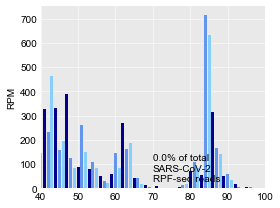

In [22]:
calc_plot_TISL_enrichment('48h0008U', assay_prefix = 'RPFSeq',sample_prefix='RPF', offset_RPF = 13,
                        quant_range = (58,59), plot_range = (39,100), as_RPM = True, 
                        figsize = (4,3), OutFigname = '')

In [33]:
'''Fig.3c: RPF48h'''
plot_CUGalignments(assay_prefix = 'RPFSeq',sample_prefix = 'RPF',hpi = '48h', 
                       offset_RPF = 12, pos_5end = 46, window_downstream = 1, 
                      n_display_sgRNA = 3, n_topreads = 3, OutFigname='Fig3c/FigRR_RPF48h_exactTIS-L.pdf')


In [34]:
'''Fig.3e: RPF48h, 0008U (low RNase I conc.)'''
##CAUTION: used 13nt as RPF offset, based on the previous analysis on triplet periodicity
plot_CUGalignments(assay_prefix = 'RPFSeq',sample_prefix = 'RPF',hpi = '48h0008U', 
                       offset_RPF = 13, pos_5end = 45, window_downstream = 1, 
                      n_display_sgRNA = 3, n_topreads = 3, OutFigname='Fig3c/FigRR_RPF48h0008U_exactTIS-L.pdf')


In [31]:
arr_RPF_list = []
for rep in range(1,3+1):
    samplename = f'RPF_48h_rep{rep}'
    _, _, arr_RPF = get_readpos_arr(samplename,'RPFSeq',norm_by_nh=True,
                                    pos_5end_range=(0,29903), f2_5p_range=None, fetch_range=(0,29903),
                                    offset_RPF = 12,junction_spanning_only=False,
                                    min_rlen=0,as_RPM=True)
    arr_RPF_list.append(arr_RPF)
        
avg_arr_RPF = np.array(arr_RPF_list).mean(axis=0)
max_idxs = avg_arr_RPF.argsort()[-10:][::-1]
for max_idx in max_idxs:
    print(max_idx, avg_arr_RPF[max_idx], SARSCOV2_genome[max_idx-3:max_idx+3])

58 74860.96261178881 GATCTG
28273 18666.947299566564 AAAATG
11974 12367.412112018059 GATACT
61 8988.149803969156 CTGTTC
59 8384.67794999604 ATCTGT
28276 6507.379525843749 ATGTCT
11975 5927.427554923927 ATACTA
50 5888.4151652746 CTCTTG
11973 4782.24737064084 AGATAC
26828 3398.8357292001515 CTGTTT


### Figure 3d, 3f, 3h, Extended Data Figures 3d, 4c, 4d: bar plots for TIS-L fraction or expression level

In [57]:
#previous: quant_CUG_tln in quantify_viralORFs.ipynb
def calc_TISL_ORF_fraction(hpi='48h',assay_prefix='RPFSeq',sample_prefix='RPF',offset_RPF = 12, 
                             pos_5end = 46,window_downstream=6,OutF = 'TISL_fraction/021721_RPF48h_fraction.tsv'):
    global CANONICAL_sgRNA_junc_dict
    idx_TISL = 58
    
    pos_5end_range = (pos_5end, pos_5end+window_downstream)
    min_rlen = [78-i for i in range(*pos_5end_range)]
    
    arr_f2_5p_list  = []
    arr_RPF_list    = []
    if hpi == '48h':
        reps=3
    else:
        reps=2
    for rep in range(1,reps+1):
        samplename = f'{sample_prefix}_{hpi}_rep{rep}'
        _, arr_f2_5p, arr_RPF = get_readpos_arr(samplename,assay_prefix,norm_by_nh=True,
                                                pos_5end_range=pos_5end_range, f2_5p_range=None, fetch_range=pos_5end_range,
                                                offset_RPF = offset_RPF,junction_spanning_only=False,
                                                min_rlen=min_rlen,as_RPM=False)
        #raw read count (weighted by 1/nh)
        
        arr_f2_5p_list.append(arr_f2_5p)
        arr_RPF_list.append(arr_RPF)
        
    sum_arr_f2_5p = np.array(arr_f2_5p_list).sum(axis=0)
    sum_arr_RPF   = np.array(arr_RPF_list).sum(axis=0)
    
    TISLreads_df  = [['ORF1a',sum_arr_RPF.sum()-sum_arr_f2_5p.sum()]]
    ORFs = ['S','ORF3a','E','M','ORF6','ORF7a','ORF7b','ORF8','N']
    for ORF in ORFs:
        f2_5p = CANONICAL_sgRNA_junc_dict[ORF][1]
        TISLreads_df.append([ORF,sum_arr_f2_5p[f2_5p]])
        
    TISLreads_df = pd.DataFrame(TISLreads_df)
    TISLreads_df.columns = ['ORF','n_TISLreads']
    TISLreads_df = TISLreads_df.set_index('ORF')
    TISLreads_df['Percentage'] = TISLreads_df['n_TISLreads']/(TISLreads_df['n_TISLreads'].sum())*100
    
    #display(TISLreads_df)
    TISLreads_df.to_csv(RESULTDIR %OutF, sep = '\t')
    return None


In [24]:
#calculation of prerequisite data: relative fraction of each ORF for TIS-L reads

#Calu-3
tmp_hpi_list = ['%dh' %i for i in [0,1,2,4,12,16,24,36,48]]
for tmp_hpi in tmp_hpi_list:
    for tmp_sample_prefix in ['RPF','QTI']:
        calc_TISL_ORF_fraction(hpi=tmp_hpi,assay_prefix='RPFSeq',sample_prefix=tmp_sample_prefix,offset_RPF = 12, 
                               pos_5end = 46,window_downstream=6,
                               OutF = f'TISL_fraction/021721_{tmp_sample_prefix}{tmp_hpi}_fraction.tsv')
#Vero
for tmp_hpi in ['24hVero']:
    for tmp_sample_prefix in ['RPF']:
        calc_TISL_ORF_fraction(hpi=tmp_hpi,assay_prefix='RPFSeq',sample_prefix=tmp_sample_prefix,offset_RPF = 12, 
                               pos_5end = 46,window_downstream=6,
                               OutF = f'TISL_fraction/021721_{tmp_sample_prefix}{tmp_hpi}_fraction.tsv')
#low Rnase conc.
for tmp_hpi in ['48h0008U']:
    for tmp_sample_prefix in ['RPF']:
        calc_TISL_ORF_fraction(hpi=tmp_hpi,assay_prefix='RPFSeq',sample_prefix=tmp_sample_prefix,offset_RPF = 13, 
                               pos_5end = 39, window_downstream=12,
                               OutF = f'TISL_fraction/021721_{tmp_sample_prefix}{tmp_hpi}_fraction.tsv')
#Caco-2
for tmp_hpi in ['48hCaco2']:
    for tmp_sample_prefix in ['RPF','QTI']:
        calc_TISL_ORF_fraction(hpi=tmp_hpi,assay_prefix='RPFSeq',sample_prefix=tmp_sample_prefix,offset_RPF = 12, 
                               pos_5end = 46,window_downstream=6,
                               OutF = f'TISL_fraction/021721_{tmp_sample_prefix}{tmp_hpi}_fraction.tsv')

In [59]:
#For Fig. 3d, 3h, etc (relative fraction bar plot)
def barplot_fraction(sample_prefix='RPF', hpi_list = ['48h','48h0008U'], label_list=['5U','0.008U'],
                    hatch_list=['','///'],ylim=(0,45),rotation_x=0,OutFigname=''):
    global ORF_palette
    merged_df = []
    
    for hpi in hpi_list:
        TISLreads_df = pd.read_csv(RESULTDIR %(f'TISL_fraction/021721_{sample_prefix}{hpi}_fraction.tsv'),
                                   sep = '\t', index_col = 0)
        pct = TISLreads_df['Percentage']
        pct.name = hpi
        merged_df.append(pct)
        
    merged_df = pd.concat(merged_df, axis=1)
    colors    = [ORF_palette[ORF] for ORF in merged_df.index]
    
    fig,ax = plt.subplots(figsize=(6,4))
    width  = 0.8/len(hpi_list)
    x_offset_list = [-0.4+width*(i+1/2) for i in range(len(hpi_list))]
    
    for hpi,label,hatch,x_offset in zip(hpi_list,label_list,hatch_list,x_offset_list):
        ax.bar(np.arange(len(merged_df))+x_offset, merged_df[hpi], width=width, linewidth=0.5,
               edgecolor='k',hatch=hatch,color = colors,label = label)
    
    ax.set_xticks(np.arange(len(merged_df)))
    ax.set_xticklabels(merged_df.index,rotation=rotation_x)
    ax.set_xlim(-0.5,len(merged_df)-0.5)
    ax.set_ylim(*ylim)
    ax.set_ylabel('Relative fraction (%)')
    gRNA_text = 'gRNA\n'
    sgRNA_text= 'sgRNA\n'
    for hpi,label in zip(hpi_list,label_list):
        gRNA_text  += '%-8s %.01f%%\n' %(label+':',merged_df.loc['ORF1a',hpi])
        sgRNA_text += '%-8s %.01f%%\n' %(label+':',100-merged_df.loc['ORF1a',hpi])
    
    ax.text(-0.4,ylim[1]+3,gRNA_text)
    ax.text(4,ylim[1]+3,sgRNA_text)
    ax.axvline(0.5,color='k',linewidth=1.5,linestyle='--')
    #ax.axhline(-3,xmin=0.6,xmax=len(proportion)-0.6,color='k',linewidth=1)
    plt.legend()
    plt.tight_layout()
    if OutFigname != '':
        plt.savefig(FIGDIR %OutFigname)
    else:
        plt.show()
    plt.close()
    
    return None


In [16]:
'''Fig. 3d: RPF 48h (5U vs. 0.008U)'''
'''barplot_fraction(sample_prefix='RPF', hpi_list = ['48h','48h0008U'], label_list=['5U','0.008U'],
                 hatch_list=['','///'],ylim=(0,45),rotation_x=90,
                 OutFigname='Fig3_barplots/Fig3d_RPF48h_5U0008U.pdf')'''

'''Fig. 3h bottom: Calu Vero Caco'''
## To discuss: which hpi for Calu? 24? 48?
barplot_fraction(sample_prefix='RPF', hpi_list = ['24h','24hVero'], label_list=['Calu-3','Vero'],
                 hatch_list=['','/'],ylim=(0,45),rotation_x=90,
                 OutFigname='Fig3_barplots/Fig3h_CaluVero.pdf')
barplot_fraction(sample_prefix='RPF', hpi_list = ['48h','48hCaco2'], label_list=['Calu-3','Caco-2'],
                 hatch_list=['','/'],ylim=(0,45),rotation_x=90,
                 OutFigname='Fig3_barplots/Fig3h_CaluCaco.pdf')
barplot_fraction(sample_prefix='QTI', hpi_list = ['48h','48hCaco2'], label_list=['Calu-3','Caco-2'],
                 hatch_list=['','/'],ylim=(0,45),rotation_x=90,
                 OutFigname='Fig3_barplots/Fig3h_CaluCaco_QTI.pdf')

'''ExtDatFig.3d : QTI 48h'''
'''barplot_fraction(sample_prefix='QTI', hpi_list = ['48h'], label_list=['QTI 48h'],
                 hatch_list=[''],ylim=(0,45),rotation_x=90,
                 OutFigname='Fig3_barplots/ExtDatFig3d_QTI48h.pdf')
'''
'''Fig. 4c: Calu RPF,QTI 16, 24, 36h'''
'''barplot_fraction(sample_prefix='RPF', hpi_list = ['16h','24h','36h'], label_list=['16 hpi','24 hpi','36 hpi'],
                 hatch_list=['','/','///'],ylim=(0,55),rotation_x=90,
                 OutFigname='Fig3_barplots/ExtDatFig4c_RPF_162436h.pdf')
barplot_fraction(sample_prefix='QTI', hpi_list = ['16h','24h','36h'], label_list=['16 hpi','24 hpi','36 hpi'],
                 hatch_list=['','/','///'],ylim=(0,55),rotation_x=90,
                 OutFigname='Fig3_barplots/ExtDatFig4c_QTI_162436h.pdf')'''

"barplot_fraction(sample_prefix='RPF', hpi_list = ['16h','24h','36h'], label_list=['16 hpi','24 hpi','36 hpi'],\n                 hatch_list=['','/','///'],ylim=(0,55),rotation_x=90,\n                 OutFigname='Fig3_barplots/ExtDatFig4c_RPF_162436h.pdf')\nbarplot_fraction(sample_prefix='QTI', hpi_list = ['16h','24h','36h'], label_list=['16 hpi','24 hpi','36 hpi'],\n                 hatch_list=['','/','///'],ylim=(0,55),rotation_x=90,\n                 OutFigname='Fig3_barplots/ExtDatFig4c_QTI_162436h.pdf')"

In [12]:
#For Fig. 3f, ExtDatFig. 4d (comparison b/w annotated ORF translation and ORF from TIS-L for each gene)

def calc_barplot_TISL_exp(sample_prefix='RPF', hpi = '36h',offset_RPF = 12,quant_range=(58,64),
                          hatch_list=['','///'],ylim=(0,5),rotation_x=0,OutFigname=''):
    global ORF_palette
    ORF_list = ['ORF1a','S','ORF3a','E','M','ORF6','ORF7a','ORF7b','ORF8','N','ORF10']
    
    ##calculte and load 48h annotated AUG translatin level
    '''df_precalc_ORF1ab_PRFratio = pd.read_csv(RESULTDIR %('timecourse_SARSCOV2exp/021721_RPF_ORF1ab_PRF.tsv'), sep = '\t',index_col=0)
    calc_timecourse_RPFexp([hpi], assay_prefix = 'RPFSeq', sample_prefix=sample_prefix, offset_RPF = offset_RPF,
                           quant_range = (0,15), as_RPM = True, df_precalc_ORF1ab_PRFratio = df_precalc_ORF1ab_PRFratio, 
                           OutF = f'timecourse_SARSCOV2exp/021721_RPF_quantification_{hpi}only.tsv')'''
    
    exp_df = pd.read_csv(RESULTDIR %(f'timecourse_SARSCOV2exp/021721_{sample_prefix}_quantification_woTISL_S.tsv'),
                         sep = '\t', index_col = 0)
    
    merged_df = pd.DataFrame(index=ORF_list)
    merged_df['annot_RPM'] = exp_df.loc[ORF_list,hpi]
    ####################################################
    ## calculate read enrichment at TISL and 
    ## distribute them in proportion to the precalculated relative fractions
    TISLreads_df = pd.read_csv(RESULTDIR %(f'TISL_fraction/021721_{sample_prefix}{hpi}_fraction.tsv'),
                               sep = '\t', index_col = 0)
    TISL_pct = TISLreads_df['Percentage']
    arr_RPF_list  = []
    if hpi == '48h':
        reps=3
    else:
        reps=2
    for rep in range(1,reps+1):
        samplename = f'{sample_prefix}_{hpi}_rep{rep}'
        _, _, arr_RPF = get_readpos_arr(samplename,'RPFSeq',norm_by_nh=True,
                                        pos_5end_range=(0,29903), f2_5p_range=None, fetch_range=quant_range,
                                        offset_RPF = offset_RPF,junction_spanning_only=False,
                                        min_rlen=0,as_RPM=True)

        arr_RPF_list.append(arr_RPF)

    avg_arr_RPF = np.array(arr_RPF_list).mean(axis=0)
    TISL_mapped = avg_arr_RPF[quant_range[0]:quant_range[1]].sum()
    TISL_RPM    = TISL_pct*TISL_mapped/100
    merged_df['TISL_RPM'] = TISL_RPM
    merged_df   = merged_df.fillna(0.0)
    ######################################################    
    
    display(merged_df)
    
    colors    = [ORF_palette[ORF] for ORF in merged_df.index]
    cond_list = merged_df.columns
    label_list= ['Canonical AUG','TIS-L']
    df_source = pd.DataFrame(columns = label_list, index = merged_df.index)
    
    fig,ax = plt.subplots(figsize=(6,4))
    width  = 0.8/len(cond_list)
    x_offset_list = [-0.4+width*(i+1/2) for i in range(len(cond_list))]
    
    for cond,label,hatch,x_offset in zip(cond_list,label_list,hatch_list,x_offset_list):
        vals = np.log10(merged_df[cond]+1)
        ax.bar(np.arange(len(merged_df))+x_offset, vals, width=width, linewidth=0.5,
               edgecolor='k',hatch=hatch,color = colors,label = label)
        df_source[label] = vals
    
    ax.set_xticks(np.arange(len(merged_df)))
    ax.set_xticklabels(merged_df.index, rotation=rotation_x)
    ax.set_xlim(-0.5,len(merged_df)-0.5)
    ax.set_ylim(*ylim)
    ax.set_ylabel('log10(RPM+1)')
    
    ax.axvline(0.5,color='k',linewidth=1.5,linestyle='--')
    
    plt.legend()
    plt.tight_layout()
    if OutFigname != '':
        plt.savefig(FIGDIR %OutFigname)
        df_source.to_csv(SOURCEDATADIR %(OutFigname.replace('pdf','tsv')), sep = '\t')
    else:
        plt.show()
    plt.close()
    
    return None


In [13]:
'''Fig.3f: RPF'''
calc_barplot_TISL_exp(sample_prefix='RPF', hpi = '36h',offset_RPF = 12,quant_range=(58,64),
                      hatch_list=['','///'],ylim=(0,5),rotation_x=90,
                      OutFigname='Fig3_barplots/Fig3f_RPF_annot_TISL.pdf')
'''ExtDatFig.4d: QTI'''
calc_barplot_TISL_exp(sample_prefix='QTI', hpi = '36h',offset_RPF = 12,quant_range=(58,64),
                      hatch_list=['','///'],ylim=(0,5),rotation_x=90,
                      OutFigname='Fig3_barplots/ExtDatFig.4d_QTI_annot_TISL.pdf')

,annot_RPM,TISL_RPM
ORF1a,105.818750,671.103372
S,8.637710,964.120337
ORF3a,834.810537,233.153284
E,389.033652,233.153284
M,1889.308844,198.495363
ORF6,401.413564,9767.232169
ORF7a,2230.679694,2284.272040
ORF7b,413.079963,28.356480
ORF8,97.863007,2397.697962
N,8149.582970,3223.186616


,annot_RPM,TISL_RPM
ORF1a,71.190628,462.138466
S,13.140028,145.938463
ORF3a,698.253459,243.230772
E,268.593588,243.230772
M,1094.842478,218.907695
ORF6,582.785177,4961.907746
ORF7a,1532.493368,1970.169252
ORF7b,527.328549,0.000000
ORF8,94.401192,2043.138483
N,5087.301753,1751.261557


In [30]:
def calc_plot_timecourse_exp_TISL_S(sample_prefix='RPF',hpi_list=[], offset_RPF = 12,window_downstream=15,
                                    OutF = '', OutFigname=''):
    global ORF_palette, CANONICAL_sgRNA_junc_dict
    idx_TISL     = 58
    idx_f1_3p_S,idx_f2_5p_S  = CANONICAL_sgRNA_junc_dict['S']
    #print(idx_f1_3p_S,idx_f2_5p_S)
    exp_df = pd.read_csv(RESULTDIR %(f'timecourse_SARSCOV2exp/021721_{sample_prefix}_quantification_woTISL_S.tsv'),
                         sep = '\t', index_col = 0)
    
    exp_df = exp_df[hpi_list]
    
    S_after_list = []
    
    
    for hpi in hpi_list:
        print(hpi,time.ctime())
        ####################################################
        ## calculate read enrichment at TISL and 
        ## distribute them in proportion to the precalculated relative fractions 
        ## (used 48h fraction for early time points)
        if hpi in ['0h','1h','2h','4h','12h','16h']:
            TISLreads_df = pd.read_csv(RESULTDIR %(f'TISL_fraction/021721_{sample_prefix}48h_fraction.tsv'),
                                       sep = '\t', index_col = 0)
        else:
            TISLreads_df = pd.read_csv(RESULTDIR %(f'TISL_fraction/021721_{sample_prefix}{hpi}_fraction.tsv'),
                                       sep = '\t', index_col = 0)
        TISL_pct = TISLreads_df.loc['S','Percentage']
        
        arr_RPF_list = []
        if hpi == '48h':
            reps=3
        else:
            reps=2
        for rep in range(1,reps+1):
            samplename = f'{sample_prefix}_{hpi}_rep{rep}'
            _, _, arr_RPF = get_readpos_arr(samplename,'RPFSeq',norm_by_nh=True,
                                            pos_5end_range=(0,29903), f2_5p_range=None, fetch_range=(0,29903),
                                            offset_RPF = offset_RPF,junction_spanning_only=False,
                                            min_rlen=0,as_RPM=True)

            arr_RPF_list.append(arr_RPF)

        avg_arr_RPF   = np.array(arr_RPF_list).mean(axis=0)
        window_leader = min(window_downstream,idx_f1_3p_S-idx_TISL)
        window_body   = window_downstream-window_leader
        
        S_TISL    = avg_arr_RPF[idx_TISL:idx_TISL+window_leader].sum()*TISL_pct/100
        S_TISL   += avg_arr_RPF[idx_f2_5p_S:idx_f2_5p_S+window_body].sum()
        
        
        S_after_list.append(exp_df.loc['S',hpi]+S_TISL)
    
    exp_df.loc['S_after'] = S_after_list
    display(exp_df)
    exp_df.to_csv(RESULTDIR %OutF, sep='\t')
    plot_timecourse_exp(exp_df,log10=True,ylim=(0,4),psc = 1.0,grey_exceptS=True,
                        ORFs_to_highlight=[],OutFigname = OutFigname)
    
    return None



In [31]:
'''Fig.3g, ExtDatFig.4e (left): RPF, QTI with TISL_S'''
tmp_hpi_list = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
for tmp_sample_prefix in ['RPF','QTI']:
    calc_plot_timecourse_exp_TISL_S(sample_prefix=tmp_sample_prefix,hpi_list=tmp_hpi_list, offset_RPF = 12,
                                    window_downstream=15,
                                    OutF = f'timecourse_SARSCOV2exp/021721_{tmp_sample_prefix}_quantification_TISL_S.tsv',
                                    OutFigname=f'Fig2b_timecourse_SARSCOV2exp/ExtDatFig4e_{tmp_sample_prefix}.pdf')


0h Wed Mar 31 16:23:02 2021
1h Wed Mar 31 16:23:10 2021
2h Wed Mar 31 16:23:21 2021
4h Wed Mar 31 16:23:35 2021
12h Wed Mar 31 16:23:50 2021
16h Wed Mar 31 16:23:55 2021
24h Wed Mar 31 16:24:00 2021
36h Wed Mar 31 16:24:04 2021


,0h,1h,2h,4h,12h,16h,24h,36h
ORF,,,,,,,,
ORF1a,0.000000,0.000000,0.000000,0.000000,2.420761,3.848847,35.377896,105.818750
ORF1b,0.000000,0.000000,0.000000,0.000000,1.716461,3.013308,23.985943,66.246779
S,0.000000,0.000000,0.000000,0.081899,0.000000,0.578354,3.044923,8.637710
ORF3a,0.000000,0.101959,0.188810,6.699876,5.498802,20.341246,293.530734,834.810537
E,0.140218,0.000000,0.000000,5.598954,2.713601,11.387999,117.890693,389.033652
M,0.000000,0.000000,0.094405,7.261089,23.501650,80.488151,937.694018,1889.308844
ORF6,0.000000,0.000000,0.000000,1.261700,2.127921,6.042872,76.431588,401.413564
ORF7a,0.000000,0.114928,0.188810,8.904739,7.847964,43.417664,665.602721,2230.679694
ORF7b,0.000000,0.000000,0.000000,2.426403,8.463002,18.626729,140.373620,413.079963


0h Wed Mar 31 16:24:10 2021
1h Wed Mar 31 16:24:14 2021
2h Wed Mar 31 16:24:20 2021
4h Wed Mar 31 16:24:27 2021
12h Wed Mar 31 16:24:33 2021
16h Wed Mar 31 16:24:36 2021
24h Wed Mar 31 16:24:38 2021
36h Wed Mar 31 16:24:40 2021


,0h,1h,2h,4h,12h,16h,24h,36h
ORF,,,,,,,,
ORF1a,0.000000,0.000000,0.000000,0.411109,2.009605,9.560125,124.237608,71.190628
ORF1b,0.000000,0.000000,0.000000,0.090497,1.424927,7.484736,84.232149,44.568186
S,0.000000,0.000000,0.000000,0.000000,0.000000,0.745068,17.291390,13.140028
ORF3a,0.000000,1.585299,0.795824,2.923833,9.173421,95.845618,702.125246,698.253459
E,0.000000,0.000000,0.198956,1.849991,5.287556,34.835483,316.101780,268.593588
M,0.000000,0.528433,0.000000,0.822218,28.726653,117.367168,873.417625,1094.842478
ORF6,0.000000,0.000000,0.000000,0.205555,4.620833,14.775599,311.766944,582.785177
ORF7a,0.000000,1.056866,0.000000,3.505945,22.496250,121.683348,1090.674377,1532.493368
ORF7b,0.000000,0.000000,0.994780,1.644437,16.607071,155.814106,1213.368826,527.328549


In [32]:
def calc_plot_timecourse_TE_TISL_S(InF_mRNA, InF_RPF, OutF_TE, OutFigname=''):
    calc_timecourse_TE(InF_mRNA, InF_RPF, OutF_TE)
    
    TE_df = pd.read_csv(RESULTDIR %(OutF_TE), sep = '\t', index_col=0)
    plot_timecourse_exp(TE_df,log10=True,ylim=(-1.5,1.5), psc = 0.0, grey_exceptS=True,
                        OutFigname=OutFigname)
    
    return None



In [33]:
'''Fig.3g, ExtDatFig.4e (right): RPF, QTI TE with TISL_S'''
for tmp_sample_prefix in ['RPF','QTI']:
    calc_plot_timecourse_TE_TISL_S('timecourse_SARSCOV2exp/021721_mRNA_quantification.tsv',  
                                   f'timecourse_SARSCOV2exp/021721_{tmp_sample_prefix}_quantification_TISL_S.tsv', 
                                   f'timecourse_SARSCOV2exp/021721_TE_{tmp_sample_prefix}_quantification_TISL_S.tsv',
                                   OutFigname= f'Fig2b_timecourse_SARSCOV2exp/ExtDatFig4e_TE_{tmp_sample_prefix}_TISL_S.pdf')
    

,0h,1h,2h,4h,12h,16h,24h,36h
ORF1a,0.902678,0.885152,0.892946,0.523533,0.199666,0.151520,0.227713,0.314608
ORF1b,0.902678,0.885152,0.892946,0.523533,0.158557,0.125410,0.156403,0.198059
S,1.000000,1.000000,1.000000,0.447339,0.096871,0.081797,0.046570,0.098176
ORF3a,0.957734,1.101959,1.133313,2.553803,0.280778,0.540013,1.150045,2.592439
E,1.140218,1.000000,1.000000,4.991612,0.960431,1.810863,3.515035,8.005347
M,0.977574,1.000000,1.037284,1.028751,0.540118,0.827629,1.574352,2.500011
ORF6,1.000000,1.000000,1.000000,1.750640,1.018159,1.172983,2.889146,7.565054
ORF7a,1.000000,1.114928,1.105627,2.098938,0.292322,1.014608,2.287256,5.014661
ORF7b,1.000000,1.000000,0.930028,0.726098,0.312642,0.448322,0.485083,0.930452
ORF8,1.000000,1.000000,1.054030,0.254506,0.045174,0.053128,0.148677,0.248912


,0h,1h,2h,4h,12h,16h,24h,36h
ORF1a,0.902678,0.885152,0.892946,0.738762,0.175667,0.329989,0.783943,0.212619
ORF1b,0.902678,0.885152,0.892946,0.570911,0.141540,0.265136,0.533523,0.134210
S,1.000000,1.000000,1.000000,0.413476,0.096871,0.090437,0.210594,0.144040
ORF3a,0.957734,2.585299,1.711991,1.301410,0.439538,2.450553,2.745471,2.168879
E,1.000000,1.000000,1.198956,2.155804,1.626120,5.238390,9.375199,5.533343
M,0.977574,1.528433,0.947806,0.226920,0.655299,1.202189,1.466550,1.449297
ORF6,1.000000,1.000000,1.000000,0.933144,1.829618,2.627410,11.670036,10.974695
ORF7a,1.000000,2.056866,0.930028,0.954866,0.776277,2.802386,3.745768,3.445812
ORF7b,1.000000,1.000000,1.855202,0.560389,0.581709,3.582016,4.166759,1.187172
ORF8,1.000000,1.264216,0.976101,0.230063,0.058347,0.177831,0.325886,0.240196


### Fig. R (for reviewer only, TIS-L fraction comparison b/w previous and cured 48h Calu samples)

In [60]:
calc_plot_TISL_enrichment('48hCalu3cured', assay_prefix = 'RPFSeq',sample_prefix='RPF', offset_RPF = 12,
                        quant_range = (58,59), plot_range = (39,100), as_RPM = True, 
                        figsize = (4,3), OutFigname = 'Fig3b/FigR_RPF48hCalu3cured.pdf')
calc_plot_TISL_enrichment('48hCalu3cured', assay_prefix = 'RPFSeq',sample_prefix='QTI', offset_RPF = 12,
                        quant_range = (58,59), plot_range = (39,100), as_RPM = True, 
                        figsize = (4,3), OutFigname = 'Fig3b/FigR_QTI48hCalu3cured.pdf')

for tmp_hpi in ['48hCalu3cured']:
    for tmp_sample_prefix in ['RPF','QTI']:
        calc_TISL_ORF_fraction(hpi=tmp_hpi,assay_prefix='RPFSeq',sample_prefix=tmp_sample_prefix,offset_RPF = 12, 
                               pos_5end = 46,window_downstream=6,
                               OutF = f'TISL_fraction/021721_{tmp_sample_prefix}{tmp_hpi}_fraction.tsv')
        
barplot_fraction(sample_prefix='RPF', hpi_list = ['48h','48hCalu3cured'], label_list=['previous','Mycoplasma cured'],
                 hatch_list=['','/','///'],ylim=(0,45),rotation_x=90,
                 OutFigname='Fig3_barplots/FigR_RPF48h_mycoplasma_cmp.pdf')
barplot_fraction(sample_prefix='QTI', hpi_list = ['48h','48hCalu3cured'], label_list=['previous','Mycoplasma cured'],
                 hatch_list=['','/','///'],ylim=(0,45),rotation_x=90,
                 OutFigname='Fig3_barplots/FigR_QTI48h_mycoplasma_cmp.pdf')


RPF_48hCalu3cured	52736.809839021116	11.187050845645382
QTI_48hCalu3cured	49326.75882488812	12.452554050461785


### Fig. R (comparison b/w Calu and Caco or cured Calu annotated SARS-CoV-2 viral ORF expression levels)

In [10]:
def calc_barplot_cmp_annot_exp(sample_prefix='RPF', hpi_list = ['48h','48hCaco2'], label_list=['Calu-3','Caco-2'],
                    hatch_list=['','///'], ylim=(0,5),as_pct = False,rotation_x=0,OutFigname=''):
    global ORF_palette
    merged_df = []
    exp_df = pd.read_csv(RESULTDIR %(f'timecourse_SARSCOV2exp/021721_{sample_prefix}_quantification_woTISL_S.tsv'),
                         sep = '\t', index_col = 0)
    for hpi in hpi_list:
        exp = exp_df[hpi]
        if as_pct:
            exp = exp/exp.sum()*100
        merged_df.append(exp)
        
    merged_df = pd.concat(merged_df, axis=1)
    colors    = [ORF_palette[ORF] for ORF in merged_df.index]
    
    fig,ax = plt.subplots(figsize=(6,4))
    width  = 0.8/len(hpi_list)
    x_offset_list = [-0.4+width*(i+1/2) for i in range(len(hpi_list))]
    
    for hpi,label,hatch,x_offset in zip(hpi_list,label_list,hatch_list,x_offset_list):
        if as_pct:
            ax.bar(np.arange(len(merged_df))+x_offset, merged_df[hpi], width=width, linewidth=0.5,
                   edgecolor='k',hatch=hatch,color = colors,label = label)
        else:
            ax.bar(np.arange(len(merged_df))+x_offset, np.log10(merged_df[hpi]+1), width=width, linewidth=0.5,
                   edgecolor='k',hatch=hatch,color = colors,label = label)
    
    ax.set_xticks(np.arange(len(merged_df)))
    ax.set_xticklabels(merged_df.index,rotation=rotation_x)
    ax.set_xlim(-0.5,len(merged_df)-0.5)
    ax.set_ylim(*ylim)
    if as_pct:
        ax.set_ylabel('Relative fraction (%)')
    else:
        ax.set_ylabel('log10(RPM+1)')
        
    
    
    ax.axvline(1.5,color='k',linewidth=1.5,linestyle='--')
    #ax.axhline(-3,xmin=0.6,xmax=len(proportion)-0.6,color='k',linewidth=1)
    plt.legend()
    plt.tight_layout()
    if OutFigname != '':
        plt.savefig(FIGDIR %OutFigname)
    else:
        plt.show()
    plt.close()
    
    return None


In [12]:
for sample_prefix in ['RPF','QTI']:
    calc_barplot_cmp_annot_exp(sample_prefix=sample_prefix, hpi_list = ['48h','48hCaco2'], label_list=['Calu-3','Caco-2'],
                        hatch_list=['','///'],ylim=(0,5),rotation_x=90,
                               OutFigname = f'Fig3_barplots/FigR_{sample_prefix}48h_annotORFs_cmp.pdf')

In [65]:
'''for sample_prefix in ['RPF','QTI']:
    calc_barplot_cmp_annot_exp(sample_prefix=sample_prefix, hpi_list = ['48h','48hCalu3cured'], label_list=['Before treatment','After treatment'],
                        hatch_list=['','///'],ylim=(0,5),rotation_x=90,
                               OutFigname = f'Fig3_barplots/FigR_{sample_prefix}48h_mycoplasma_annotORFs_cmp.pdf')'''
for sample_prefix in ['RPF','QTI']:
    calc_barplot_cmp_annot_exp(sample_prefix=sample_prefix, hpi_list = ['48h','48hCalu3cured'], label_list=['Before treatment','After treatment'],
                        hatch_list=['','///'],ylim=(0,80),rotation_x=90,as_pct = True,
                               OutFigname = f'Fig3_barplots/FigR_{sample_prefix}48h_mycoplasma_annotORFs_cmp_pct.pdf')

## Figure 4 (RPF-seq read map for each ORF)
- Figure 4a-d, Extended Data Figure 5a-f: RPF-seq
- Extended Data Figure 6a-j: QTI-seq
- Extended Data Figures 5g, 6k: ORF7b
- Extended Data Figures 5h, 6i, R: ORF10


### Figure 4a-d, Extended Data Figure 5a-f: RPF-seq
### Extended Data Figure 6a-j: QTI-seq

In [27]:
#previous sgRNA_plot_v2 in quantify_viralORFs.ipynb
#ylim_dict = {'ORF1a':3, 'S': 3,'ORF3a':4,'E':2.5,'M':3,  'ORF6':4,'ORF7a':4,'ORF7b':2,'ORF8':3.5,'N':4}
def plot_sgRNA(ORF = 'N',hpi_list = ['16h','24h','36h'], s = 49,
               assay_prefix = 'RPFSeq', sample_prefix = 'RPF', as_RPM = True, offset_RPF = 12,
               as_log10= True, ylim= 4, OutFigname=''):
    global CANONICAL_sgRNA_junc_dict, SARSCOV2_genome
    sgRNA_junc_dict = CANONICAL_sgRNA_junc_dict.copy()
    sgRNA_junc_dict['ORF1a'] = [75,75] ##no junction, CUG-translation gRNA ORF end
    idx_TISL = 58
    contig_len  =  len(SARSCOV2_genome)
    grid     = GridSpec(nrows=2*(1+len(hpi_list)),ncols=1)
    fig      = plt.figure(figsize=(10,1.5*(1+len(hpi_list))))
    thickness= 5
    
    junc_5p, junc_3p  = sgRNA_junc_dict[ORF]
    
    df_SARSCOV2_annot = get_df_SARSCOV2_annot(exc_UTR = True)
    ORFstart          = df_SARSCOV2_annot.at[ORF,'ORFstart']
    ORFstart_shifted  = (ORFstart-junc_3p)+(junc_5p-s)
    
    window_size       = 50*(ORFstart_shifted//50+1)
    if ORF in ['ORF3a','E']:
        window_size  += 50
    elif ORF == 'M':
        window_size  += 100
    
    if window_size == 50:
        ticklabel_width = 10
    else:
        ticklabel_width = 20
    
    e = ORFstart + (window_size-ORFstart_shifted)
    
    df_source = []
    for hpi_idx,hpi in enumerate(hpi_list):
        arr_RPF_list  = []
        if hpi == '48h':
            reps=3
        else:
            reps=2
        for rep in range(1,reps+1):
            samplename = f'{sample_prefix}_{hpi}_rep{rep}'
            _, _, arr_RPF = get_readpos_arr(samplename,assay_prefix,norm_by_nh=True,
                                            pos_5end_range=(0,29903), f2_5p_range=None, fetch_range=(0,29903),
                                            offset_RPF = offset_RPF,junction_spanning_only=False,
                                            min_rlen=0,as_RPM=as_RPM)

            arr_RPF_list.append(arr_RPF)
        
        avg_arr_RPF  = np.array(arr_RPF_list).mean(axis=0)
        
        TISLreads_df = pd.read_csv(RESULTDIR %(f'TISL_fraction/021721_{sample_prefix}{hpi}_fraction.tsv'),
                            sep = '\t', index_col = 0)
        TISL_pct     = TISLreads_df.loc[ORF,'Percentage']
        arr_RPF_fused= np.concatenate((avg_arr_RPF[s:junc_5p]*TISL_pct/100, avg_arr_RPF[junc_3p:e]))
        
        if as_log10:
            psc = 1
            arr_RPF_fused = np.log10(arr_RPF_fused+psc)
        
        x = np.arange(len(arr_RPF_fused))
        tmp_xticklabels = np.arange(s,junc_5p)+1 #1-base coordinate
        xticks      = [i for i,nt in enumerate(tmp_xticklabels) if nt%ticklabel_width == 0]
        xticklabels = tmp_xticklabels[xticks]
        
        tmp_xticklabels = np.arange(junc_3p,e)+1 #1-base coordinate
        tmp_xticks      = [i for i,nt in enumerate(tmp_xticklabels) if nt%ticklabel_width == 0]
        tmp_xticklabels = tmp_xticklabels[tmp_xticks]
        xticks = xticks+[i+junc_5p-s for i in tmp_xticks]
        xticklabels= np.concatenate((xticklabels,tmp_xticklabels))

        bar_colors = [['darkblue','cornflowerblue','lightskyblue'][(i-ORFstart_shifted)%3] for i in x]

        ax1 = fig.add_subplot(grid[hpi_idx*2:hpi_idx*2+2,0])
        if ORF != 'ORF1a':
            ax1.axvline(junc_5p-s-0.5,linestyle='--',color='k')
            if hpi_idx == 0:
                #ax1.text(0,ylim+0.1,'Estimated RPM')
                #ax1.text(junc_5p-s,ylim+0.1,'Measured RPM')
                ax1.text(junc_5p-s,ylim+0.1,'Junction')
        ax1.bar(x,arr_RPF_fused,color = bar_colors)
        
        ax1.set_xlim((-0.5,len(arr_RPF_fused)-0.5))
        ax1.text(len(arr_RPF_fused)*0.95,ylim*0.9,hpi.replace('h', ' hpi'))
        ax1.set_xticks(xticks)
        if hpi_idx==(len(hpi_list)-1):
            ax1.set_xticklabels(xticklabels)
            #ax1.set_xlabel('Genomic position (nt)')
        else:
            ax1.set_xticklabels(['' for x in range(len(xticks))])

        if as_log10:
            #ax1.set_ylabel('$\mathregular{log_{10}}$ (Avg. RPM+1)')
            if ylim != None:
                ax1.set_ylim(0,ylim)
        else:
            ax1.set_ylabel('Avg. RPM')
        df_source.append(arr_RPF_fused)
        
    df_source = pd.DataFrame(df_source)
    df_source.index   = hpi_list
    df_source.columns = np.concatenate([np.arange(s,junc_5p), np.arange(junc_3p,e)])+1
    df_source = df_source.T
    df_source.to_csv(SOURCEDATADIR %OutFigname.replace('.pdf','.tsv'), sep = '\t')    

    ######################
    ax2 = fig.add_subplot(grid[len(hpi_list)*2:len(hpi_list)*2+2,0])

    annot_image = vis_cov2annotation(thickness)
    annot_image = np.concatenate((annot_image,np.full((thickness*2,contig_len,3),255)),axis=0)
    annot_image = np.concatenate((annot_image[:,s:junc_5p],annot_image[:,junc_3p:e]),axis=1)
    annot_texts = get_annot_textlist(s,junc_5p,thickness)
    annot_texts+= [[i[0],i[1],i[2]+junc_5p-s] for i in get_annot_textlist(junc_3p,e,thickness)]
    for txt,ypos,xpos in annot_texts:
        if txt == '5\'UTR':
            color='white'
        else:
            color='k'
        ax2.text(xpos,ypos,txt,size=12,color=color)
    ax2.text(1,thickness/2,'Leader',size=12,color='white')


    trs_list = get_trs_b_list(s,junc_5p)
    trs_list+= [i+junc_5p-s for i in get_trs_b_list(junc_3p,e)]
    for trs_pos in trs_list:
        if ORF == 'ORF1a':
            TRS = 'TRS-L'
        else:
            TRS = 'TRS-B'
        ax2.text(trs_pos,int(thickness*1.2),TRS,size=12)
        annot_image[int(thickness*0.6):int(thickness*1.0),trs_pos:trs_pos+6] = (255,215,0)

    ax2.text(58-s,int(thickness*1.2),'CUG',size=12)
    annot_image[int(thickness*0.6):int(thickness*1.0),58-s:61-s] = (255,87,51)

    ax2.text(ORFstart_shifted,int(thickness*1.2),'AUG',size=12)
    annot_image[int(thickness*0.6):int(thickness*1.0),ORFstart_shifted:ORFstart_shifted+3] = (0,255,0)
    txt = SARSCOV2_genome[idx_TISL:junc_5p]+SARSCOV2_genome[junc_3p:]

    for i in range(0,len(txt),3):
        codon = txt[i:i+3]
        if codon in ['TGA','TAA','TAG']:
            putative_ORF_end = i+3
            break
    ax2.text(58-s,thickness*2.5,'ORF from TIS-L (%da.a)' %((putative_ORF_end-3)/3),size=12)
    annot_image[int(thickness*2):int(thickness*3),idx_TISL-s:idx_TISL-s+putative_ORF_end] = (3,181,148)

    ax2.imshow(annot_image,aspect='auto')
    if ORF != 'ORF1a':
        ax2.axvline(junc_5p-s-0.5,linestyle='--',color='k')
        
    ###nucleotide text###
    nt_fused  = (SARSCOV2_genome[s:junc_5p]+SARSCOV2_genome[junc_3p:e]).replace('T','U')
    nt_font_size = min(10,1000//window_size)
    for i in range(len(arr_RPF_fused)):
        ax2.text(i-0.5,0,nt_fused[i],fontsize=nt_font_size)
    #####################
    
    ax2.set_xlim((-0.5,len(arr_RPF_fused)-0.5))
    ax2.set_xticks([])
    ax2.set_yticks([0,2,14.5])
    #ax2.set_yticklabels(['','sgRNA',''])
    ax2.set_yticklabels([])
    ax2.grid(False)
    #####################
    plt.tight_layout()
    if OutFigname != '':
        plt.savefig(FIGDIR %OutFigname)
    else:
        plt.show()
    plt.close()
    return None

def vis_cov2annotation(thickness = 5):
    #thickness %5 == 0
    global ORF_palette
    thick_unit = thickness//5
    df_SARSCOV2_annot = get_df_SARSCOV2_annot(exc_UTR = False)
    
    '''color_dict = {'5\'UTR': (112, 112, 112),#'#707070',
               'ORF1a':  (251, 222, 142),#'#fbde8e',
               'ORF1b':  (204, 232, 255),#'#cce8ff',
               'S':      (214, 39, 40),#'#d62728',
               'ORF3a':  (140, 86, 75),#'#8c564b',
               'E':      (27, 20, 100),#'#1b1464',
               'M':      (31, 119, 180),#'#1f77b4',
               'ORF6':   (148, 103, 189),#'#9467bd',
               'ORF7a':  (255, 127, 14),#'#ff7f0e',
               'ORF7b':  (6, 127, 76),#'#067f4c',
               'ORF8':   (227, 119, 194),#'#e377c2',
               'N':      (188, 189, 34),#'#bcbd22',
               'ORF10':  (59, 207, 73),#'#3bcf49',
               '3\'UTR': (112, 112, 112)#'#707070'
              }'''
    contig_len  =  29903
    arr = np.full((thickness,contig_len,3),255) #all white
    arr[0*thick_unit:5*thick_unit] = 0 ##black line at center
    
    for ORFname,row in df_SARSCOV2_annot.iterrows():
        ORF_s,ORF_e     = row['ORFstart'], row['ORFend']
        color   = ORF_palette[ORFname]
        color_int = []
        for i in range(1,len(color),2):
            color_int.append(int(color[i:i+2],16))
        thick_range=range(thickness)
        arr[thick_range,ORF_s:ORF_e] = color_int
    
    '''plt.imshow(arr[:,27350:27450])
    plt.grid(False)
    plt.show()
    plt.close()'''
    return arr

def get_annot_textlist(s,e,thickness):
    textlist = []
    df_SARSCOV2_annot = get_df_SARSCOV2_annot(exc_UTR = False)
    
    for ORFname,row in df_SARSCOV2_annot.iterrows():
        ORF_s,ORF_e     = row['ORFstart'], row['ORFend']
        if 'UTR' in ORFname:
            pass
        else:
            pass#ORFname += ' (%da.a)' %((ORF_e-ORF_s-3)/3)
        if s<=ORF_s and ORF_s<e:
            if ORF_e <= e: #whole ORF included in the window
                textlist.append([ORFname,thickness//2, (ORF_s+ORF_e)//2 -s-2]) #ORFname, textposition within window
            else:
                textlist.append([ORFname,thickness//2, (ORF_s+e)//2 - s-2])
        elif s<ORF_e and ORF_e<=e:
            textlist.append(    [ORFname,thickness//2, (s+ORF_e)//2 - s-2])
        else:
            pass
        
    return textlist

def get_trs_b_list(s,e):
    global SARSCOV2_genome
    cov2_fa = SARSCOV2_genome[:]
    cov2_fa = cov2_fa[s:e].upper().replace('T','U')
    trs_b_list = []
    for i in re.finditer('ACGAAC',cov2_fa):
        trs_b_list.append(i.start())
    return trs_b_list

In [28]:
#main plots for Fig. 4 and Extended Data Figs. 5,6
tmp_ylim_dict = {'ORF1a':3, 'S': 3,'ORF3a':4,'E':2.5,'M':3,  'ORF6':4,'ORF7a':4,'ORF7b':2,'ORF8':3.5,'N':4}
for tmp_sample_prefix in ['RPF','QTI']:
    for ORF, tmp_ylim in tmp_ylim_dict.items():
        print(tmp_sample_prefix, ORF, time.ctime())
        plot_sgRNA(ORF = ORF, hpi_list = ['16h','24h','36h'], s = 49,
                   assay_prefix = 'RPFSeq', sample_prefix = tmp_sample_prefix, as_RPM = True, offset_RPF = 12,
                   as_log10= True, ylim = tmp_ylim, OutFigname=f'Fig4_individual/Fig4_{tmp_sample_prefix}_{ORF}.pdf')

RPF ORF1a Fri May 21 17:16:44 2021
RPF S Fri May 21 17:17:02 2021
RPF ORF3a Fri May 21 17:17:19 2021
RPF E Fri May 21 17:17:35 2021
RPF M Fri May 21 17:17:52 2021
RPF ORF6 Fri May 21 17:18:09 2021
RPF ORF7a Fri May 21 17:18:26 2021
RPF ORF7b Fri May 21 17:18:42 2021
RPF ORF8 Fri May 21 17:18:59 2021
RPF N Fri May 21 17:19:16 2021
QTI ORF1a Fri May 21 17:19:32 2021
QTI S Fri May 21 17:19:40 2021
QTI ORF3a Fri May 21 17:19:48 2021
QTI E Fri May 21 17:19:56 2021
QTI M Fri May 21 17:20:03 2021
QTI ORF6 Fri May 21 17:20:12 2021
QTI ORF7a Fri May 21 17:20:20 2021
QTI ORF7b Fri May 21 17:20:28 2021
QTI ORF8 Fri May 21 17:20:35 2021
QTI N Fri May 21 17:20:43 2021


In [31]:
def plot_ORF7b_cmp(assay_prefix = 'RPFSeq',sample_prefix = 'RPF',hpi = '36h', ylim=3.5, s = 49,
                   offset_RPF = 12, as_RPM=True, OutFigname = ''):
    global CANONICAL_sgRNA_junc_dict, SARSCOV2_genome
    ORF      = 'ORF7b'
    idx_TISL = 58
    sgRNA_junc_dict = CANONICAL_sgRNA_junc_dict.copy()
    junc_5p,junc_3p = sgRNA_junc_dict[ORF]
    
    contig_len  =  len(SARSCOV2_genome)
    df_SARSCOV2_annot = get_df_SARSCOV2_annot(exc_UTR = False)
    
    
    TISLreads_df = pd.read_csv(RESULTDIR %(f'TISL_fraction/021721_{sample_prefix}{hpi}_fraction.tsv'),
                            sep = '\t', index_col = 0)
    TISL_pct     = TISLreads_df.loc[ORF,'Percentage']    
    
    grid = GridSpec(nrows=11,ncols=1)
    fig  = plt.figure(figsize=(10,6.67*0.75))
    
    as_log10=True
    
    ORFstart        = df_SARSCOV2_annot.at[ORF,'ORFstart']
    ORFstart_shifted= (ORFstart-junc_3p)+(junc_5p-s)
    window_size     = 50*(ORFstart_shifted//50+1)
    e               = ORFstart + (window_size-ORFstart_shifted)
    
    arr_RPF_list    = []
    reps            = 2
    for rep in range(1,reps+1):
        samplename    = f'{sample_prefix}_{hpi}_rep{rep}'
        _, _, arr_RPF = get_readpos_arr(samplename,assay_prefix,norm_by_nh=True,
                                        pos_5end_range=(0,29903), f2_5p_range=None, fetch_range=(0,29903),
                                        offset_RPF = offset_RPF,junction_spanning_only=False,
                                        min_rlen=0,as_RPM=as_RPM)

        arr_RPF_list.append(arr_RPF)

    avg_arr_RPF  = np.array(arr_RPF_list).mean(axis=0)
    
    arr_RPF_raw     = avg_arr_RPF[e-window_size:e]
    arr_RPF_fused   = np.concatenate((avg_arr_RPF[s:junc_5p]*TISL_pct/100, avg_arr_RPF[junc_3p:e]))
    print(arr_RPF_raw.shape,arr_RPF_fused.shape)

    if window_size == 50:
        ticklabel_width = 10
    else:
        ticklabel_width = 20
    df_source = pd.DataFrame(columns = ['position_ORF7a_sgRNA','logRPM_ORF7a_sgRNA','position_ORF7b_sgRNA','logRPM_ORF7b_sgRNA'])
    df_source['position_ORF7a_sgRNA'] = np.arange(e-window_size, e)+1
    df_source['position_ORF7b_sgRNA'] = np.concatenate([np.arange(s,junc_5p),np.arange(junc_3p,e)])+1
    #######RPF, non-fused########
    arr = arr_RPF_raw
    if as_log10:
        psc = 1#1e-03
        arr = np.log10(arr+psc)
    df_source['logRPM_ORF7a_sgRNA'] = arr
    thickness       = 5
    #print(thickness)
    x = np.arange(len(arr))

    bar_colors = [['darkblue','cornflowerblue','lightskyblue'][(i-ORFstart_shifted)%3] for i in x]
    ax1 = fig.add_subplot(grid[0:3,0])

    ax1.bar(x,arr,color = bar_colors)

    ax1.set_xlim((-0.5,len(arr)-0.5))


    tmp_xticklabels = np.arange(e-window_size,e)+1
    xticks = [i for i,nt in enumerate(tmp_xticklabels) if nt%10 == 0]
    xticklabels = tmp_xticklabels[xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticklabels)
    #ax1.set_xlabel('Genomic position (nt)')
    if as_log10:
        #ax1.set_ylabel('%s %s ORF7a sgRNA\n' %(hpi,assay)+'$\mathregular{log_{10}}$ (Avg. RPM+1)')
        ax1.set_ylabel('$\mathregular{log_{10}}$ (Avg. RPM+1)')
    else:
        ax1.set_ylabel('Avg. RPM')
    if ylim != None:
        ax1.set_ylim(0,ylim)
    #########################
    #######Annotation of raw genome########
    ax2 = fig.add_subplot(grid[3:5,0])
    
    annot_image = vis_cov2annotation(thickness)
    annot_image = np.concatenate((annot_image,np.full((thickness,contig_len,3),255)),axis=0)[:,e-window_size:e]
    annot_texts = get_annot_textlist(e-window_size,e,thickness)
    for txt,ypos,xpos in annot_texts:
        ax2.text(xpos,ypos,txt,size=12)
    ax2.text(ORFstart_shifted,int(thickness*1.2),'AUG',size=12)
    annot_image[int(thickness*0.6):int(thickness*1.0),ORFstart_shifted:ORFstart_shifted+3] = (0,255,0)
    
    ###nucleotide text###
    nt_raw  = (SARSCOV2_genome[e-window_size:e]).replace('T','U')
    nt_font_size = min(10,1000//window_size)
    for i in range(len(arr_RPF_raw)):
        ax2.text(i-0.5,0,nt_raw[i],fontsize=nt_font_size)
    #####################
    
    ax2.imshow(annot_image,aspect='auto')

    ax2.set_xlim((-0.5,len(arr)-0.5))
    ax2.set_xticks([])
    ax2.set_yticks([0,2,9.5])
    ax2.set_yticklabels(['','',''])
    ax2.grid(False)
    #####################
    #######RPF, fused########
    arr = arr_RPF_fused
    if as_log10:
        psc = 1#1e-03
        arr = np.log10(arr+psc)
    df_source['logRPM_ORF7b_sgRNA'] = arr
    thickness       = 5
    x = np.arange(len(arr))

    bar_colors = [['darkblue','cornflowerblue','lightskyblue'][(i-ORFstart_shifted)%3] for i in x]
    ax1 = fig.add_subplot(grid[5:8,0])

    ax1.bar(x,arr,color = bar_colors)

    ax1.set_xlim((-0.5,len(arr)-0.5))
    ax1.set_xticks(xticks)

    tmp_xticklabels = np.arange(s,junc_5p)+1 #1-base coordinate
    xticks      = [i for i,nt in enumerate(tmp_xticklabels) if nt%10 == 0]
    xticklabels = tmp_xticklabels[xticks]
    tmp_xticklabels = np.arange(junc_3p,e)+1 #1-base coordinate
    tmp_xticks      = [i for i,nt in enumerate(tmp_xticklabels) if nt%10 == 0]
    tmp_xticklabels = tmp_xticklabels[tmp_xticks]
    xticks = xticks+[i+junc_5p-s for i in tmp_xticks]
    xticklabels= np.concatenate((xticklabels,tmp_xticklabels))
    ax1.set_xticklabels(xticklabels)
    #ax1.set_xlabel('Genomic position (nt)')

    if ORF != 'ORF1a':
        ax1.axvline(junc_5p-s-0.5,linestyle='--',color='k')
        ax1.text(junc_5p-s,ylim+0.1,'Junction')
    if as_log10:
        #ax1.set_ylabel('$\mathregular{log_{10}}$ (Avg. RPM+1)')
        ax1.set_ylabel('log10 (Avg. RPM+1)')
    else:
        ax1.set_ylabel('Avg. RPM')
    if ylim != None:
        ax1.set_ylim(0,ylim)
    ######################

    ax2 = fig.add_subplot(grid[8:11,0])

    annot_image = vis_cov2annotation(thickness)
    annot_image = np.concatenate((annot_image,np.full((thickness*2,contig_len,3),255)),axis=0)
    annot_image = np.concatenate((annot_image[:,s:junc_5p],annot_image[:,junc_3p:e]),axis=1)
    annot_texts = get_annot_textlist(s,junc_5p,thickness)
    annot_texts+= [[i[0],i[1],i[2]+junc_5p-s] for i in get_annot_textlist(junc_3p,e,thickness)]
    for txt,ypos,xpos in annot_texts:
        ax2.text(xpos,ypos,txt,size=12)
    ax2.text(1,thickness/2,'Leader',size=12,color='white')


    trs_list = get_trs_b_list(s,junc_5p)
    trs_list+= [i+junc_5p-s for i in get_trs_b_list(junc_3p,e)]
    for trs_pos in trs_list:
        if ORF == 'ORF1a':
            TRS = 'TRS-L'
        else:
            TRS = 'TRS-B'
        ax2.text(trs_pos,int(thickness*1.6),TRS,size=12)
        annot_image[int(thickness*1):int(thickness*1.5),trs_pos:trs_pos+6] = (255,215,0)

    ax2.text(58-s,int(thickness*1.2),'CUG',size=12)
    annot_image[int(thickness*0.6):int(thickness*1.0),58-s:61-s] = (255,87,51)

    txt = SARSCOV2_genome[idx_TISL:junc_5p]+SARSCOV2_genome[junc_3p:]

    for i in range(0,len(txt),3):
        codon = txt[i:i+3]
        if codon in ['TGA','TAA','TAG']:
            putative_ORF_end = i+3
            break

    ax2.text(58-s,thickness*2.5,'ORF from TIS-L (%da.a)' %((putative_ORF_end-3)/3),size=12)
    annot_image[int(thickness*2):int(thickness*3),idx_TISL-s:idx_TISL-s+putative_ORF_end] = (3,181,148)

    ax2.imshow(annot_image,aspect='auto')
    if ORF != 'ORF1a':
        ax2.axvline(junc_5p-s-0.5,linestyle='--',color='k')

    ###nucleotide text###
    nt_fused  = (SARSCOV2_genome[s:junc_5p]+SARSCOV2_genome[junc_3p:e]).replace('T','U')
    nt_font_size = min(10,1000//window_size)
    for i in range(len(arr_RPF_fused)):
        ax2.text(i-0.5,0,nt_fused[i],fontsize=nt_font_size)
    #####################
    
    ax2.set_xlim((-0.5,len(arr_RPF_fused)-0.5))
    ax2.set_xticks([])
    ax2.set_yticks([0,2,14.5])
    ax2.set_yticklabels(['','',''])
    ax2.grid(False)
    #####################
    plt.tight_layout()
    if OutFigname == '':
        plt.show()
    else:
        plt.savefig(FIGDIR %OutFigname)
        df_source.to_csv(SOURCEDATADIR %OutFigname.replace('.pdf','.tsv'), sep = '\t', index = False)
    plt.close()
    return None


In [32]:
plot_ORF7b_cmp(sample_prefix = 'RPF',hpi = '36h', ylim=3.5, s = 49,
               OutFigname = 'Fig4_individual/ExtDatFig5g_RPF_ORF7b.pdf')
plot_ORF7b_cmp(sample_prefix = 'QTI',hpi = '36h', ylim=3.5, s = 49,
               OutFigname = 'Fig4_individual/ExtDatFig6k_QTI_ORF7b.pdf')

(50,) (50,)
(50,) (50,)


### Fig. R: Production of ORF10 non-canonical sgRNAs

In [55]:
def get_junctionread_pairs(assay_prefix='mRNASeq',sample_prefix='RPFpaired',hpi='48h', rep=1,
                           norm_by_nh=True,
                           pos_5end_range=(0,265), f2_5p_range=None, fetch_range=(0,265),
                           min_rlen=(32,31,30,29,28,27),as_RPM=True):
    #mainly for analyzing mRNA-seq data, but designed as it can be applied to RPF-seq data analysis
    samplename = f'{sample_prefix}_{hpi}_rep{rep}'
    fname = BAMDIR_cov2mapped %(assay_prefix,samplename)
    bam = pysam.AlignmentFile(fname)
    
    contig = bam.references[0]
    jpair_count_dict = defaultdict(float) #{(junction s, e): weighted count}
    for read in bam.fetch(contig,fetch_range[0],fetch_range[1]):
        cigartuples = read.cigartuples
        pos_5end    = read.reference_start
        rlen        = read.infer_read_length()
        nh          = read.get_tag('NH')
        assigned    = False
        if norm_by_nh:
            norm_ct = 1/nh
        else:
            norm_ct = 1
        ####read filtering####
        contain_junction = (3 in [i[0] for i in cigartuples])
        if not contain_junction:
            continue
            
        if not ((pos_5end_range[0]<= pos_5end) and (pos_5end< pos_5end_range[1])):
            continue
            
        if type(min_rlen) == int:
            if rlen<min_rlen:
                continue
        else:
            if rlen<min_rlen[pos_5end-pos_5end_range[0]]:
                continue
        
        #############################
        cur_pos = pos_5end
        f1_detected = False
        f1_3p = None
        f2_5p = None
        for idx,cigar_tp in enumerate(cigartuples):
            operation, length = cigar_tp
            if operation == 3: #skip
                f1_detected = True
                cur_pos += length
            else:
                if operation == 4 or operation == 1:    # softclip or insertion
                    pass
                elif operation == 0 or operation == 2:  # match/mismatch or deletion
                    cur_pos += length
            if operation == 0:
                if not f1_detected: #junction 1st frag
                    #f1_detected = True
                    f1_3p = cur_pos

                else: #second fragment
                    f2_5p = cur_pos - length
                    break
        assert f1_3p != None
        assert f2_5p != None
        
        if f2_5p_range != None:
            if not ((f2_5p_range[0]<= f2_5p) and (f2_5p< f2_5p_range[1])):
                continue
        jpair_count_dict[(f1_3p,f2_5p)] += norm_ct
        
    bam.close()
    jpair_count_dict = dict(jpair_count_dict) #defaultdict to dict
    if as_RPM:
        viral_mapped_reads = 0
        host_mapped_reads  = 0
        #virus reads
        bam = pysam.AlignmentFile(fname)
        for read in bam.fetch():
            viral_mapped_reads += (1/(read.get_tag('NH')))
        bam.close()
        #human reads
        fname_hg38 = fname.replace('_SARSCOV2align','_hostalign')
        bam = pysam.AlignmentFile(fname_hg38)
        for read in bam.fetch():
            host_mapped_reads += (1/(read.get_tag('NH')))
        bam.close()
        total_mapped_reads = host_mapped_reads + viral_mapped_reads
        for jpair in jpair_count_dict: 
            jpair_count_dict[jpair] /= (total_mapped_reads / 1e+06)
        
    return jpair_count_dict

def junctionpair_analysis(assay_prefix='mRNASeq',sample_prefix_list=['RPFpaired','QTIpaired'],hpi='48h',
                      pos_5end_range=(0,265), f2_5p_range=(28240,28280), fetch_range=(28240,28280),
                      min_rlen=1):
    
    if hpi == '48h':
        reps = 3
    else:
        reps = 2
    jpair_dict_list = []
    for sample_prefix in sample_prefix_list:
        for rep in range(1,reps+1):
            #print(prefix,rep)
            
            jpair_count_dict = get_junctionread_pairs(assay_prefix=assay_prefix,sample_prefix=sample_prefix,
                                                      hpi=hpi, rep=rep,norm_by_nh=True,
                                                      pos_5end_range=pos_5end_range, f2_5p_range=f2_5p_range, 
                                                      fetch_range=fetch_range, min_rlen=min_rlen, as_RPM=True)
            
            jpair_dict_list.append(jpair_count_dict)
    ndict = len(jpair_dict_list)
    total_jpairs = set([jpair for jpair_count_dict in jpair_dict_list for jpair in jpair_count_dict.keys() ])
    
    avg_jpair_count_list = []
    for jpair in total_jpairs:
        count = 0
        for jpair_count_dict in jpair_dict_list:
            try:
                count += jpair_count_dict[jpair]
            except KeyError:
                pass
        count /= ndict
        avg_jpair_count_list.append([*jpair,count]) #junction start, end, count
    avg_jpair_count_list = sorted(avg_jpair_count_list,key = lambda x: x[2],reverse = True)
    if len(avg_jpair_count_list) == 0:
        print(hpi,0)
    else:
        print(hpi,'%.01f' %(avg_jpair_count_list[0][2]/sum([i[2] for i in avg_jpair_count_list])*100),
                      avg_jpair_count_list[:3])
    return avg_jpair_count_list

def plot_ORF10_junctions(hpi,f2_5p_range=(29457,29607),U5_display_range=(58,88),display_top=10,
                         OutFigname=''): #-100,+50
    canonical_AUG = 29557 #ORF10 start idx 
    idx_TISL = 58
    ticklabel_width = 20
    avg_jpair_count_list = junctionpair_analysis(assay_prefix='mRNASeq',sample_prefix_list=['RPFpaired','QTIpaired'],hpi=hpi,
                                                 pos_5end_range=(0,265), f2_5p_range=f2_5p_range, 
                                                 fetch_range=f2_5p_range,min_rlen=1)
    if len(avg_jpair_count_list) == 0:
        first_jpair= [np.nan, np.nan, np.nan]
        first_jpair_pct = np.nan
    else:
        total_jpairs    = sum([i[2] for i in avg_jpair_count_list]) #junction start, end, count
        first_jpair     = avg_jpair_count_list[0]
        first_jpair_pct = first_jpair[2]/total_jpairs*100
        
    TISL_frame_list = [0,0,0]
    for f1_3p,f2_5p,RPM in avg_jpair_count_list:
        dist_annotAUG_TISL = (canonical_AUG-f2_5p)+(f1_3p-idx_TISL)
        TISL_frame_list[dist_annotAUG_TISL%3] += RPM
    TISL_frame_list = [RPM/total_jpairs*100 for RPM in TISL_frame_list]
    
    print([hpi,*first_jpair,first_jpair_pct,*TISL_frame_list])
    print(total_jpairs, len(avg_jpair_count_list))
    
    f1_3p_arr = np.zeros(U5_display_range[1]-U5_display_range[0],dtype=np.float)
    f2_5p_arr = np.zeros(f2_5p_range[1]     -f2_5p_range[0],     dtype=np.float)
    print('ORF10', SARSCOV2_genome[canonical_AUG:f2_5p_range[1]].replace('T','U'))
    rank_junc = 1
    for f1_3p,f2_5p,RPM in avg_jpair_count_list[:display_top]:
        print('top %d' %rank_junc,f1_3p,f2_5p,
              (SARSCOV2_genome[idx_TISL:f1_3p]+SARSCOV2_genome[f2_5p:f2_5p_range[1]]).replace('T','U'))
        f1_3p_arr[f1_3p-U5_display_range[0]] += RPM
        f2_5p_arr[f2_5p-f2_5p_range[0]]      += RPM
        rank_junc +=1
        
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharey='row', figsize=(8,4),
                                 gridspec_kw={'width_ratios': [len(f1_3p_arr),len(f2_5p_arr)],
                                              'height_ratios':[3,1]})
    
    ax1.bar( np.arange(*U5_display_range),f1_3p_arr)   
    ax1.spines['right'].set_visible(False)
    ax1.set_ylabel('RPM')
    ax1.set_xlim(U5_display_range[0]-0.5, U5_display_range[1]-0.5)
    tmp_xticklabels = np.arange(U5_display_range[0],U5_display_range[1])
    ##assigned value at the last 'position' because f1_3p is end index of [s,e)
    xticks      = [nt for nt in range(*U5_display_range) if nt%ticklabel_width == 0]
    xticklabels = xticks
    print(*xticks)
    print(*xticklabels)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticklabels)
    
    
    ax2.bar(np.arange(*f2_5p_range),  f2_5p_arr)
    ax2.spines['left'].set_visible(False)
    ax2.set_xlabel('Genomic position (nt)')
    ax2.set_xlim(f2_5p_range[0]-0.5,      f2_5p_range[1]-0.5)
    tmp_xticklabels = np.arange(f2_5p_range[0],f2_5p_range[1])+1 #1-base coordinate
    xticks      = [i for i,nt in enumerate(tmp_xticklabels) if nt%ticklabel_width == 0]
    xticklabels = tmp_xticklabels[xticks]
    xticks      = xticklabels-1
    
    print(*xticks)
    print(*xticklabels)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticklabels)
    
    ###Annotation: 5UTR###
    thickness   = 5
    contig_len  = len(SARSCOV2_genome)
    annot_image = vis_cov2annotation(thickness)
    annot_image = np.concatenate((annot_image,np.full((thickness*2,contig_len,3),255)),axis=0)
    annot_image = annot_image[:,U5_display_range[0]:U5_display_range[1]]
    annot_texts = get_annot_textlist(U5_display_range[0],U5_display_range[1],thickness)
    for txt,ypos,xpos in annot_texts:
        if txt == '5\'UTR':
            color='white'
        else:
            color='k'
        ax3.text(xpos,ypos,txt,size=12,color=color)
    ax3.text(1,thickness/2,'Leader',size=12,color='white')


    trs_list = get_trs_b_list(U5_display_range[0], U5_display_range[1])
    
    for trs_pos in trs_list:
        TRS = 'TRS-L'
        ax3.text(trs_pos,int(thickness*1.2),TRS,size=12)
        annot_image[int(thickness*0.6):int(thickness*1.0),trs_pos:trs_pos+6] = (255,215,0)

    ax3.text(58-U5_display_range[0],int(thickness*1.2),'CUG',size=12)
    annot_image[int(thickness*0.6):int(thickness*1.0),
                58-U5_display_range[0]:61-U5_display_range[0]] = (255,87,51)
    
    ax3.imshow(annot_image,aspect='auto')
        
    ###nucleotide text###
    nt_raw  = SARSCOV2_genome[U5_display_range[0]:U5_display_range[1]].replace('T','U')
    nt_font_size = min(10,1000//(f2_5p_range[1]-f2_5p_range[0]))
    for i in range(U5_display_range[1]-U5_display_range[0]):
        ax3.text(i-0.5,0,nt_raw[i],fontsize=nt_font_size)
    #####################
    
    ax3.set_xlim((-0.5,U5_display_range[1]-U5_display_range[0]-0.5))
    ax3.set_xticks([])
    ax3.set_yticks([0,2,14.5])
    ax3.set_yticklabels([])
    ax3.grid(False)
    #################################################
    ###Annotation: ORF10###
    thickness   = 5
    contig_len  = len(SARSCOV2_genome)
    annot_image = vis_cov2annotation(thickness)
    annot_image = np.concatenate((annot_image,np.full((thickness*2,contig_len,3),255)),axis=0)
    annot_image = annot_image[:,f2_5p_range[0]:f2_5p_range[1]]
    annot_texts = get_annot_textlist(f2_5p_range[0],f2_5p_range[1],thickness)
    for txt,ypos,xpos in annot_texts:
        if txt == '5\'UTR':
            color='white'
        else:
            color='k'
        ax4.text(xpos,ypos,txt,size=12,color=color)
    
    ax4.imshow(annot_image,aspect='auto')
        
    ###nucleotide text###
    nt_raw  = SARSCOV2_genome[f2_5p_range[0]:f2_5p_range[1]].replace('T','U')
    nt_font_size = min(10,1000//(f2_5p_range[1]-f2_5p_range[0]))
    for i in range(f2_5p_range[1]-f2_5p_range[0]):
        ax4.text(i-0.5,0,nt_raw[i],fontsize=nt_font_size)
    #####################
    
    ax4.set_xlim((-0.5,f2_5p_range[1]-f2_5p_range[0]-0.5))
    ax4.set_xticks([])
    ax4.set_yticks([0,2,14.5])
    ax4.set_yticklabels([])
    ax4.grid(False)
    #################################################
    plt.tight_layout()
    for f1_3p,f2_5p,RPM in avg_jpair_count_list[:display_top]:
        # 1. Get transformation operators for axis and figure
        ax1tr = ax1.transData # ax1 -> Display
        ax2tr = ax2.transData # ax2 -> Display
        figtr = fig.transFigure.inverted() # Display -> Figure
        # 2. Transform arrow start point from axis 0 to figure coordinates
        ptB = figtr.transform(ax1tr.transform((f1_3p, f1_3p_arr[f1_3p-U5_display_range[0]]) ))
        # 3. Transform arrow end point from axis 1 to figure coordinates
        ptE = figtr.transform(ax2tr.transform((f2_5p, f2_5p_arr[f2_5p-f2_5p_range[0]])))
        # 4. Create the patch
        arrow = mpl.patches.FancyArrowPatch(
            ptB, ptE, transform=fig.transFigure,  # Place arrow in figure coord system
            fc = "k", connectionstyle="arc3,rad=-0.2", arrowstyle='simple', alpha = 1,
            mutation_scale = 20
        )
        # 5. Add patch to list of objects to draw onto the figure
        fig.patches.append(arrow)
    
    if OutFigname == '':
        plt.show()
    else:
        plt.savefig(FIGDIR %OutFigname)
    plt.close()
    return None

In [56]:
plot_ORF10_junctions('36h',f2_5p_range=(29457,29607),display_top=5, OutFigname='Fig4_individual/FigR_ORF10sgRNA_36h.pdf')

36h 18.4 [[69, 29590, 1.4251615569525438], [66, 29567, 1.1608727840757205], [74, 29577, 0.9064164358390111]]
['36h', 69, 29590, 1.4251615569525438, 18.356473457283762, 16.087308244062747, 38.469954103830894, 45.44273765210639]
7.763809101290348 46
ORF10 AUGGGCUAUAUAAACGUUUUCGCUUUUCCGUUUACGAUAUAUAGUCUACU
top 1 69 29590 CUGUUCUCUAAACGAUAUAUAGUCUACU
top 2 66 29567 CUGUUCUCUAAACGUUUUCGCUUUUCCGUUUACGAUAUAUAGUCUACU
top 3 74 29577 CUGUUCUCUAAACGAACGCUUUUCCGUUUACGAUAUAUAGUCUACU
top 4 77 29473 CUGUUCUCUAAACGAACUUGAUGAUUUCUCCAAACAAUUGCAACAAUCCAUGAGCAGUGCUGACUCAACUCAGGCCUAAACUCAUGCAGACCACACAAGGCAGAUGGGCUAUAUAAACGUUUUCGCUUUUCCGUUUACGAUAUAUAGUCUACU
top 5 75 29462 CUGUUCUCUAAACGAACCUGCAGAUUUGGAUGAUUUCUCCAAACAAUUGCAACAAUCCAUGAGCAGUGCUGACUCAACUCAGGCCUAAACUCAUGCAGACCACACAAGGCAGAUGGGCUAUAUAAACGUUUUCGCUUUUCCGUUUACGAUAUAUAGUCUACU
60 80
60 80
29459 29479 29499 29519 29539 29559 29579 29599
29460 29480 29500 29520 29540 29560 29580 29600


In [64]:
##track for spliced transcript frame

ORF10_seq =  'AUGGGCUAUAUAAACGUUUUCGCUUUUCCGUUUACGAUAUAUAGUCUACU'
top_txts  = ['CUGUUCUCUAAACGAUAUAUAGUCUACU',
             'CUGUUCUCUAAACGUUUUCGCUUUUCCGUUUACGAUAUAUAGUCUACU',
             'CUGUUCUCUAAACGAACGCUUUUCCGUUUACGAUAUAUAGUCUACU',
             'CUGUUCUCUAAACGAACUUGAUGAUUUCUCCAAACAAUUGCAACAAUCCAUGAGCAGUGCUGACUCAACUCAGGCCUAAACUCAUGCAGACCACACAAGGCAGAUGGGCUAUAUAAACGUUUUCGCUUUUCCGUUUACGAUAUAUAGUCUACU',
             'CUGUUCUCUAAACGAACCUGCAGAUUUGGAUGAUUUCUCCAAACAAUUGCAACAAUCCAUGAGCAGUGCUGACUCAACUCAGGCCUAAACUCAUGCAGACCACACAAGGCAGAUGGGCUAUAUAAACGUUUUCGCUUUUCCGUUUACGAUAUAUAGUCUACU'
            ]
f13p_list = [69 , 66 , 74 , 77 , 75 ]
idx_TISL  = 58
longest_length = max([len(txt) for txt in top_txts])


fig, ax = plt.subplots(figsize=(16,3))
colors = ['darkblue','cornflowerblue','lightskyblue']
offset = longest_length - len(ORF10_seq)
for i,nt in enumerate(ORF10_seq):
    height = 0.1
    plt.text(i+offset,1,nt)
    if i<3:
        color = (0,1,0)
    else:
        color=colors[i%3]
    ax.add_patch(Rectangle((i+offset,1),1,height,color=color))

for rank,txt in enumerate(top_txts):
    offset = longest_length - len(txt)
    detected_stopcodon=False
    for i,nt in enumerate(txt):
        plt.text(i+offset,(4-rank)/5,nt)
            
        if i<3:
            color = (0,1,0)
        elif (i%3==0) and (i<len(txt)-2) and (txt[i:i+3] in ['UAG','UAA','UGA']):
            color = (1,0,0)
            if not detected_stopcodon:
                height = 0.05 if (i < f13p_list[rank]-idx_TISL) else 0.1
                ax.add_patch(Rectangle((i+offset,(4-rank)/5),1,height,color=color))
                height = 0.05 if (i+1 < f13p_list[rank]-idx_TISL) else 0.1
                ax.add_patch(Rectangle((i+1+offset,(4-rank)/5),1,height,color=color))
                height = 0.05 if (i+2 < f13p_list[rank]-idx_TISL) else 0.1
                ax.add_patch(Rectangle((i+2+offset,(4-rank)/5),1,height,color=color))
                
                if (i+3 < f13p_list[rank]-idx_TISL):
                    height = 0.05
                    ax.add_patch(Rectangle((i+3+offset,(4-rank)/5),(f13p_list[rank]-idx_TISL)-(i+3),height,
                                       facecolor=(1,1,1),linewidth=0.4,linestyle='-',edgecolor='k'))
                    height = 0.1
                    ax.add_patch(Rectangle((f13p_list[rank]-idx_TISL,(4-rank)/5),len(txt)-(f13p_list[rank]-idx_TISL),height,
                                       facecolor=(1,1,1),linewidth=0.4,linestyle='-',edgecolor='k'))
                else:
                    height = 0.1
                    ax.add_patch(Rectangle((i+3+offset,(4-rank)/5),len(txt)+offset-(i+3),height,
                                       facecolor=(1,1,1),linewidth=0.4,linestyle='-',edgecolor='k'))
                
                
            detected_stopcodon=True
        else:
            color=colors[i%3]
        if not detected_stopcodon:
            if (i < f13p_list[rank]-idx_TISL):
                height = 0.05
            else:
                height = 0.1
            ax.add_patch(Rectangle((i+offset,(4-rank)/5),1,height, color=color))
        
plt.xlim(0,longest_length)
plt.ylim(0,1.2)
plt.tight_layout()
#plt.show()
plt.savefig(FIGDIR %('Fig4_individual/FigR_ORF10sgRNA_transcript.pdf'))
plt.close()


In [38]:
def plot_ORF10_RPF(hpi_list = ['16h','24h','36h'],
               assay_prefix = 'RPFSeq', sample_prefix = 'RPF', as_RPM = True, offset_RPF = 12,
               as_log10= True, ylim= 2.5, OutFigname=''):
    global CANONICAL_sgRNA_junc_dict, SARSCOV2_genome
    ORF = 'ORF10'
    sgRNA_junc_dict = CANONICAL_sgRNA_junc_dict.copy()
    
    idx_TISL = 58
    contig_len  =  len(SARSCOV2_genome)
    grid     = GridSpec(nrows=11,ncols=1)
    fig      = plt.figure(figsize=(10,1.5*(1+len(hpi_list))))
    thickness= 5
    
    
    df_SARSCOV2_annot = get_df_SARSCOV2_annot(exc_UTR = True)
    ORFstart          = df_SARSCOV2_annot.at[ORF,'ORFstart']
    
    window_size       = 100
    ticklabel_width = 20
    e                 = ORFstart + 50
    s                 = e-window_size
    ORFstart_shifted  = ORFstart-s
    
    df_source = pd.DataFrame(columns = hpi_list, index = np.arange(s,e)+1)
    
    for hpi_idx,hpi in enumerate(hpi_list):
        arr_RPF_list  = []
        if hpi == '48h':
            reps=3
        else:
            reps=2
        for rep in range(1,reps+1):
            samplename = f'{sample_prefix}_{hpi}_rep{rep}'
            _, _, arr_RPF = get_readpos_arr(samplename,assay_prefix,norm_by_nh=True,
                                            pos_5end_range=(0,29903), f2_5p_range=None, fetch_range=(0,29903),
                                            offset_RPF = offset_RPF,junction_spanning_only=False,
                                            min_rlen=0,as_RPM=as_RPM)

            arr_RPF_list.append(arr_RPF)
        
        avg_arr_RPF  = np.array(arr_RPF_list).mean(axis=0)
        arr_RPF_raw  = avg_arr_RPF[e-window_size:e]
        df_source[hpi] = arr_RPF_raw
        if as_log10:
            psc = 1
            arr_RPF_raw = np.log10(arr_RPF_raw+psc)
        
        x = np.arange(len(arr_RPF_raw))
        tmp_xticklabels = np.arange(e-window_size,e)+1
        xticks = [i for i,nt in enumerate(tmp_xticklabels) if nt%ticklabel_width == 0]
        xticklabels = tmp_xticklabels[xticks]

        bar_colors = [['darkblue','cornflowerblue','lightskyblue'][(i-ORFstart_shifted)%3] for i in x]

        ax1 = fig.add_subplot(grid[hpi_idx*3:(hpi_idx+1)*3,0])
        
        ax1.bar(x,arr_RPF_raw,color = bar_colors)
        
        ax1.set_xlim((-0.5,len(arr_RPF_raw)-0.5))
        ax1.text(len(arr_RPF_raw)*0.95,ylim*0.9,hpi.replace('h', ' hpi'))
        ax1.set_xticks(xticks)
        if hpi_idx==(len(hpi_list)-1):
            ax1.set_xticklabels(xticklabels)
            #ax1.set_xlabel('Genomic position (nt)')
        else:
            ax1.set_xticklabels(['' for x in range(len(xticks))])

        if as_log10:
            #ax1.set_ylabel('$\mathregular{log_{10}}$ (Avg. RPM+1)')
            if ylim != None:
                ax1.set_ylim(0,ylim)
        else:
            ax1.set_ylabel('Avg. RPM')
        

    ######################
    ax2 = fig.add_subplot(grid[9:11,0])

    annot_image = vis_cov2annotation(thickness)
    annot_image = np.concatenate((annot_image,np.full((thickness,contig_len,3),255)),axis=0)[:,e-window_size:e]
    annot_texts = get_annot_textlist(e-window_size,e,thickness)
    for txt,ypos,xpos in annot_texts:
        ax2.text(xpos,ypos,txt,size=12)
    trs_list = get_trs_b_list(e-window_size,e)
    for trs_pos in trs_list:
        if ORF == 'ORF1a':
            TRS = 'TRS-L'
        else:
            TRS = 'TRS-B'
        ax2.text(trs_pos,int(thickness*1.6),TRS,size=12)
        annot_image[int(thickness*1):int(thickness*1.5),trs_pos:trs_pos+6] = (255,215,0)
    ax2.text(ORFstart_shifted,int(thickness*1.2),'AUG',size=12)
    annot_image[int(thickness*0.6):int(thickness*1.0),ORFstart_shifted:ORFstart_shifted+3] = (0,255,0)
    
    ###nucleotide text###
    nt_raw  = (SARSCOV2_genome[e-window_size:e]).replace('T','U')
    nt_font_size = min(10,1000//window_size)
    for i in range(len(arr_RPF_raw)):
        ax2.text(i-0.5,0,nt_raw[i],fontsize=nt_font_size)
    #####################
    
    ax2.imshow(annot_image,aspect='auto')

    ax2.set_xlim((-0.5,len(arr_RPF_raw)-0.5))
    ax2.set_xticks([])
    ax2.set_yticks([0,2,9.5])
    #ax2.set_yticklabels(['','sgRNA',''])
    ax2.set_yticklabels([])
    ax2.grid(False)
    #####################
    plt.tight_layout()
    if OutFigname != '':
        plt.savefig(FIGDIR %OutFigname)
        df_source.to_csv(SOURCEDATADIR %OutFigname.replace('.pdf','.tsv'), sep = '\t')
    else:
        plt.show()
    plt.close()
    return None



In [39]:
plot_ORF10_RPF(hpi_list = ['16h','24h','36h'],
               assay_prefix = 'RPFSeq', sample_prefix = 'RPF', as_RPM = True, offset_RPF = 12,
               as_log10= True, ylim= 2.5, OutFigname='Fig4_individual/ExtDatFig5h_RPF_ORF10.pdf')
plot_ORF10_RPF(hpi_list = ['16h','24h','36h'],
               assay_prefix = 'RPFSeq', sample_prefix = 'QTI', as_RPM = True, offset_RPF = 12,
               as_log10= True, ylim= 2.5, OutFigname='Fig4_individual/ExtDatFig6i_QTI_ORF10.pdf')

## Other FigR codes

### Calculation of RPF reads near ORF start (deprecated?)

In [44]:
def calc_QTI_enrichment_TIS(samplename,assay_prefix='RPFSeq', genome='SARSCOV2', offset_RPF = 12, verbose = True):
    if genome == 'SARSCOV2':
        fname = BAMDIR_cov2mapped %(assay_prefix,samplename)
        refdir= REFFLAT_SARSCOV2
    elif genome in ['hg38','chlSab2']:
        fname = BAMDIR_hostmapped %(assay_prefix,samplename)
        if genome == 'hg38':
            refdir = REFFLAT_hg38
        else:
            refdir = REFFLAT_chlSab2
    else:
        print('Wrong genome name:',genome)
        return None
    
    chr_ref_dict = get_dict_refgenes(refdir) #{'%s%s'%(refgene.sChrID, refgene.sStrandDir): [gene,,]}
        
    bam      = pysam.AlignmentFile(fname)
    ct_total = 0.0
    ct_3nt   = 0.0
    ct_15nt  = 0.0
    for sChrID_strand,refgene_list in chr_ref_dict.items():
        if verbose:
            print(sChrID_strand, time.ctime())
        sChrID     = sChrID_strand[:-1]
        sStrandDir = sChrID_strand[-1]
        gene_negstrand = (sStrandDir == '-')
        
        for refgene in refgene_list:
            if refgene.sGeneSym in ["5'UTR", "3'UTR", "ORF1b"]: #filter out those UTR annotations in SARSCOV2 refflat
                continue
            
            exon_s_list = refgene.nExonStartlist
            exon_e_list = refgene.nExonEndlist
            arr_RPF     = np.zeros(refgene.nExonlen,dtype=np.float32)
            offset_arr  = 0
            for exon_s, exon_e in zip(exon_s_list,exon_e_list):
                for read in bam.fetch(sChrID, exon_s,exon_e):
                    rlen        = read.infer_read_length()
                    nh          = read.get_tag('NH')
                    
                    if read.is_reverse != gene_negstrand:
                        continue
                    if offset_RPF == 'readcenter':
                        offset = rlen//2
                    else:
                        offset = offset_RPF
                    reference_positions = read.get_reference_positions(full_length=False)    
                    if None in reference_positions:
                        print('None in read reference position?')
                        print(reference_positions)
                        print(read.cigarstring)
                        return None
                    if gene_negstrand:
                        refpos   = reference_positions[-(offset+1)]
                    else:
                        refpos   = reference_positions[offset]
                    #print(ribo_5p,read.infer_query_length(),read.is_reverse,reference_positions)
                    #return None
                    
                    nh = read.get_tag('NH')
                    if (exon_s <= refpos) and (refpos < exon_e):
                        arr_RPF[refpos - exon_s + offset_arr] += (1/nh)
                offset_arr += (exon_e - exon_s)
                
            assert offset_arr == len(arr_RPF)
            
            if sChrID == '-':
                arr_RPF = arr_RPF[::-1]
            arr_RPF_ORF = arr_RPF[refgene.nU5len:]
            if refgene.nU3len>0: 
                arr_RPF_ORF = arr_RPF_ORF[:-refgene.nU3len]
            len_ORF = len(arr_RPF_ORF)
            #assert len_ORF %3 == 0
            
            ct_total += arr_RPF_ORF.sum()
            ct_3nt   += arr_RPF_ORF[:3 ].sum()
            ct_15nt  += arr_RPF_ORF[:15].sum()
    
    bam.close()
    #print(samplename, genome, ct_total, ct_3nt, ct_15nt, ct_3nt/ct_total*100, ct_15nt/ct_total*100, sep = '\t')
    return (ct_total, ct_3nt, ct_15nt)

def inv_QTI_enrichment_TIS():
    sample_prefix_list = ['RPF','QTI']
    hpi_list           = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]+['48h','48hCalu3cured','48hCaco2']
    genome_list        = ['SARSCOV2','hg38']
    df_report = []
    '''Noam dataset'''
    for hpi in ['5hVero','24hVero']:
        if hpi == '48h':
            reps = 3
        else:
            reps = 2
        for genome in ['SARSCOV2','chlSab2']:
            for sample_prefix in ['RPF','QTILTM','QTIHAR']:
                merged_total, merged_3nt, merged_15nt = 0.0, 0.0, 0.0
                print(hpi,genome,sample_prefix, time.ctime())
                for rep in range(1,reps+1):
                    samplename = f'{sample_prefix}_{hpi}_rep{rep}'
                    ct_total, ct_3nt, ct_15nt = calc_QTI_enrichment_TIS(samplename,assay_prefix='RPFSeq_Noam', 
                                                                        genome=genome, offset_RPF = 12, 
                                                                        verbose = False)
                    merged_total += ct_total
                    merged_3nt   += ct_3nt
                    merged_15nt  += ct_15nt
                df_report.append([genome,sample_prefix,hpi,merged_total,merged_3nt,merged_15nt])
    for hpi in ['7h']:
        if hpi == '48h':
            reps = 3
        else:
            reps = 2
        for genome in genome_list:
            for sample_prefix in ['RPF','QTILTM','QTIHAR']:
                merged_total, merged_3nt, merged_15nt = 0.0, 0.0, 0.0
                print(hpi,genome,sample_prefix, time.ctime())
                for rep in range(1,reps+1):
                    samplename = f'{sample_prefix}_{hpi}_rep{rep}'
                    ct_total, ct_3nt, ct_15nt = calc_QTI_enrichment_TIS(samplename,assay_prefix='RPFSeq_Noam', 
                                                                        genome=genome, offset_RPF = 12, 
                                                                        verbose = False)
                    merged_total += ct_total
                    merged_3nt   += ct_3nt
                    merged_15nt  += ct_15nt
                df_report.append([genome,sample_prefix,hpi,merged_total,merged_3nt,merged_15nt])
                
    ##################################
    
    for hpi in hpi_list:
        if hpi == '48h':
            reps = 3
        else:
            reps = 2
        for genome in genome_list:
            for sample_prefix in sample_prefix_list:
                merged_total, merged_3nt, merged_15nt = 0.0, 0.0, 0.0
                print(hpi,genome,sample_prefix, time.ctime())
                for rep in range(1,reps+1):
                    samplename = f'{sample_prefix}_{hpi}_rep{rep}'
                    ct_total, ct_3nt, ct_15nt = calc_QTI_enrichment_TIS(samplename,assay_prefix='RPFSeq', 
                                                                        genome=genome, offset_RPF = 12, 
                                                                        verbose = False)
                    merged_total += ct_total
                    merged_3nt   += ct_3nt
                    merged_15nt  += ct_15nt
                df_report.append([genome,sample_prefix,hpi,merged_total,merged_3nt,merged_15nt])
    
    df_report = pd.DataFrame(df_report)
    df_report.columns = ['genome', 'experiment', 'condition', 'ct_ORFmapped','ct_<=3nt','ct_<=15nt']
    df_report['%_<=3nt'] = df_report['ct_<=3nt']  /df_report['ct_ORFmapped']*100
    df_report['%_<=15nt'] = df_report['ct_<=15nt']/df_report['ct_ORFmapped']*100
    display(df_report[df_report['experiment'] == 'RPF'])
    display(df_report[df_report['experiment'].str.contains('QTI')])
    df_report.to_csv(RESULTDIR %('QTI_read_enrichment.tsv'),sep='\t')
    return None

In [45]:
inv_QTI_enrichment_TIS()

5hVero SARSCOV2 RPF Wed Mar 31 16:39:00 2021
5hVero SARSCOV2 QTILTM Wed Mar 31 16:39:14 2021
5hVero SARSCOV2 QTIHAR Wed Mar 31 16:39:35 2021
5hVero chlSab2 RPF Wed Mar 31 16:39:44 2021
5hVero chlSab2 QTILTM Wed Mar 31 16:41:46 2021
5hVero chlSab2 QTIHAR Wed Mar 31 16:43:44 2021
24hVero SARSCOV2 RPF Wed Mar 31 16:45:00 2021
24hVero SARSCOV2 QTILTM Wed Mar 31 16:51:55 2021
24hVero SARSCOV2 QTIHAR Wed Mar 31 16:53:26 2021
24hVero chlSab2 RPF Wed Mar 31 16:57:55 2021
24hVero chlSab2 QTILTM Wed Mar 31 16:59:30 2021
24hVero chlSab2 QTIHAR Wed Mar 31 17:00:23 2021
7h SARSCOV2 RPF Wed Mar 31 17:01:32 2021
7h SARSCOV2 QTILTM Wed Mar 31 17:01:39 2021
7h SARSCOV2 QTIHAR Wed Mar 31 17:01:54 2021
7h hg38 RPF Wed Mar 31 17:02:03 2021
7h hg38 QTILTM Wed Mar 31 17:03:47 2021
7h hg38 QTIHAR Wed Mar 31 17:04:50 2021
0h SARSCOV2 RPF Wed Mar 31 17:06:11 2021
0h SARSCOV2 QTI Wed Mar 31 17:06:11 2021
0h hg38 RPF Wed Mar 31 17:06:11 2021
0h hg38 QTI Wed Mar 31 17:07:18 2021
1h SARSCOV2 RPF Wed Mar 31 17:08:1

,genome,experiment,condition,ct_ORFmapped,ct_<=3nt,ct_<=15nt,%_<=3nt,%_<=15nt
0,SARSCOV2,RPF,5hVero,1.877958e+06,40188.000000,1.340155e+05,2.139984,7.136235
3,chlSab2,RPF,5hVero,7.894011e+06,75573.128415,2.497775e+05,0.957348,3.164139
6,SARSCOV2,RPF,24hVero,6.953911e+07,472436.832520,1.388481e+06,0.679383,1.996692
9,chlSab2,RPF,24hVero,3.630504e+06,12453.572235,1.276515e+05,0.343026,3.516082
12,SARSCOV2,RPF,7h,1.072091e+06,43670.166748,9.169517e+04,4.073365,8.552930
15,hg38,RPF,7h,6.772942e+06,129998.547075,1.749839e+05,1.919381,2.583573
18,SARSCOV2,RPF,0h,6.200000e+02,0.000000,3.000000e+00,0.000000,0.483871
20,hg38,RPF,0h,3.281017e+06,42752.155792,7.240411e+04,1.303015,2.206758
22,SARSCOV2,RPF,1h,4.660000e+02,8.000000,1.000000e+01,1.716738,2.145923
24,hg38,RPF,1h,5.206573e+06,53384.846672,8.745126e+04,1.025336,1.679632


,genome,experiment,condition,ct_ORFmapped,ct_<=3nt,ct_<=15nt,%_<=3nt,%_<=15nt
1,SARSCOV2,QTILTM,5hVero,1.847759e+06,178358.167236,2.995767e+05,9.652673,16.212969
2,SARSCOV2,QTIHAR,5hVero,6.176970e+05,66217.000000,1.281600e+05,10.719980,20.748035
4,chlSab2,QTILTM,5hVero,7.264299e+06,205849.957846,3.736576e+05,2.833721,5.143753
5,chlSab2,QTIHAR,5hVero,3.452691e+06,149847.822620,3.162441e+05,4.340031,9.159352
7,SARSCOV2,QTILTM,24hVero,1.488750e+07,132964.832947,3.206403e+05,0.893131,2.153755
8,SARSCOV2,QTIHAR,24hVero,4.458015e+07,353923.000000,1.059196e+06,0.793903,2.375935
10,chlSab2,QTILTM,24hVero,7.791541e+05,4143.738095,2.755283e+04,0.531825,3.536249
11,chlSab2,QTIHAR,24hVero,1.611015e+06,9053.548942,7.419305e+04,0.561978,4.605362
13,SARSCOV2,QTILTM,7h,1.214812e+06,188460.666504,3.245007e+05,15.513563,26.712002
14,SARSCOV2,QTIHAR,7h,1.090887e+06,121316.833496,2.190588e+05,11.120932,20.080794


In [46]:
df_report = pd.read_csv(RESULTDIR %('QTI_read_enrichment.tsv'),sep='\t',index_col=0)
df_sub = df_report.loc[df_report['condition'].str.contains('48h'),['genome','condition','experiment','%_<=3nt']]
display(df_sub.loc[df_sub['experiment']=='RPF'])
display(df_sub.loc[df_sub['experiment']=='QTI'])

,genome,condition,experiment,%_<=3nt
50,SARSCOV2,48h,RPF,13.462414
52,hg38,48h,RPF,1.977634
54,SARSCOV2,48hCalu3cured,RPF,13.618898
56,hg38,48hCalu3cured,RPF,2.064145
58,SARSCOV2,48hCaco2,RPF,5.844160
60,hg38,48hCaco2,RPF,0.918499


,genome,condition,experiment,%_<=3nt
51,SARSCOV2,48h,QTI,15.130975
53,hg38,48h,QTI,3.973953
55,SARSCOV2,48hCalu3cured,QTI,23.537464
57,hg38,48hCalu3cured,QTI,9.854400
59,SARSCOV2,48hCaco2,QTI,16.486698
61,hg38,48hCaco2,QTI,5.589202


### Metagene analysis (which includes analysis of read enrichment at ORF start)

In [39]:
def calc_metagene_array(samplename,assay_prefix='RPFSeq', genome='SARSCOV2', offset_RPF = 12, 
                        flanking=10, align='5p', nreads_cutoff = 50, verbose = True):
    if genome == 'SARSCOV2':
        fname = BAMDIR_cov2mapped %(assay_prefix,samplename)
        refdir= REFFLAT_SARSCOV2
    elif genome in ['hg38','chlSab2']:
        fname = BAMDIR_hostmapped %(assay_prefix,samplename)
        if genome == 'hg38':
            refdir = REFFLAT_hg38
        else:
            refdir = REFFLAT_chlSab2
    else:
        print('Wrong genome name:',genome)
        return None
    
    chr_ref_dict = get_dict_refgenes(refdir) #{'%s%s'%(refgene.sChrID, refgene.sStrandDir): [gene,,]}
    if genome == 'SARSCOV2': #modify annotation for flanking region
        for sChrID_strand,refgene_list in chr_ref_dict.items():
            for refgene in refgene_list:
                refgene.nExonStartlist[0]  -= flanking
                refgene.nExonEndlist[-1]   += flanking
                
                refgene.nExonlen += (flanking*2)
                refgene.nU5len    = flanking
                refgene.nU3len    = flanking
        
    bam      = pysam.AlignmentFile(fname)
    arr_RPF_ORF_list = []
    for sChrID_strand,refgene_list in chr_ref_dict.items():
        if verbose:
            print(sChrID_strand, time.ctime())
        sChrID     = sChrID_strand[:-1]
        sStrandDir = sChrID_strand[-1]
        gene_negstrand = (sStrandDir == '-')
        
        for refgene in refgene_list:
            if refgene.sGeneSym in ["5'UTR", "3'UTR", "ORF1b"]: #filter out those UTR annotations in SARSCOV2 refflat
                continue
            
            exon_s_list = refgene.nExonStartlist
            exon_e_list = refgene.nExonEndlist
            
            arr_RPF     = np.zeros(refgene.nExonlen,dtype=np.float32)
            offset_arr  = 0
            for exon_s, exon_e in zip(exon_s_list,exon_e_list):
                for read in bam.fetch(sChrID, exon_s,exon_e):
                    rlen        = read.infer_read_length()
                    nh          = read.get_tag('NH')
                    
                    if read.is_reverse != gene_negstrand:
                        continue
                    if offset_RPF == 'readcenter':
                        offset = rlen//2
                    else:
                        offset = offset_RPF
                    reference_positions = read.get_reference_positions(full_length=False)    
                    if None in reference_positions:
                        print('None in read reference position?')
                        print(reference_positions)
                        print(read.cigarstring)
                        return None
                    if gene_negstrand:
                        refpos   = reference_positions[-(offset+1)]
                    else:
                        refpos   = reference_positions[offset]
                    #print(ribo_5p,read.infer_query_length(),read.is_reverse,reference_positions)
                    #return None
                    
                    nh = read.get_tag('NH')
                    if (exon_s <= refpos) and (refpos < exon_e):
                        arr_RPF[refpos - exon_s + offset_arr] += (1/nh)
                offset_arr += (exon_e - exon_s)
                
            assert offset_arr == len(arr_RPF)
            
                
            
            if sChrID == '-':
                arr_RPF = arr_RPF[::-1]
            
            flanking_5p = min(refgene.nU5len,flanking)
            arr_RPF_ORF_flank = np.concatenate([np.zeros(flanking-flanking_5p),
                                                arr_RPF[refgene.nU5len-flanking_5p:]])
            
            flanking_3p = min(refgene.nU3len,flanking)
            if (refgene.nU3len-flanking_3p)>0:
                arr_RPF_ORF_flank = arr_RPF_ORF_flank[:-(refgene.nU3len-flanking_3p)]
            arr_RPF_ORF_flank = np.concatenate([arr_RPF_ORF_flank,
                                                np.zeros(flanking-flanking_3p)])
            
            nreads_ORFmapped = arr_RPF_ORF_flank[flanking:-flanking].sum() #divide by ORF RPF signal sum
            if nreads_ORFmapped < nreads_cutoff:
                continue
            arr_RPF_ORF_flank /= nreads_ORFmapped
            
            len_ORF = len(arr_RPF) - refgene.nU5len - refgene.nU3len
            assert len_ORF+(2*flanking) == len(arr_RPF_ORF_flank)
            arr_RPF_ORF_list.append(arr_RPF_ORF_flank)
            
    #print([arr[:20] for arr in arr_RPF_ORF_list[:5]])
    max_ORF_flank_len = max([len(arr) for arr in arr_RPF_ORF_list])
    #print(max_ORF_flank_len)
    if align == '5p':
        arr_RPF_ORF_list = [np.concatenate([arr,np.full(max_ORF_flank_len-len(arr), np.nan)]) for arr in arr_RPF_ORF_list]
    elif align == '3p':
        arr_RPF_ORF_list = [np.concatenate([np.full(max_ORF_flank_len-len(arr), np.nan),arr]) for arr in arr_RPF_ORF_list]
        
    arr_mean_freq = np.array(arr_RPF_ORF_list)
    #print(arr_mean_freq.dtype)
    #print(arr_mean_freq.shape)
    arr_mean_freq = np.nanmean(arr_mean_freq,axis=0)
    #print(arr_mean_freq.shape)
    bam.close()
    #print(arr_mean_freq[:20])
    return arr_mean_freq


In [45]:
def plot_metagene_analysis(hpi,assay_prefix='RPFSeq', sample_prefix_list=['RPF'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 100, 
                           verbose=False, plot_range = 50,ylim=None,OutFigname = '', ax=None,show_fig=True):
    if hpi == '48h':
        reps = 3
    else:
        reps = 2
        
    arr_merged = []
    for sample_prefix in sample_prefix_list:
        for rep in range(1,reps+1):
            samplename = f'{sample_prefix}_{hpi}_rep{rep}'
            arr_mean_freq = calc_metagene_array(samplename, assay_prefix=assay_prefix, genome=genome, 
                                                offset_RPF = offset_RPF, flanking=flanking, align=align, 
                                                nreads_cutoff = nreads_cutoff, verbose = verbose)
            if align == '5p':
                arr_merged.append(arr_mean_freq[:plot_range])
            elif align == '3p':
                arr_merged.append(arr_mean_freq[-plot_range:])
                
    arr_merged = np.array(arr_merged).mean(axis=0)*100
    report = []
    if align == '5p':
        report = [hpi,assay_prefix,sample_prefix_list,genome,arr_merged[flanking:flanking+3].sum()]
        print(*report,sep='\t')
        
    if align == '5p':
        x   = np.arange(-flanking,plot_range-flanking)
        xticks      = [0,10,20,30]
    elif align == '3p':
        x   = np.arange(-(plot_range-flanking),flanking)
        xticks      = [-30,-20,-10,0]
        
    if ax == None:
        fig, ax = plt.subplots(figsize=(4,3))
    bar_colors = [['darkblue','cornflowerblue','lightskyblue'][i%3] for i in x]
    ax.bar(x,arr_merged,width=1,color=bar_colors)
    ax.set_xticks(xticks)
    ax.set_xlim(x[0],x[-1])
    ax.set_xlabel('Relative position')
    ax.set_ylabel('Relative fraction (%)')
    if ylim!= None:
        ax.set_ylim(ylim)
    
    if OutFigname != '':
        plt.tight_layout()
        plt.savefig(FIGDIR %OutFigname)
        plt.close()
        
    elif show_fig:
        plt.tight_layout()
        plt.show()
        plt.close()
    
    return arr_merged

###################################
def plot_merged_main(hpi='4h',ylim_list=[[]],OutFigname=''): #4h, 36h
    assay_prefix_list  = ['mRNASeq','RPFSeq','RPFSeq']
    sample_prefix_list_list = [['RPFpaired','QTIpaired'],['RPF'],['QTI']]
    genome_list        = ['hg38','SARSCOV2']
    
    fig, axes= plt.subplots(nrows=len(genome_list),
                            ncols=len(sample_prefix_list_list), 
                            figsize=(3*len(sample_prefix_list_list),2*len(genome_list)))
    df_source = pd.DataFrame(columns =['%s_%s' %(genome,sample_prefix_list[0]) for sample_prefix_list in sample_prefix_list_list 
                                       for genome in genome_list],
                             index = np.arange(-10,40))
    for idx_row,genome in enumerate(genome_list):
        for idx_col,sample_prefix_list in enumerate(sample_prefix_list_list):
            print(idx_row, idx_col, time.ctime())
            assay_prefix = assay_prefix_list[idx_col]
            ax = axes[idx_row,idx_col]
            ylim = ylim_list[idx_row][idx_col]
            arr = plot_metagene_analysis(hpi,assay_prefix=assay_prefix, sample_prefix_list=sample_prefix_list,
                                   genome=genome, offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                                   verbose=False, plot_range = 50,ylim=ylim, ax=ax, show_fig = False)
            df_source['%s_%s' %(genome,sample_prefix_list[0])] = arr
    plt.tight_layout()
    plt.savefig(FIGDIR %(OutFigname))
    plt.close()
    df_source.to_csv(SOURCEDATADIR %(OutFigname.replace('pdf','tsv')), sep = '\t')
    return None

In [47]:
ylim_list_4h = [[(0.0,1.0),(0.0,6.0), (0.0,6.0) ], #hg38
                [(0.0,4.0),(0.0,20.0),(0.0,20.0)]] #SARSCOV2
plot_merged_main(hpi='4h', ylim_list = ylim_list_4h,
                 OutFigname='revision_QC/FigR_metagene_4h.pdf')
ylim_list_36h = [[(0.0,1.0),(0.0,4.0),(0.0,4.0) ], #hg38
                 [(0.0,4.0),(0.0,8.0),(0.0,8.0)]] #SARSCOV2
plot_merged_main(hpi='36h', ylim_list = ylim_list_36h,
                 OutFigname='revision_QC/FigR_metagene_36h.pdf')

0 0 Thu May 27 09:29:23 2021
4h	mRNASeq	['RPFpaired', 'QTIpaired']	hg38	0.1704628831866635
0 1 Thu May 27 09:36:39 2021
4h	RPFSeq	['RPF']	hg38	0.6492316165860468
0 2 Thu May 27 09:38:47 2021
4h	RPFSeq	['QTI']	hg38	4.909313761288025
1 0 Thu May 27 09:39:52 2021
4h	mRNASeq	['RPFpaired', 'QTIpaired']	SARSCOV2	1.1580868074927495
1 1 Thu May 27 09:39:53 2021
4h	RPFSeq	['RPF']	SARSCOV2	3.141621004521383
1 2 Thu May 27 09:39:54 2021
4h	RPFSeq	['QTI']	SARSCOV2	23.418384355928357
0 0 Thu May 27 09:39:55 2021
36h	mRNASeq	['RPFpaired', 'QTIpaired']	hg38	0.15918823849070834
0 1 Thu May 27 09:43:14 2021
36h	RPFSeq	['RPF']	hg38	1.7618944649764348
0 2 Thu May 27 09:44:00 2021
36h	RPFSeq	['QTI']	hg38	2.832077915516906
1 0 Thu May 27 09:44:41 2021
36h	mRNASeq	['RPFpaired', 'QTIpaired']	SARSCOV2	0.6827043203737951
1 1 Thu May 27 09:47:34 2021
36h	RPFSeq	['RPF']	SARSCOV2	3.7713132041036435
1 2 Thu May 27 09:47:43 2021
36h	RPFSeq	['QTI']	SARSCOV2	5.549047322087999


In [ ]:
plot_metagene_analysis('48h',assay_prefix='RPFSeq', sample_prefix_list=['RPF'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,15),OutFigname = '')
plot_metagene_analysis('48h',assay_prefix='RPFSeq', sample_prefix_list=['QTI'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,15),OutFigname = '')

plot_metagene_analysis('48hCalu3cured',assay_prefix='RPFSeq', sample_prefix_list=['RPF'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,15),OutFigname = '')
plot_metagene_analysis('48hCalu3cured',assay_prefix='RPFSeq', sample_prefix_list=['QTI'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,15),OutFigname = '')

plot_metagene_analysis('48hCaco2',assay_prefix='RPFSeq', sample_prefix_list=['RPF'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,15),OutFigname = '')
plot_metagene_analysis('48hCaco2',assay_prefix='RPFSeq', sample_prefix_list=['QTI'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,15),OutFigname = '')



In [ ]:
plot_metagene_analysis('48h',assay_prefix='RPFSeq', sample_prefix_list=['RPF'],genome='hg38',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,12),OutFigname = '')
plot_metagene_analysis('48h',assay_prefix='RPFSeq', sample_prefix_list=['QTI'],genome='hg38',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,12),OutFigname = '')


plot_metagene_analysis('48hCalu3cured',assay_prefix='RPFSeq', sample_prefix_list=['RPF'],genome='hg38',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,12),OutFigname = '')
plot_metagene_analysis('48hCalu3cured',assay_prefix='RPFSeq', sample_prefix_list=['QTI'],genome='hg38',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,12),OutFigname = '')



plot_metagene_analysis('48hCaco2',assay_prefix='RPFSeq', sample_prefix_list=['RPF'],genome='hg38',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,12),OutFigname = '')
plot_metagene_analysis('48hCaco2',assay_prefix='RPFSeq', sample_prefix_list=['QTI'],genome='hg38',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,12),OutFigname = '')

In [ ]:
################
plot_metagene_analysis('4h',assay_prefix='mRNASeq', sample_prefix_list=['RPFpaired','QTIpaired'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,15),OutFigname = '')
plot_metagene_analysis('4h',assay_prefix='RPFSeq', sample_prefix_list=['RPF'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,15),OutFigname = '')
plot_metagene_analysis('4h',assay_prefix='RPFSeq', sample_prefix_list=['QTI'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,15),OutFigname = '')
###############
plot_metagene_analysis('36h',assay_prefix='mRNASeq', sample_prefix_list=['RPFpaired','QTIpaired'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,15),OutFigname = '')
plot_metagene_analysis('36h',assay_prefix='RPFSeq', sample_prefix_list=['RPF'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,15),OutFigname = '')
plot_metagene_analysis('36h',assay_prefix='RPFSeq', sample_prefix_list=['QTI'],genome='SARSCOV2',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,15),OutFigname = '')
###############
plot_metagene_analysis('4h',assay_prefix='mRNASeq', sample_prefix_list=['RPFpaired','QTIpaired'],genome='hg38',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,6),OutFigname = '')
plot_metagene_analysis('4h',assay_prefix='RPFSeq', sample_prefix_list=['RPF'],genome='hg38',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,6),OutFigname = '')
plot_metagene_analysis('4h',assay_prefix='RPFSeq', sample_prefix_list=['QTI'],genome='hg38',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,6),OutFigname = '')
################
plot_metagene_analysis('36h',assay_prefix='mRNASeq', sample_prefix_list=['RPFpaired','QTIpaired'],genome='hg38',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,6),OutFigname = '')
plot_metagene_analysis('36h',assay_prefix='RPFSeq', sample_prefix_list=['RPF'],genome='hg38',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,6),OutFigname = '')
plot_metagene_analysis('36h',assay_prefix='RPFSeq', sample_prefix_list=['QTI'],genome='hg38',
                           offset_RPF = 12, flanking = 10, align = '5p', nreads_cutoff = 50, 
                           verbose=False, plot_range = 50,ylim=(0,6),OutFigname = '')

### Read length histogram

In [55]:
##012621 read length histogram: comparison b/w cov2- and host-mapped read distributions
##030921 updated with new code style
def hist_readlength_cmp(assay_prefix='RPFSeq',sample_prefix_list=['RPF'],hpi='48h',
                        genome_list = ['SARSCOV2','host'],
                        color_h = 'g', color_v = 'r',xlim=[18,40],
                        merge_reps = True,OutF='',OutFigname='', ax = None, show_fig = False):
    
    summary= []
    bins   = np.arange(*xlim)
    hist_group_keys = []
    hist_group_dict = {}
    if hpi == '48h':
        reps = 3
    else:
        reps = 2
    
    for genome in genome_list:
        if genome == 'SARSCOV2':
            BAMDIR = BAMDIR_cov2mapped
        else:
            BAMDIR = BAMDIR_hostmapped
        
        for sample_prefix in sample_prefix_list:
            if merge_reps:
                hist_group_key = f'{genome}/{sample_prefix}_{hpi}'
                hist_group_keys.append(hist_group_key)
                hist_group_dict[hist_group_key] = []
            for rep in range(1, 1+reps):
                samplename = f'{sample_prefix}_{hpi}_rep{rep}'
                bam = pysam.AlignmentFile(BAMDIR %(assay_prefix,samplename))    #%(RPFSeq'','RPF_2h_rep1')
                rlen_list = []
                for read in bam.fetch():
                    rlen = read.infer_read_length()
                    rlen_list.append(rlen)
                bam.close()
                if not merge_reps:
                    hist_group_key = f'{genome}/{sample_prefix}_{hpi}_rep{rep}'
                    hist_group_keys.append(hist_group_key)
                    hist_group_dict[hist_group_key] = []
                
                hist_group_dict[hist_group_key] += rlen_list
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(3,3))
    sub_df_source = pd.DataFrame(columns = hist_group_keys)
    for hist_group_key in hist_group_keys:
        rlen_list  = hist_group_dict[hist_group_key]
        genome, _  = hist_group_key.split('/')
        if genome == 'host':
            color = color_h
        else:
            color = color_v
        
        rlen_arr = np.array(rlen_list)
        n_reads = len(rlen_arr)
        
        summary.append([hist_group_key,n_reads,np.mean(rlen_arr),np.median(rlen_arr), np.std(rlen_arr)])        
        n, _, _ = ax.hist(rlen_arr,bins=bins,histtype='step',label = hist_group_key,
                          density=True,color=color,  align = 'left')
        sub_df_source[hist_group_key] = n
        
    ax.set_xlabel('Read length (nt)')
    ax.set_ylabel('Density')
    ax.set_xlim(*xlim)
    ax.set_xticks(np.arange(*xlim,2))
    ax.set_ylim(0,0.55)
    
    if merge_reps:
        if assay_prefix == 'mRNASeq':
            ax.legend(ncol=1,loc='upper left')
        else:
            ax.legend(ncol=1,loc='upper right') 
    else: 
        pass
    
    if OutFigname != '':
        plt.tight_layout()
        plt.savefig(FIGDIR %OutFigname)
        plt.close()
        
    elif show_fig:
        plt.show()
        display(summary_df)
        plt.close()
        
        
    summary_df = pd.DataFrame(summary)
    summary_df.columns = ['samplename','n','mean_len','median_len','std_len']
    summary_df = summary_df.set_index('samplename')
    summary_df.to_csv(RESULTDIR %OutF, sep = '\t')
    return sub_df_source

def draw_readhist_multipanel(OutFigname='',transposed=True):
    #(RPF, QTI) * (hg38, SARSCOV2) * (0~48h)
    hpi_list     = ['%dh' %i for i in [4,12,16,24,36,48]]+['48hCaco2','48hCalu3cured']
    assay_prefix = 'RPFSeq'
    color_h = '#25ad62'
    color_v = '#ff6666'
    xlim = [20,33]  
    #grid = GridSpec(nrows = len(hpi_list),ncols = 2)
    if transposed:
        fig, axes  = plt.subplots(ncols=len(hpi_list),nrows=2, figsize=(3*len(hpi_list),5))
    else:
        fig, axes  = plt.subplots(nrows=len(hpi_list),ncols=2, figsize=(6,2.5*len(hpi_list)))
        
    df_source = []
    for idx_row,hpi in enumerate(hpi_list):
        for idx_col,sample_prefix in enumerate(['RPF','QTI']):
            print(hpi,sample_prefix,time.ctime())
            if transposed:
                ax = axes[idx_col,idx_row]
            else:
                ax = axes[idx_row,idx_col]
            sub_df_source = hist_readlength_cmp(assay_prefix=assay_prefix,sample_prefix_list=[sample_prefix],hpi=hpi,
                                genome_list = ['SARSCOV2','host'],
                                color_h = color_h, color_v = color_v,xlim=xlim,
                                merge_reps = True, OutF=f'read_hist_summary_{sample_prefix}_{hpi}.tsv',
                                OutFigname='', ax=ax, show_fig=False)
            df_source.append(sub_df_source)
    df_source = pd.concat(df_source,axis=1)*100
    
    plt.tight_layout()
    plt.savefig(FIGDIR %(OutFigname))
    df_source.to_csv(SOURCEDATADIR %(OutFigname.replace('pdf','tsv')), sep = '\t')
    plt.close()
    return None
    

draw_readhist_multipanel(OutFigname = 'revision_QC/FigR_readhist_merged.pdf',transposed=False)
draw_readhist_multipanel(OutFigname = 'revision_QC/FigR_readhist_merged_transposed.pdf',transposed=True)

4h RPF Thu May 27 10:30:20 2021
4h QTI Thu May 27 10:30:31 2021
12h RPF Thu May 27 10:30:35 2021
12h QTI Thu May 27 10:30:38 2021
16h RPF Thu May 27 10:30:40 2021
16h QTI Thu May 27 10:30:43 2021
24h RPF Thu May 27 10:30:45 2021
24h QTI Thu May 27 10:30:47 2021
36h RPF Thu May 27 10:30:47 2021
36h QTI Thu May 27 10:30:49 2021
48h RPF Thu May 27 10:30:50 2021
48h QTI Thu May 27 10:30:57 2021
48hCaco2 RPF Thu May 27 10:31:00 2021
48hCaco2 QTI Thu May 27 10:31:03 2021
48hCalu3cured RPF Thu May 27 10:31:04 2021
48hCalu3cured QTI Thu May 27 10:31:05 2021
4h RPF Thu May 27 10:31:06 2021
4h QTI Thu May 27 10:31:17 2021
12h RPF Thu May 27 10:31:21 2021
12h QTI Thu May 27 10:31:24 2021
16h RPF Thu May 27 10:31:26 2021
16h QTI Thu May 27 10:31:29 2021
24h RPF Thu May 27 10:31:31 2021
24h QTI Thu May 27 10:31:33 2021
36h RPF Thu May 27 10:31:34 2021
36h QTI Thu May 27 10:31:35 2021
48h RPF Thu May 27 10:31:36 2021
48h QTI Thu May 27 10:31:43 2021
48hCaco2 RPF Thu May 27 10:31:47 2021
48hCaco2 QTI

In [49]:
a = pd.DataFrame(np.arange(12).reshape((3,4)))
b = pd.DataFrame((np.arange(15)+1).reshape((3,5)))
pd.concat([a,b],axis=1)

,0,1,2,3,0,1,2,3,4
0,0,1,2,3,1,2,3,4,5
1,4,5,6,7,6,7,8,9,10
2,8,9,10,11,11,12,13,14,15


### Triplet periodicity

In [54]:
def calc_triplet_periodicity(samplename,assay_prefix = 'RPFSeq',genome = 'hg38', offset=12, target_rlen = None,
                             offset_from_5p = True, verbose=False, return_codon1pos1 = False):
    
    if genome == 'SARSCOV2':
        BAMDIR = BAMDIR_cov2mapped
    else:
        BAMDIR = BAMDIR_hostmapped
        
    if genome == 'hg38':
        refdir = REFFLAT_hg38 
    elif genome == 'SARSCOV2':
        refdir = REFFLAT_SARSCOV2 
    elif genome == 'chlSab2':
        refdir = REFFLAT_chlSab2
    else:
        return None
    
    chrdict = get_dict_refgenes(refdir)
    
    bam = pysam.AlignmentFile(BAMDIR %(assay_prefix,samplename), 'rb')
    triplet_counts = np.zeros(3,dtype=np.float32)
    codon1pos1 = 0.0
    for sChrID_strand,refgene_list in chrdict.items():
        if verbose:
            print(sChrID_strand, time.ctime())
        sChrID     = sChrID_strand[:-1]
        sStrandDir = sChrID_strand[-1]
        gene_negstrand = (sStrandDir == '-')
        
        for refgene in refgene_list:
            if refgene.sGeneSym in ["5'UTR", "3'UTR"]: #filter out those UTR annotations in SARSCOV2 refflat
                continue
            len_ORF = refgene.nExonlen - refgene.nU5len - refgene.nU3len
            if len_ORF%3 != 0:
                continue
            exon_s_list = refgene.nExonStartlist
            exon_e_list = refgene.nExonEndlist
            arr_RPF     = np.zeros(refgene.nExonlen,dtype=np.float32)
            offset_arr  = 0
            for exon_s, exon_e in zip(exon_s_list,exon_e_list):
                for read in bam.fetch(sChrID, exon_s,exon_e):
                    if target_rlen != None:
                        rlen = read.infer_read_length()
                        if rlen!=target_rlen:
                            continue
                    if read.is_reverse != gene_negstrand:
                        continue
                    reference_positions = read.get_reference_positions(full_length=False)    
                    if None in reference_positions:
                        print('None in read reference position?')
                        print(reference_positions)
                        print(read.cigarstring)
                        return None
                    if gene_negstrand:
                        if offset_from_5p == True:
                            refpos   = reference_positions[-(offset+1)]
                        else:
                            refpos   = reference_positions[offset]
                    else:
                        if offset_from_5p == True:
                            refpos   = reference_positions[offset]
                        else:
                            refpos   = reference_positions[-(offset+1)]
                    #print(ribo_5p,read.infer_query_length(),read.is_reverse,reference_positions)
                    #return None
                    
                    nh = read.get_tag('NH')
                    if (exon_s <= refpos) and (refpos < exon_e):
                        arr_RPF[refpos-exon_s+offset_arr] += (1/nh)
                offset_arr += (exon_e - exon_s)
                
            assert offset_arr == len(arr_RPF)
            if sChrID == '-':
                arr_RPF = arr_RPF[::-1]
            arr_RPF_ORF = arr_RPF[refgene.nU5len:]
            if refgene.nU3len>0: 
                arr_RPF_ORF = arr_RPF_ORF[:-refgene.nU3len]
            codon1pos1 += arr_RPF_ORF[0]
            
            to_add = arr_RPF_ORF.reshape((len_ORF//3,3)).sum(axis=0)
            triplet_counts += to_add
            #print(refgene.sGeneSym,to_add/to_add.sum())

    triplet_periodicity = triplet_counts/(triplet_counts.sum())
    
    if verbose:
        print(samplename,genome, triplet_counts.sum(), triplet_periodicity, sep = '\t')
    bam.close()
    if return_codon1pos1:
        return triplet_counts, triplet_periodicity, codon1pos1
    else:
        return triplet_counts, triplet_periodicity


def calc_plot_periodicity(assay_prefix = 'RPFSeq', sample_prefix='RPF',load_precalc=False,
                          OutF='031521_RPF_triplet.merged.tsv', OutFigname=''):
    hpi_list = ['%dh' %i for i in [4,12,16,24,36,48]]+['48hCaco2']
    df_merged  = []
    if load_precalc:
        df_merged = pd.read_csv(RESULTDIR %(OutF),sep='\t')
    else:
        for hpi in hpi_list:
            print(hpi,time.ctime())
            for genome in ['hg38','SARSCOV2']:
                merged_counts = np.zeros(3,dtype=np.float32)
                reps = 3 if (hpi == '48h') else 2
                for rep in range(1, 1+reps):
                    samplename = f'{sample_prefix}_{hpi}_rep{rep}'
                    triplet_counts, triplet_periodicity = calc_triplet_periodicity(samplename, assay_prefix = assay_prefix, 
                                                                                   genome = genome, offset=12, target_rlen = None,
                                                                                   offset_from_5p = True, verbose=False, 
                                                                                   return_codon1pos1 = False)
                    merged_counts += triplet_counts

                df_merged.append([hpi,genome,*merged_counts,*(merged_counts/merged_counts.sum()*100)])

        df_merged  = pd.DataFrame(df_merged)
        df_merged.columns = ['hpi','genome','pos1','pos2','pos3','pct1','pct2','pct3']
        df_merged.to_csv(RESULTDIR %(OutF), sep='\t',index=False)   
    ###########
    df_merged = df_merged.set_index('genome')
    
    df_merged = df_merged[df_merged['hpi'].isin(hpi_list)]
    df_merged.index = df_merged.index.str.replace('hg38','host')
    df_merged.index = df_merged.index.str.replace('chlSab2','host')
    fig = plt.figure(figsize=(len(hpi_list)+2,4))
    ax = fig.add_subplot(111)
    x = np.arange(len(hpi_list))
    bar_width=0.12
    gap_hg38_SARSCOV2 = 0.06
    xpos_offset = -bar_width*2.5 - gap_hg38_SARSCOV2*0.5 
    colors = {}
    
    colors['host']     = ['#25ad62','#74c476','#bae4b3']
    colors['SARSCOV2'] = ['#ff6666','#fc8d59','#fdcc8a']
    
    ax.text(-1,66,'#. reads\nHuman\nSARSCOV2')
    
    for genome in ['host','SARSCOV2']:
        for i in range(3):
            pct = f'pct{i+1}'
            val = df_merged.loc[genome,pct]
            ax.bar(x+xpos_offset,val,width = bar_width,label = f'{genome} nt {i+1}', color= colors[genome][i])
            xpos_offset += bar_width
        xpos_offset += gap_hg38_SARSCOV2
    
    
    ax.set_xticks(x)
    ax.set_xticklabels(hpi_list)
    ax.set_xlabel('hpi')
    ax.set_xlim((-1,len(hpi_list)+1))
    ax.set_ylabel('Fraction of reads (%)')
    ax.set_ylim(top=70)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    if OutFigname == '':
        plt.show()
    else:
        plt.savefig(FIGDIR %OutFigname)
        
    plt.close()
    
    return None


In [55]:
calc_plot_periodicity(assay_prefix = 'RPFSeq', sample_prefix='RPF',load_precalc=False,
                          OutF='031521_RPF_triplet.merged.tsv', OutFigname='revision_QC/FigR_triplet_RPF.pdf')
calc_plot_periodicity(assay_prefix = 'RPFSeq', sample_prefix='QTI',load_precalc=False,
                          OutF='031521_QTI_triplet.merged.tsv', OutFigname='revision_QC/FigR_triplet_QTI.pdf')

4h Wed Mar 31 18:08:26 2021
12h Wed Mar 31 18:10:01 2021
16h Wed Mar 31 18:10:55 2021
24h Wed Mar 31 18:11:47 2021
36h Wed Mar 31 18:12:35 2021
48h Wed Mar 31 18:13:21 2021
48hCaco2 Wed Mar 31 18:15:30 2021
4h Wed Mar 31 18:16:26 2021
12h Wed Mar 31 18:17:18 2021
16h Wed Mar 31 18:18:05 2021
24h Wed Mar 31 18:18:44 2021
36h Wed Mar 31 18:19:20 2021
48h Wed Mar 31 18:19:59 2021
48hCaco2 Wed Mar 31 18:21:25 2021


#### ORF10 periodicity

In [7]:
def triplet_periodicity_ORF(samplename,assay_prefix = 'RPFSeq',genome = 'SARSCOV2', ORF = 'ORF10',
                            offset=12, target_rlen = None,
                            offset_from_5p = True, verbose=False, return_codon1pos1 = False):
    
    if genome == 'SARSCOV2':
        BAMDIR = BAMDIR_cov2mapped
    else:
        BAMDIR = BAMDIR_hostmapped
        
    if genome == 'hg38':
        refdir = REFFLAT_hg38 
    elif genome == 'SARSCOV2':
        refdir = REFFLAT_SARSCOV2 
    elif genome == 'chlSab2':
        refdir = REFFLAT_chlSab2
    else:
        return None
    
    chrdict = get_dict_refgenes(refdir)
    
    bam = pysam.AlignmentFile(BAMDIR %(assay_prefix,samplename), 'rb')
    triplet_counts = np.zeros(3,dtype=np.float32)
    codon1pos1 = 0.0
    for sChrID_strand,refgene_list in chrdict.items():
        refgene_list = [refgene for refgene in refgene_list if refgene.sGeneSym == ORF]
        assert len(refgene_list)<2
        if verbose:
            print(sChrID_strand, time.ctime())
        sChrID     = sChrID_strand[:-1]
        sStrandDir = sChrID_strand[-1]
        gene_negstrand = (sStrandDir == '-')
        
        for refgene in refgene_list:
            len_ORF = refgene.nExonlen - refgene.nU5len - refgene.nU3len
            if len_ORF%3 != 0:
                continue
            exon_s_list = refgene.nExonStartlist
            exon_e_list = refgene.nExonEndlist
            arr_RPF     = np.zeros(refgene.nExonlen,dtype=np.float32)
            offset_arr  = 0
            for exon_s, exon_e in zip(exon_s_list,exon_e_list):
                for read in bam.fetch(sChrID, exon_s,exon_e):
                    if target_rlen != None:
                        rlen = read.infer_read_length()
                        if rlen!=target_rlen:
                            continue
                    if read.is_reverse != gene_negstrand:
                        continue
                    reference_positions = read.get_reference_positions(full_length=False)    
                    if None in reference_positions:
                        print('None in read reference position?')
                        print(reference_positions)
                        print(read.cigarstring)
                        return None
                    if gene_negstrand:
                        if offset_from_5p == True:
                            refpos   = reference_positions[-(offset+1)]
                        else:
                            refpos   = reference_positions[offset]
                    else:
                        if offset_from_5p == True:
                            refpos   = reference_positions[offset]
                        else:
                            refpos   = reference_positions[-(offset+1)]
                    #print(ribo_5p,read.infer_query_length(),read.is_reverse,reference_positions)
                    #return None
                    
                    nh = read.get_tag('NH')
                    if (exon_s <= refpos) and (refpos < exon_e):
                        arr_RPF[refpos-exon_s+offset_arr] += (1/nh)
                offset_arr += (exon_e - exon_s)
                
            assert offset_arr == len(arr_RPF)
            if sChrID == '-':
                arr_RPF = arr_RPF[::-1]
            arr_RPF_ORF = arr_RPF[refgene.nU5len:]
            if refgene.nU3len>0: 
                arr_RPF_ORF = arr_RPF_ORF[:-refgene.nU3len]
            codon1pos1 += arr_RPF_ORF[0]
            
            to_add = arr_RPF_ORF.reshape((len_ORF//3,3)).sum(axis=0)
            triplet_counts += to_add
            #print(refgene.sGeneSym,to_add/to_add.sum())

    triplet_periodicity = triplet_counts/(triplet_counts.sum())
    
    if verbose:
        print(samplename,genome, triplet_counts.sum(), triplet_periodicity, sep = '\t')
    bam.close()
    if return_codon1pos1:
        return triplet_counts, triplet_periodicity, codon1pos1
    else:
        return triplet_counts, triplet_periodicity
    
def calc_plot_periodicity_ORF(assay_prefix = 'RPFSeq', sample_prefix='RPF', load_precalc=False, ORF='ORF10',
                              OutF='041921_RPF_ORF10_triplet.merged.tsv', OutFigname=''):
    hpi_list = ['%dh' %i for i in [24,36,48]]+['48hCaco2'] ##read sum >100
    df_merged  = []
    if load_precalc:
        df_merged = pd.read_csv(RESULTDIR %(OutF),sep='\t')
    else:
        for hpi in hpi_list:
            print(hpi,time.ctime())
            for genome in ['SARSCOV2']:
                merged_counts = np.zeros(3,dtype=np.float32)
                reps = 3 if (hpi == '48h') else 2
                for rep in range(1, 1+reps):
                    samplename = f'{sample_prefix}_{hpi}_rep{rep}'
                    triplet_counts, triplet_periodicity = triplet_periodicity_ORF(samplename, assay_prefix = assay_prefix, ORF = ORF,
                                                                                  genome = genome, offset=12, target_rlen = None,
                                                                                  offset_from_5p = True, verbose=True, 
                                                                                  return_codon1pos1 = False)
                    merged_counts += triplet_counts

                df_merged.append([hpi,genome,*merged_counts,*(merged_counts/merged_counts.sum()*100)])

        df_merged  = pd.DataFrame(df_merged)
        df_merged.columns = ['hpi','genome','pos1','pos2','pos3','pct1','pct2','pct3']
        df_merged.to_csv(RESULTDIR %(OutF), sep='\t',index=False)   
    ###########
    df_merged = df_merged.set_index('genome')
    
    df_merged = df_merged[df_merged['hpi'].isin(hpi_list)]
    df_merged.index = df_merged.index.str.replace('hg38','host')
    df_merged.index = df_merged.index.str.replace('chlSab2','host')
    fig = plt.figure(figsize=(len(hpi_list)+2,4))
    ax = fig.add_subplot(111)
    x = np.arange(len(hpi_list))
    bar_width=0.8/3
    xpos_offset = -bar_width*1.5
    colors = {}
    
    colors['SARSCOV2'] = ['#ff6666','#fc8d59','#fdcc8a']
    
    
    
    for genome in ['SARSCOV2']:
        for i in range(3):
            pct = f'pct{i+1}'
            val = df_merged.loc[genome,pct]
            ax.bar(x+xpos_offset,val,width = bar_width,label = f'{genome} nt {i+1}', color= colors[genome][i])
            xpos_offset += bar_width
    
    
    ax.set_xticks(x)
    ax.set_xticklabels(hpi_list)
    ax.set_xlabel('hpi')
    ax.set_xlim((-1,len(hpi_list)))
    ax.set_ylabel('Fraction of reads (%)')
    ax.set_ylim(top=70)
    #ax.legend(loc='upper right')
    
    plt.tight_layout()
    if OutFigname == '':
        plt.show()
    else:
        plt.savefig(FIGDIR %OutFigname)
    plt.close()
    
    return None

In [8]:
calc_plot_periodicity_ORF(assay_prefix = 'RPFSeq', sample_prefix='RPF', load_precalc=False, ORF='ORF10',
                              OutF='041921_RPF_ORF10_triplet.merged.tsv', OutFigname='revision_QC/FigR_ORF10_triplet_RPF.pdf')
calc_plot_periodicity_ORF(assay_prefix = 'RPFSeq', sample_prefix='QTI', load_precalc=False, ORF='ORF10',
                              OutF='041921_QTI_ORF10_triplet.merged.tsv', OutFigname='revision_QC/FigR_ORF10_triplet_QTI.pdf')

24h Thu Apr 22 09:58:01 2021
NC_045512.2+ Thu Apr 22 09:58:01 2021
RPF_24h_rep1	SARSCOV2	141.0	[0.65957445 0.17730497 0.16312057]
NC_045512.2+ Thu Apr 22 09:58:02 2021
RPF_24h_rep2	SARSCOV2	108.0	[0.6944444  0.18518518 0.12037037]
36h Thu Apr 22 09:58:02 2021
NC_045512.2+ Thu Apr 22 09:58:02 2021
RPF_36h_rep1	SARSCOV2	309.0	[0.68608415 0.16828479 0.14563107]
NC_045512.2+ Thu Apr 22 09:58:02 2021
RPF_36h_rep2	SARSCOV2	317.0	[0.55520505 0.24921136 0.1955836 ]
48h Thu Apr 22 09:58:02 2021
NC_045512.2+ Thu Apr 22 09:58:02 2021
RPF_48h_rep1	SARSCOV2	315.0	[0.53968257 0.2825397  0.17777778]
NC_045512.2+ Thu Apr 22 09:58:02 2021
RPF_48h_rep2	SARSCOV2	446.0	[0.5560538  0.25336322 0.19058296]
NC_045512.2+ Thu Apr 22 09:58:02 2021
RPF_48h_rep3	SARSCOV2	332.0	[0.57831323 0.28915662 0.13253012]
48hCaco2 Thu Apr 22 09:58:02 2021
NC_045512.2+ Thu Apr 22 09:58:02 2021
RPF_48hCaco2_rep1	SARSCOV2	224.0	[0.54910713 0.27232143 0.17857143]
NC_045512.2+ Thu Apr 22 09:58:03 2021
RPF_48hCaco2_rep2	SARSCOV2	1

## Auxiliary analyses (will not be included in the public code release)

In [235]:
def tmp_plot_SARSCOV2_genome(hpi = '48h', assay_prefix = 'RPFSeq', sample_prefix='RPF', offset_RPF = 12,
                    nt_bin = 15,representation = 'max',as_log10 = True, psc = 1):
    if hpi == '48h':
        reps = 3
    else:
        reps = 2
    arr_RPF_list  = []
    for rep in range(1,reps+1):
        samplename = f'{sample_prefix}_{hpi}_rep{rep}'
        _, _, arr_RPF = get_readpos_arr(samplename,assay_prefix,norm_by_nh=True,
                                        pos_5end_range=(0,29903), f2_5p_range=None, fetch_range=(0,29903),
                                        offset_RPF = offset_RPF,junction_spanning_only=False,min_rlen=0,as_RPM=True,
                                        regions_exclude = [],verbose=False)
        arr_RPF_list.append(arr_RPF)
    avg_arr_RPF = np.array(arr_RPF_list).mean(axis=0)
    remainder   = (len(avg_arr_RPF)%nt_bin)
    if remainder != 0:
        avg_arr_RPF = np.concatenate([avg_arr_RPF, np.zeros(nt_bin-remainder)])
    binned_arr_RPF = avg_arr_RPF.reshape(-1,nt_bin)
   
    if   representation == 'max':
        binned_arr_RPF = binned_arr_RPF.max(axis=1)
    elif representation == 'mean':
        binned_arr_RPF = binned_arr_RPF.mean(axis=1)
    elif representation == 'sum':
        binned_arr_RPF = binned_arr_RPF.sum(axis=1)
    
    if as_log10:
        binned_arr_RPF = np.log10(binned_arr_RPF+1)
        
    x = np.arange(len(binned_arr_RPF))
    fig = plt.figure(figsize=(16,3))
    plt.bar(x,binned_arr_RPF, width=1)
    xticklabels = (np.arange(5)+1)*6000
    xticks      = xticklabels/nt_bin
    plt.xticks(xticks,xticklabels)
    plt.xlim(-1,len(binned_arr_RPF)+1)
    plt.show()
    plt.close()
    return None

In [5]:
def calc_RPM_negmapped(samplename,assay_prefix,norm_by_nh = True):
    fname = BAMDIR_cov2mapped %(assay_prefix,samplename)
    bam = pysam.AlignmentFile(fname)
    total_mapped_reads= 0
    assigned_ct_neg   = 0
    for read in bam.fetch():
        nh          = read.get_tag('NH')
        if norm_by_nh:
            norm_ct = 1/nh
        else:
            norm_ct = 1
        if read.is_reverse:
            assigned_ct_neg += norm_ct
        total_mapped_reads += norm_ct
    bam.close()
    #human reads
    fname_host = BAMDIR_hostmapped %(assay_prefix,samplename)
    bam = pysam.AlignmentFile(fname_host)
    for read in bam.fetch():
        total_mapped_reads += (1/(read.get_tag('NH')))
    bam.close()
    RPM_neg = assigned_ct_neg / (total_mapped_reads / 1e+06)
    print(samplename,assigned_ct_neg,total_mapped_reads,RPM_neg)
    return RPM_neg

RPM_neg_list = [calc_RPM_negmapped('RPF_36h_rep%d' %i,'RPFSeq') for i in [1,2]]
print(np.mean(RPM_neg_list))

RPF_36h_rep1 894.0 980316.9999993467 911.9499100807145
RPF_36h_rep2 1209.0 888022.9999997258 1361.451223673681
1136.7005668771976


### Junction-spanning reads

In [9]:
def get_junction_spanning_reads(samplename,assay_prefix,norm_by_nh=True,
                                fetch_range=(0,29903), as_RPM=False):
    
    fname = BAMDIR_cov2mapped %(assay_prefix,samplename)
    bam = pysam.AlignmentFile(fname)
    
    dict_JSreads = {}
    
    contig = bam.references[0]
    for read in bam.fetch(contig,fetch_range[0],fetch_range[1]):
        cigartuples = read.cigartuples
        pos_5end    = read.reference_start
        rlen        = read.infer_read_length()
        nh          = read.get_tag('NH')
        assigned    = False
        if norm_by_nh:
            norm_ct = 1/nh
        else:
            norm_ct = 1
            
        reference_positions = read.get_reference_positions(full_length=True)    
        reference_positions = [pos for pos in reference_positions if pos != None]
        
        contain_junction = (3 in [i[0] for i in cigartuples])
        cur_pos = pos_5end
        f1_detected = False
        f1_3p_list  = []
        f2_5p_list  = []
        f1_3p       = None
        f2_5p       = None
        if (not contain_junction): ##not a junction-spanning read
            continue
        else: ##determination of f1_3p and f2_5p for junction_spanning reads
            ##UPDATED: can detect multiple skips
            #if len([i[0] for i in cigartuples if i[0] == 3]) < 2:
            #    continue
            for idx,cigar_tp in enumerate(cigartuples):
                operation, length = cigar_tp
                #print(cur_pos, cigar_tp, f1_3p, f2_5p, f1_detected)
                if operation == 3: #skip
                    f1_detected = True
                    f1_3p_list.append(f1_3p)
                    cur_pos += length
                else:
                    if operation == 4 or operation == 1:    # softclip or insertion
                        pass
                    elif operation == 0 or operation == 2:  # match/mismatch or deletion
                        cur_pos += length
                if operation == 0:
                    if not f1_detected: #junction 1st frag
                        #f1_detected = True
                        f1_3p = cur_pos

                    else: #second fragment
                        f2_5p = cur_pos - length
                        f2_5p_list.append(f2_5p)
                        f1_3p = cur_pos
                        f1_detected = False
                #print(cur_pos, cigar_tp, f1_3p, f2_5p, f1_detected)

            assert f1_3p_list != [], 'empty f1_3p_list'
            assert len(f1_3p_list) == len(f2_5p_list), 'f1_3p_list f2_5p_list length not matched'
            assert not (None in f1_3p_list), 'None in f1_3p_list'
            assert not (None in f2_5p_list), 'None in f2_5p_list'
            
            JSkey = '/'.join([f'{f1_3p}-{f2_5p}' for f1_3p, f2_5p in zip(f1_3p_list, f2_5p_list)])
            '''if len(f1_3p_list)>1:
                print(cigartuples)
                print(f1_3p_list)
                print(JSkey)
                return None'''
            if JSkey in dict_JSreads.keys():
                dict_JSreads[JSkey] += norm_ct
            else:
                dict_JSreads[JSkey]  = norm_ct
            
    
    bam.close()
    
    
    total_mapped_reads = 0
    viral_mapped_reads = 0
    host_mapped_reads  = 0
    if as_RPM:
        #virus reads
        bam = pysam.AlignmentFile(fname)
        for read in bam.fetch():
            viral_mapped_reads += (1/(read.get_tag('NH')))
        bam.close()
        #human reads
        fname_host = BAMDIR_hostmapped %(assay_prefix,samplename)
        bam = pysam.AlignmentFile(fname_host)
        for read in bam.fetch():
            host_mapped_reads += (1/(read.get_tag('NH')))
        bam.close()
        total_mapped_reads = host_mapped_reads + viral_mapped_reads
        for JSkey in dict_JSreads.keys():
            dict_JSreads[JSkey] /= (total_mapped_reads / 1e+06)
        #print(assay_prefix,samplename, total_mapped_reads, viral_mapped_reads, host_mapped_reads)
    return dict_JSreads

In [32]:
def calc_JSreads(hpi, assay_prefix = 'mRNASeq', sample_prefix = None, as_RPM = True):
    #hpi_list = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
    global CANONICAL_sgRNA_junc_dict

    
    if assay_prefix == 'mRNASeq':
        sample_prefix_list = ['RPFpaired','QTIpaired']
    else:
        sample_prefix_list = [sample_prefix]
        
    if hpi == '48h':
        reps=3
    else:
        reps=2
        
    merged_dict_JSreads = {}
    for prefix in sample_prefix_list:
        for rep in range(1,reps+1):
            samplename = f'{prefix}_{hpi}_rep{rep}'
            dict_JSreads = get_junction_spanning_reads(samplename,assay_prefix,norm_by_nh=True,
                                                       fetch_range=(0,29903), as_RPM=as_RPM)
            print(samplename, len(dict_JSreads), 
                  sum([dict_JSreads['%d-%d' %(s,e)] for ORF, (s,e) in CANONICAL_sgRNA_junc_dict.items()])/sum([val for JSkey,val in dict_JSreads.items()])*100)

            for JSkey, ct in dict_JSreads.items():
                if JSkey in merged_dict_JSreads.keys():
                    merged_dict_JSreads[JSkey].append(ct)
                else:
                    merged_dict_JSreads[JSkey]  = [ct]
                    
    n_replicates = len(sample_prefix_list)*reps
    for JSkey in merged_dict_JSreads.keys():
        unique = True if len(merged_dict_JSreads[JSkey]) == 1 else False
        merged_dict_JSreads[JSkey] = [sum(merged_dict_JSreads[JSkey])/n_replicates, unique]
        
    
    n_total_JSreads     = sum([val for JSkey,(val,unique) in merged_dict_JSreads.items()])
    n_canonical_JSreads = 0
    print(hpi, assay_prefix, len(merged_dict_JSreads),sep = '\t')
    print('---Canonical junctions---')
    for ORF, (s,e) in CANONICAL_sgRNA_junc_dict.items():
        JSkey = '%d-%d' %(s,e) 
        n_JSreads,unique = merged_dict_JSreads[JSkey]
        print(ORF, JSkey, n_JSreads, unique, sep = '\t')
        n_canonical_JSreads += n_JSreads
    print('-------------------------')
    sorted_JSreads_list = sorted([(JSkey,val,unique) for JSkey,(val,unique) in merged_dict_JSreads.items()], 
                                 key = lambda x: x[1], reverse = True)
    print(f'Unique in one of {n_replicates} replicates: {len([i for i in sorted_JSreads_list if i[2] == True])} / {len(sorted_JSreads_list)}')
    print(f'total: {n_total_JSreads}, unique only: {sum([i[1] for i in sorted_JSreads_list if i[2] == True])}')
    print('-----Top50 junctions-----')
    for i in range(50):
        print(*sorted_JSreads_list[i], sep = '\t')
    print('-------------------------')
    n_TRS_L_dep_JSreads = 0
    n_TIS_L_dep_JSreads = 0 ##CAUTION: name
    n_body_JSreads      = 0 
    n_multiskip         = 0
    list_skips_body     = []
    for JSkey, (val,unique) in merged_dict_JSreads.items():
        f1_3p = int(JSkey.split('-')[0])
        if 60<f1_3p and f1_3p<75:
            n_TRS_L_dep_JSreads += val
        if 60<f1_3p and f1_3p<265:
            n_TIS_L_dep_JSreads += val
        if 265<f1_3p:
            n_body_JSreads += val
            f2_5p = int(JSkey.split('/')[0].split('-')[1])
            list_skips_body.append([f2_5p - f1_3p, val, f1_3p, f2_5p])
            
        if '/' in JSkey:
            n_multiskip += val
            
    report = [hpi, assay_prefix, n_total_JSreads, 
              n_canonical_JSreads/n_total_JSreads*100,
              n_TRS_L_dep_JSreads/n_total_JSreads*100,
              n_TIS_L_dep_JSreads/n_total_JSreads*100,
              n_body_JSreads/n_total_JSreads*100,
              n_multiskip / n_total_JSreads*100
              ]
    plt.hist([i[0] for i in list_skips_body],weights = [i[1] for i in list_skips_body], 
             bins = 50, range = (0,500))
    plt.ylabel('RPM')
    plt.xlabel('Junction size')
    plt.show()
    plt.close()
    plt.hist([i[0] for i in list_skips_body],weights = [i[1] for i in list_skips_body], 
             bins = 50)
    plt.ylabel('RPM')
    plt.xlabel('Junction size')
    plt.show()
    plt.close()
    
    plt.hist([i[2] for i in list_skips_body],weights = [i[1] for i in list_skips_body], 
             bins = 50)
    plt.ylabel('RPM')
    plt.xlabel('Junction 5p position')
    plt.show()
    plt.close()
    
    plt.hist([i[3] for i in list_skips_body],weights = [i[1] for i in list_skips_body], 
             bins = 50)
    plt.ylabel('RPM')
    plt.xlabel('Junction 3p position')
    plt.show()
    plt.close()

    return report

as_RPM: False
RPFpaired_36h_rep1 14040 80.29359399034128
RPFpaired_36h_rep2 13222 83.15743334227874
QTIpaired_36h_rep1 14631 69.48187272709654
QTIpaired_36h_rep2 17445 78.69942057166818
36h	mRNASeq	51942
---Canonical junctions---
S	65-21551	4310.875	False
ORF3a	66-25381	31916.125	False
E	69-26236	4949.25	False
M	64-26467	30895.8125	False
ORF6	69-27040	2269.75	False
ORF7a	66-27384	23419.958333333332	False
ORF7b	71-27761	401.0	False
ORF8	65-27883	12059.708333333334	False
N	64-28254	47925.375	False
-------------------------
Unique in one of 4 replicates: 47164 / 51942
total: 198571.20000000042, unique only: 20396.270833333278
-----Top50 junctions-----
64-28254	47925.375	False
66-25381	31916.125	False
64-26467	30895.8125	False
66-27384	23419.958333333332	False
65-27883	12059.708333333334	False
69-26236	4949.25	False
65-21551	4310.875	False
69-27040	2269.75	False
26256-26283	1380.75	False
65-25380	910.375	False
68-28262	684.375	False
29069-29093	657.75	False
71-27761	401.0	False
26779-26816

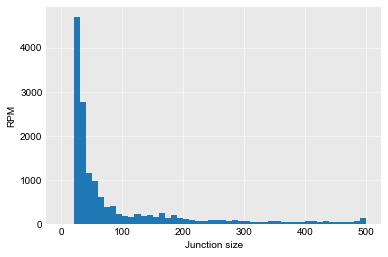

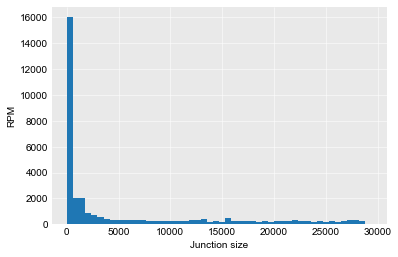

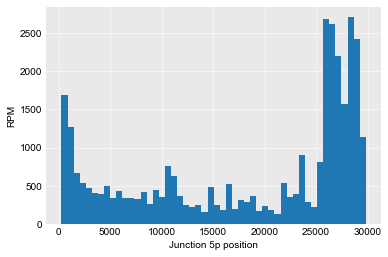

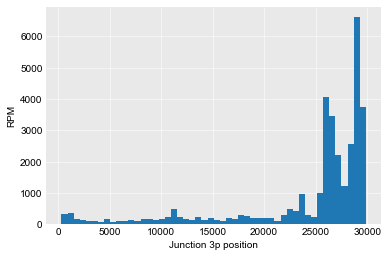

RPF_36h_rep1 71 99.27565469097563
RPF_36h_rep2 61 99.14165251514537
36h	RPFSeq	105
---Canonical junctions---
S	65-21551	2197.774801586538	False
ORF3a	66-25381	2297.9795634913503	False
E	69-26236	1921.4646825391799	False
M	64-26467	2163.5617063484724	False
ORF6	69-27040	1913.0646825392082	False
ORF7a	66-27384	2699.8319444436847	False
ORF7b	71-27761	1809.974404761415	False
ORF8	65-27883	2260.1081349198703	False
N	64-28254	2388.0783730150924	False
-------------------------
Unique in one of 2 replicates: 78 / 105
total: 19805.104960311473, unique only: 46.949999999999996
-----Top50 junctions-----
66-27384	2699.8319444436847	False
64-28254	2388.0783730150924	False
66-25381	2297.9795634913503	False
65-27883	2260.1081349198703	False
65-21551	2197.774801586538	False
64-26467	2163.5617063484724	False
69-26236	1921.4646825391799	False
69-27040	1913.0646825392082	False
71-27761	1809.974404761415	False
68-28262	31.32499999999998	False
65-25380	14.43333333333333	False
26786-26820	7.0	False
26784-26

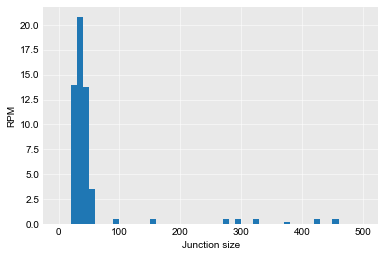

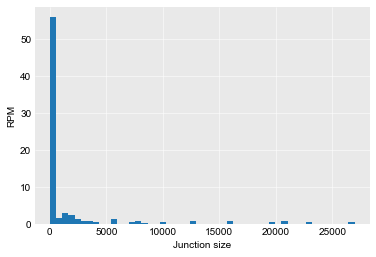

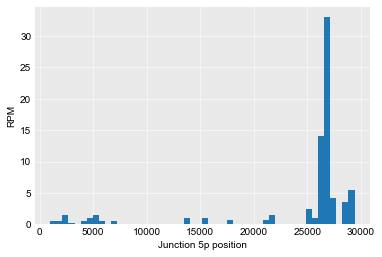

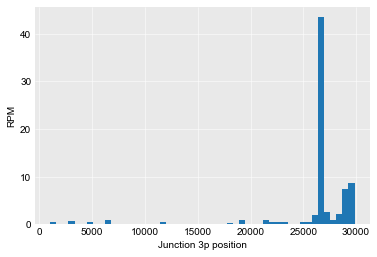

RPFpaired_48h_rep1 24191 84.31265458813681
RPFpaired_48h_rep2 26601 85.08554424764331
RPFpaired_48h_rep3 26047 87.78118814546448
QTIpaired_48h_rep1 20495 76.3480731405261
QTIpaired_48h_rep2 15450 74.91994849525817
QTIpaired_48h_rep3 10461 73.59274781229045
48h	mRNASeq	97488
---Canonical junctions---
S	65-21551	11000.333333333334	False
ORF3a	66-25381	59675.52777777778	False
E	69-26236	4615.833333333333	False
M	64-26467	44322.5	False
ORF6	69-27040	5388.333333333333	False
ORF7a	66-27384	42757.61666666666	False
ORF7b	71-27761	825.8333333333334	False
ORF8	65-27883	32193.338888888884	False
N	64-28254	126783.60000000011	False
-------------------------
Unique in one of 6 replicates: 83956 / 97488
total: 397535.9345246923, unique only: 19086.766666651496
-----Top50 junctions-----
64-28254	126783.60000000011	False
66-25381	59675.52777777778	False
64-26467	44322.5	False
66-27384	42757.61666666666	False
65-27883	32193.338888888884	False
65-21551	11000.333333333334	False
26256-26283	6898.3194444444

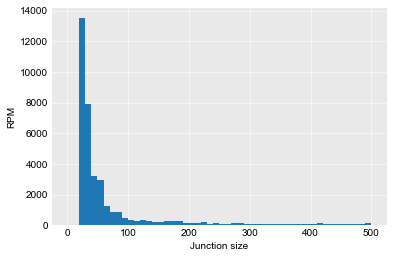

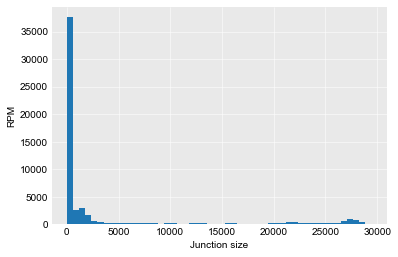

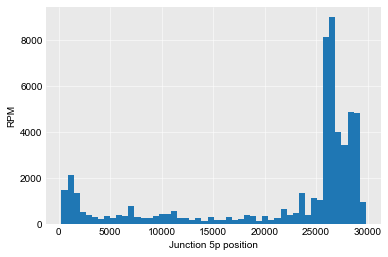

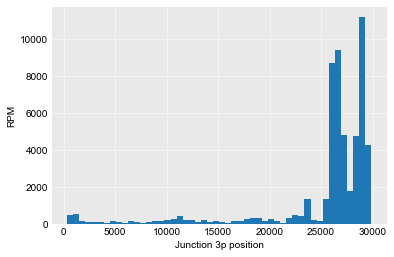

RPF_48h_rep1 129 99.24717514467355
RPF_48h_rep2 175 99.16070216516256
RPF_48h_rep3 152 99.16530933059127
48h	RPFSeq	349
---Canonical junctions---
S	65-21551	19528.234920646242	False
ORF3a	66-25381	21705.171825402304	False
E	69-26236	18619.484920655683	False
M	64-26467	20412.72169312355	False
ORF6	69-27040	17845.358730180185	False
ORF7a	66-27384	23617.180158739855	False
ORF7b	71-27761	17332.034656106425	False
ORF8	65-27883	21609.08492064379	False
N	64-28254	21244.189947096518	False
-------------------------
Unique in one of 3 replicates: 282 / 349
total: 183405.135714395, unique only: 114.45767195767165
-----Top50 junctions-----
66-27384	23617.180158739855	False
66-25381	21705.171825402304	False
65-27883	21609.08492064379	False
64-28254	21244.189947096518	False
64-26467	20412.72169312355	False
65-21551	19528.234920646242	False
69-26236	18619.484920655683	False
69-27040	17845.358730180185	False
71-27761	17332.034656106425	False
68-28262	642.5444444444419	False
65-25380	159.1	False
26784-

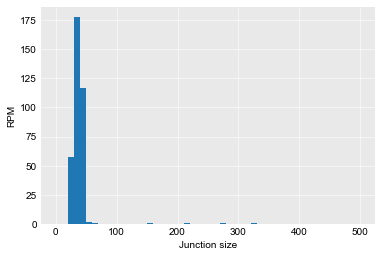

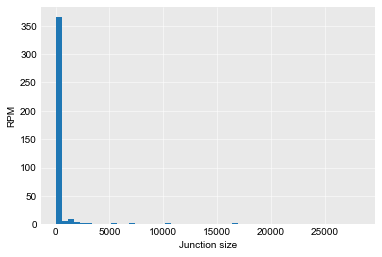

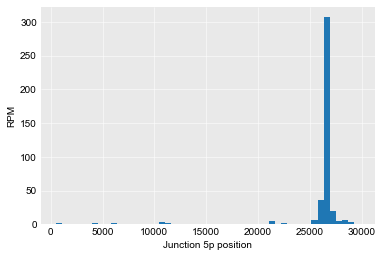

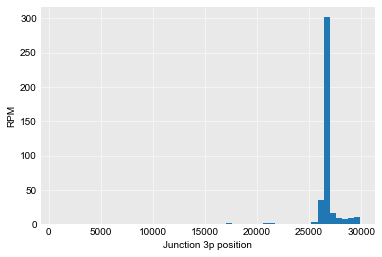

,hpi,assay,n_total_JSreads,pct_exact_canonical,pct_TRS_L_dep_JSreads,pct_TIS_L_dep_JSreads,pct_body_JSreads,pct_multiskip
0,36h,mRNASeq,198571.200000,79.642896,82.284304,82.706979,17.155433,0.825743
1,36h,RPFSeq,19805.104960,99.226125,99.591015,99.593539,0.381215,0.005049
2,48h,mRNASeq,397535.934525,82.398316,85.225721,85.622847,14.221584,0.700594
3,48h,RPFSeq,183405.135714,99.186678,99.768000,99.769181,0.223912,0.017357


as_RPM: True
RPFpaired_36h_rep1 14040 80.29359399033382
RPFpaired_36h_rep2 13222 83.1574333422701
QTIpaired_36h_rep1 14631 69.48187272712133
QTIpaired_36h_rep2 17445 78.69942057167228
36h	mRNASeq	51942
---Canonical junctions---
S	65-21551	641.5055539636081	False
ORF3a	66-25381	5006.00644968893	False
E	69-26236	778.3596939722813	False
M	64-26467	4736.024277447515	False
ORF6	69-27040	340.57236993732283	False
ORF7a	66-27384	3503.711287186189	False
ORF7b	71-27761	58.73010227196653	False
ORF8	65-27883	1731.9827836082873	False
N	64-28254	6919.727891225422	False
-------------------------
Unique in one of 4 replicates: 47164 / 51942
total: 30076.988553787174, unique only: 3227.8350162963025
-----Top50 junctions-----
64-28254	6919.727891225422	False
66-25381	5006.00644968893	False
64-26467	4736.024277447515	False
66-27384	3503.711287186189	False
65-27883	1731.9827836082873	False
69-26236	778.3596939722813	False
65-21551	641.5055539636081	False
69-27040	340.57236993732283	False
26256-26283	224.7

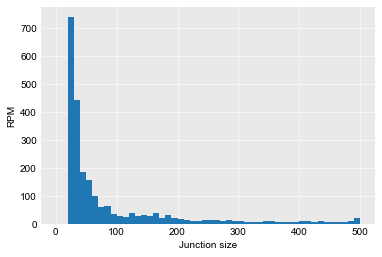

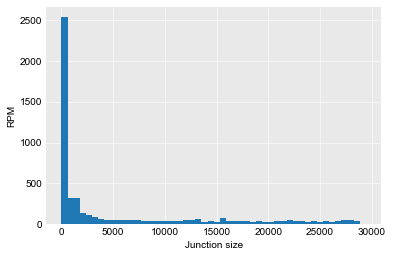

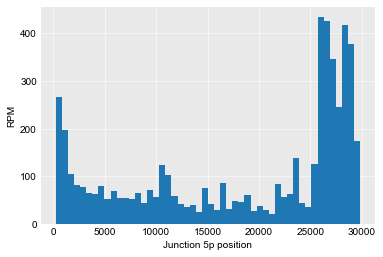

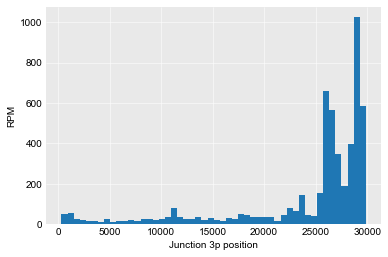

RPF_36h_rep1 71 99.2756546909756
RPF_36h_rep2 61 99.14165251514544
36h	RPFSeq	105
---Canonical junctions---
S	65-21551	2327.3255997272977	False
ORF3a	66-25381	2435.0964136981434	False
E	69-26236	2033.453284411638	False
M	64-26467	2289.2186889769982	False
ORF6	69-27040	2023.0637553353295	False
ORF7a	66-27384	2868.806614419482	False
ORF7b	71-27761	1914.3116359369237	False
ORF8	65-27883	2393.7641457672826	False
N	64-28254	2530.7958671842653	False
-------------------------
Unique in one of 2 replicates: 78 / 105
total: 20978.84150287441, unique only: 49.88052320232053
-----Top50 junctions-----
66-27384	2868.806614419482	False
64-28254	2530.7958671842653	False
66-25381	2435.0964136981434	False
65-27883	2393.7641457672826	False
65-21551	2327.3255997272977	False
64-26467	2289.2186889769982	False
69-26236	2033.453284411638	False
69-27040	2023.0637553353295	False
71-27761	1914.3116359369237	False
68-28262	33.36134862886466	False
65-25380	15.315066751748903	False
26786-26820	7.564622434389087	Fa

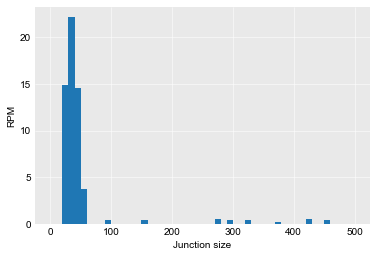

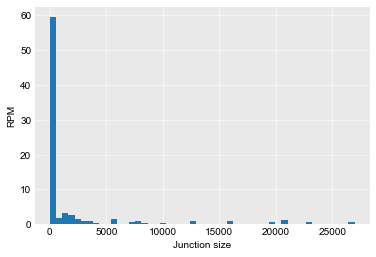

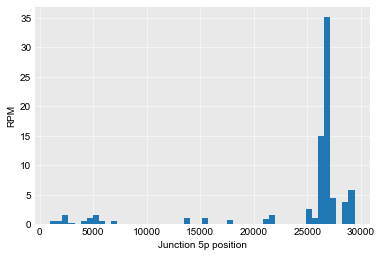

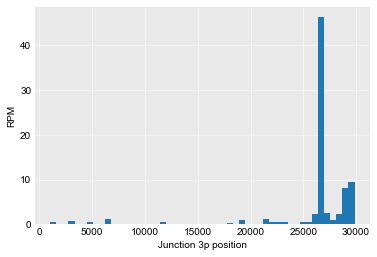

KeyboardInterrupt: 

In [50]:
for as_RPM in [ False, True]:
    print('as_RPM:', as_RPM)
    df_report = []
    for hpi in ['36h','48h']:
        for assay_prefix in ['mRNASeq','RPFSeq']:

            if assay_prefix == 'mRNASeq':
                sample_prefix = None
            else:
                sample_prefix = 'RPF'
        
            report = calc_JSreads(hpi, assay_prefix = assay_prefix, sample_prefix = sample_prefix, as_RPM = as_RPM)
            df_report.append(report)
    
    df_report = pd.DataFrame(df_report)
    df_report.columns = ['hpi','assay','n_total_JSreads',
                         'pct_exact_canonical',
                         'pct_TRS_L_dep_JSreads',
                         'pct_TIS_L_dep_JSreads',
                         'pct_body_JSreads', 
                         'pct_multiskip'
                        ]
    display(df_report)

In [109]:
def plot_CDF_SJreads(hpi, assay_prefix = 'mRNASeq', sample_prefix = None, as_RPM = True):
    #hpi_list = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
    global CANONICAL_sgRNA_junc_dict

    if assay_prefix == 'mRNASeq':
        sample_prefix_list = ['RPFpaired','QTIpaired']
    else:
        sample_prefix_list = [sample_prefix]
        
    if hpi == '48h':
        reps=3
    else:
        reps=2
        
    merged_dict_JSreads = {}
    for prefix in sample_prefix_list:
        for rep in range(1,reps+1):
            samplename = f'{prefix}_{hpi}_rep{rep}'
            dict_JSreads = get_junction_spanning_reads(samplename,assay_prefix,norm_by_nh=True,
                                                       fetch_range=(0,29903), as_RPM=as_RPM)
            print(samplename, len(dict_JSreads), 
                  sum([dict_JSreads['%d-%d' %(s,e)] for ORF, (s,e) in CANONICAL_sgRNA_junc_dict.items()])/sum([val for JSkey,val in dict_JSreads.items()])*100)

            for JSkey, ct in dict_JSreads.items():
                if JSkey in merged_dict_JSreads.keys():
                    merged_dict_JSreads[JSkey].append(ct)
                else:
                    merged_dict_JSreads[JSkey]  = [ct]
                    
    n_replicates  = len(sample_prefix_list)*reps
    for JSkey in merged_dict_JSreads.keys():
        unique    = True if len(merged_dict_JSreads[JSkey]) == 1 else False
        recurrent = True if len(merged_dict_JSreads[JSkey]) == n_replicates else False
        merged_dict_JSreads[JSkey] = [sum(merged_dict_JSreads[JSkey])/n_replicates, unique,recurrent]
        
    
    n_total_JSreads     = sum([val for JSkey,(val,unique,recurrent) in merged_dict_JSreads.items()])
    n_canonical_JSreads = 0
    print(hpi, assay_prefix, len(merged_dict_JSreads),sep = '\t')
    print('---Canonical junctions---')
    for ORF, (s,e) in CANONICAL_sgRNA_junc_dict.items():
        JSkey = '%d-%d' %(s,e) 
        n_JSreads,unique,recurrent = merged_dict_JSreads[JSkey]
        print(ORF, JSkey, n_JSreads, unique,recurrent, sep = '\t')
        n_canonical_JSreads += n_JSreads
    print('-------------------------')
    sorted_JSreads_list = sorted([(JSkey,val,unique,recurrent) for JSkey,(val,unique,recurrent) in merged_dict_JSreads.items()], 
                                 key = lambda x: x[1], reverse = True)
    print(f'Unique in one of {n_replicates} replicates: {len([i for i in sorted_JSreads_list if i[2] == True])} / {len(sorted_JSreads_list)}')
    print(f'total: {n_total_JSreads}, \nunique only: {sum([i[1] for i in sorted_JSreads_list if i[2] == True])}\nrecurrent only: {sum([i[1] for i in sorted_JSreads_list if i[3] == True])}')
    
    
    sorted_JSreads_list = [[i,*JSread] for i, JSread in enumerate(sorted_JSreads_list)]
    
    
    n, bins, patches = plt.hist([i[0] for i in sorted_JSreads_list],weights = [i[2] for i in sorted_JSreads_list], 
                                bins = len(sorted_JSreads_list),  cumulative = True, density = True, histtype='step')
    plt.axhline(0.9 , color='r')
    plt.axhline(0.95, color='g')
    plt.axhline(0.99, color='magenta')
    plt.ylabel('cumulative RPM fraction')
    plt.xlabel('Junction rank')
    plt.ylim(0.5,1.0)
    #plt.xlim(0,300)
    plt.show()
    plt.close()
    

    return n, sorted_JSreads_list

RPFpaired_36h_rep1 14040 80.29359399033382
RPFpaired_36h_rep2 13222 83.1574333422701
QTIpaired_36h_rep1 14631 69.48187272712133
QTIpaired_36h_rep2 17445 78.69942057167228
36h	mRNASeq	51942
---Canonical junctions---
S	65-21551	641.5055539636081	False	True
ORF3a	66-25381	5006.00644968893	False	True
E	69-26236	778.3596939722813	False	True
M	64-26467	4736.024277447515	False	True
ORF6	69-27040	340.57236993732283	False	True
ORF7a	66-27384	3503.711287186189	False	True
ORF7b	71-27761	58.73010227196653	False	True
ORF8	65-27883	1731.9827836082873	False	True
N	64-28254	6919.727891225422	False	True
-------------------------
Unique in one of 4 replicates: 47164 / 51942
total: 30076.988553787174, 
unique only: 3227.8350162963025
recurrent only: 25956.131161115045


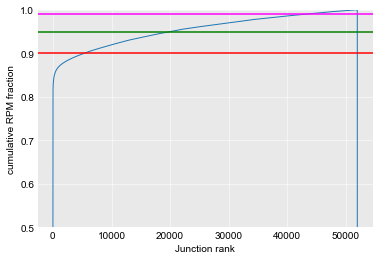

In [110]:
arr, sorted_JSreads_list = plot_CDF_SJreads('36h', assay_prefix = 'mRNASeq', sample_prefix = None, as_RPM = True)

In [112]:
len([i for i in sorted_JSreads_list if i[4] == True])

804

In [114]:
ct = 0
df_annot = get_df_SARSCOV2_annot(exc_UTR = True)
display(df_annot)
print('junction_s','junction_s_ORF','junction_e','junction_e_ORF','type','canonical_ORFlen','Fused_ORFlen',sep='\t')
RPM_inframe    = 0.0
RPM_outofframe = 0.0
RPM_chimeric   = 0.0
topN = 20
for rank, JSkey, n_JSreads, unique, recurrent in sorted_JSreads_list:
    s,e = JSkey.split('/')[0].split('-')
    s,e = int(s), int(e)
    if s>265 and recurrent:
        
        ct += 1
    else:
        continue
    ORF_junc_s = ''
    ORF_junc_e = ''
    for ORF, row in df_annot.iterrows():
        if row['ORFstart'] <= s and s < row['ORFend']:
            ORF_junc_s = ORF
        if row['ORFstart'] <= e and e < row['ORFend']:
            ORF_junc_e = ORF
    if ORF_junc_s == '':
        continue
    if ORF_junc_s == ORF_junc_e:
        junc_size = e-s
        ORFstart = df_annot.loc[ORF_junc_s, 'ORFstart']
        ORFend   = df_annot.loc[ORF_junc_s, 'ORFend']
        canonical_ORFlen = ORFend - ORFstart
        if junc_size%3 == 0:
            if ct<=topN:
                print(s,ORF_junc_s,e,ORF_junc_e,'in-frame',canonical_ORFlen,canonical_ORFlen-(e-s),n_JSreads, unique, recurrent, sep='\t')
            RPM_inframe += n_JSreads
        else:
            
            fused_txt = SARSCOV2_genome[ORFstart:s]+SARSCOV2_genome[e:]
            fused_ORFlen     = 0
            for i in range(0,len(fused_txt),3):
                if fused_txt[i:i+3] in ['TAG','TAA','TGA']:
                    fused_ORFlen = i+3
                    break
            if ct<=topN:
                print(s,ORF_junc_s,e,ORF_junc_e,'out-of-frame',canonical_ORFlen,fused_ORFlen,n_JSreads, unique, recurrent, sep='\t')
            RPM_outofframe += n_JSreads
        
    else:
        ORFstart = df_annot.loc[ORF_junc_s, 'ORFstart']
        ORFend   = df_annot.loc[ORF_junc_s, 'ORFend']

        canonical_ORFlen = ORFend - ORFstart
        fused_txt = SARSCOV2_genome[ORFstart:s]+SARSCOV2_genome[e:]
        fused_ORFlen     = 0
        for i in range(0,len(fused_txt),3):
            if fused_txt[i:i+3] in ['TAG','TAA','TGA']:
                fused_ORFlen = i+3
                break
        if ct<=topN:
            print(s,ORF_junc_s,e,ORF_junc_e,'chimeric',canonical_ORFlen,fused_ORFlen,n_JSreads, unique, recurrent,sep='\t')
        RPM_chimeric += n_JSreads
print(RPM_inframe, RPM_outofframe, RPM_chimeric)

,chromosome,strand,ORFstart,ORFend
ORF,,,,
ORF1a,NC_045512.2,+,265,13483
ORF1b,NC_045512.2,+,13467,21555
S,NC_045512.2,+,21562,25384
ORF3a,NC_045512.2,+,25392,26220
E,NC_045512.2,+,26244,26472
M,NC_045512.2,+,26522,27191
ORF6,NC_045512.2,+,27201,27387
ORF7a,NC_045512.2,+,27393,27759
ORF7b,NC_045512.2,+,27755,27887


junction_s	junction_s_ORF	junction_e	junction_e_ORF	type	canonical_ORFlen	Fused_ORFlen
26256	E	26283	E	in-frame	228	201	224.71678481724177	False	True
29069	N	29093	N	in-frame	1260	1236	100.20454643411193	False	True
26779	M	26816	M	out-of-frame	669	351	55.00515907798843	False	True
26786	M	26820	M	out-of-frame	669	354	37.97224366594448	False	True
16425	ORF1b	29525	N	chimeric	8088	3003	27.535315910088116	False	True
11268	ORF1a	11300	ORF1a	out-of-frame	13218	11073	24.739787092619135	False	True
26774	M	26830	M	out-of-frame	669	294	23.858024627823454	False	True
27800	ORF7b	29172	N	chimeric	132	168	20.598250396610414	False	True
26784	M	26820	M	in-frame	669	633	18.538651141983223	False	True
27263	ORF6	27290	ORF6	in-frame	186	159	17.93240034604583	False	True
27190	M	27221	ORF6	chimeric	669	834	17.12573437738083	False	True
23554	S	23582	S	out-of-frame	3822	2034	14.956498715820466	False	True
26775	M	26817	M	in-frame	669	627	14.283150995170768	False	True
26939	M	26975	M	in-frame	669	633	14.0996530

In [46]:
df_Kim = pd.read_csv('../data/Kimetal2020_junctions.txt',sep='\t',header =0)
df_Kim.loc[-1] = [66,25381,0,0,'','','','']
df_Kim.head()


,5' site,3' site,count,skip,5p_before,5p_after,3p_before,3p_after
0,64,28254,7012631,28190,AGATCTGTTC,TCTAAACGAA,TTAGATTTCA,TCTAAACGAA
1,65,21551,1117576,21486,GATCTGTTCT,CTAAACGAAC,TTGTTAACAA,CTAAACGAAC
2,26256,26283,800532,27,GTACTCATTC,GTTTCGGAAG,TACGTTAATA,GTTAATAGCG
3,66,27384,688112,27318,ATCTGTTCTC,TAAACGAACT,GGAGATTGAT,TAAACGAACA
4,65,25380,618367,25315,GATCTGTTCT,CTAAACGAAC,TACATTACAC,ATAAACGAAC


In [47]:
df_sorted_JSreads = pd.DataFrame(sorted_JSreads_list)
df_sorted_JSreads.columns = ['rank','junc','RPM','unique','recurrent']
df_sorted_JSreads = df_sorted_JSreads.set_index('junc')

idx_Kim = []
for _, row in df_Kim.iterrows():
    idx_Kim.append('%s-%s' %(row['5\' site'], row['3\' site']))
display(df_sorted_JSreads.loc[idx_Kim].dropna().head(50))
print(df_sorted_JSreads['RPM'].sum(),df_sorted_JSreads.loc[idx_Kim,'RPM'].dropna().sum())

/home/sonic/baeklab/Hyeonseong/anaconda3/envs/Doyeon-tf2/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,rank,RPM,unique
junc,,,
64-28254,0.0,6919.727891,False
65-21551,6.0,641.505554,False
26256-26283,8.0,224.716785,False
66-27384,3.0,3503.711287,False
65-25380,9.0,144.733456,False
65-27883,4.0,1731.982784,False
64-26467,2.0,4736.024277,False
69-26236,5.0,778.359694,False
69-27040,7.0,340.572370,False


30076.98855378985 25060.753102841107


/home/sonic/baeklab/Hyeonseong/anaconda3/envs/Doyeon-tf2/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [48]:
df_sorted_JSreads.loc[idx_Kim,'unique'].dropna().sum()

/home/sonic/baeklab/Hyeonseong/anaconda3/envs/Doyeon-tf2/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


51

In [49]:
df_sorted_JSreads.loc[idx_Kim,'unique'].isna().sum()

/home/sonic/baeklab/Hyeonseong/anaconda3/envs/Doyeon-tf2/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


158

In [116]:
def ftn(a):
    return a+1
ftn2 = eval('np.add')
print(ftn2)
print(ftn2(1,2))

<ufunc 'add'>
3
